In [1]:
%matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau
import Utility
import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj, load_ply
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes_as_batch
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    BlendParams,
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))

print(torch.version.cuda)
from datetime import datetime

SMPLSH_Dir = r'..\SMPL_reimp'

import sys
sys.path.insert(0, SMPLSH_Dir)
import smplsh_torch

from os.path import join
import pyvista as pv
import Logger

10.1


In [3]:
import importlib
importlib.reload(Utility)
from Utility import *

In [4]:
class RenderingCfg:
    def __init__(s):
        s.sigma = 1e-4
        s.blurRange = 1e-4
        s.faces_per_pixel = 50
        s.bodyJointOnly = False
        s.randSeedPerturb = 1234
        s.noiseLevel = 0.5
        s.numIterations = 2000
        s.learningRate = 0.005
        s.terminateLoss = 200
        s.plotStep = 10
        s.numCams = 16
        s.imgSize = 2160
        
        s.lpSmootherW = 0.1
        s.normalSmootherW = 0.1

        
class Renderer:
    def __init__(s, cfg = RenderingCfg):
        s.cfg = cfg
        # blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
        s.blend_params = BlendParams(sigma=cfg.sigma, gamma=1e-4)

        # Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
        # -z direction. 
        s.lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
#         cameras = OpenGLPerspectiveCameras(device=device)
        # Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
        # interpolate the texture uv coordinates for each vertex, sample from a texture image and 
        # apply the Phong lighting model
        
        if cfg.blurRange!= 0:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= np.log(1. / cfg.blurRange - 1.) * s.blend_params.sigma, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
        else:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= 0, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
            
        s.rasterizer=MeshRasterizer(
                cameras=None, 
                raster_settings=s.raster_settings
            )
        if cfg.blurRange!= 0:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
            #     shader=SoftPhongShader(
            #         device=device, 
            #         cameras=cameras,
            #         lights=lights,
            #         blend_params=blend_params
            #     )
                shader=SoftSilhouetteShader(
                    blend_params=s.blend_params
                    # device=device, 
                    # cameras=cameras,
                    # lights=lights
                )
            )
        else:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
            #     shader=SoftPhongShader(
            #         device=device, 
            #         cameras=cameras,
            #         lights=lights,
            #         blend_params=blend_params
            #     )
                shader=SoftSilhouetteShader(
                    blend_params=s.blend_params
                    # device=device, 
                    # cameras=cameras,
                    # lights=lights
                )
            )

In [5]:
cfg = RenderingCfg()
# cfg.sigma = 1e-3
cfg.noiseLevel = 0.1
# cfg.blurRange = 1e-1
# cfg.sigma = 1e-4
# cfg.sigma = 1e-5

# cfg.blurRange = 1e-4

# cfg.sigma = 1e-6
# cfg.blurRange = 1e-5

cfg.sigma = 1e-7
cfg.blurRange = 1e-7

cfg.plotStep = 1
cfg.numCams = 16
# cfg.learningRate = 1
# cfg.learningRate = 0.1
cfg.learningRate = 1

cfg.normalShiftLevel = 10
# cfg.faces_per_pixel = 14
cfg.faces_per_pixel = 30

# cfg.imgSize = 2160   
cfg.imgSize = 1080
device = torch.device("cuda:0")
cfg.terminateLoss = 0.1
renderSynth = Renderer(cfg)

cfgRef = RenderingCfg()
cfgRef.faces_per_pixel = 1
cfgRef.blurRange = 0
cfgRef.sigma = 0
cfgRef.imgSize = 1080
renderRef = Renderer(cfgRef)

In [6]:
camParamF = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\CameraParams\cam_params.json'
imageFolder = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Images\03052\Undist'
modelFile = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Models\03052.obj'

outFolder = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Output\SyntheticSilhouette'
smplshExampleMeshFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSH\SMPLSH.obj'

In [7]:

actual_img_shape = (2160, 4000)
cam_params, cams_torch = load_cameras(camParamF, device, actual_img_shape)
print(len(cam_params), ':', cam_params[0].keys())
print(cams_torch.keys())

smplshExampleMesh = pv.PolyData(smplshExampleMeshFile)

actual_img_shape: (2160, 4000)
16 : dict_keys(['K', 'dist', 'R', 'T', 'fx', 'fy', 'cx', 'cy'])
dict_keys(['R', 'T', 'fl', 'pp'])


In [8]:
cams_torch['fl']

tensor([[1.7616, 1.7604],
        [1.7548, 1.7537],
        [1.7569, 1.7558],
        [1.7568, 1.7558],
        [1.7532, 1.7523],
        [1.7562, 1.7548],
        [1.7579, 1.7567],
        [1.7568, 1.7555],
        [1.7565, 1.7552],
        [1.7648, 1.7633],
        [1.7565, 1.7554],
        [1.7601, 1.7592],
        [1.7568, 1.7557],
        [1.7585, 1.7573],
        [1.7578, 1.7566],
        [1.7564, 1.7553]])

In [9]:
cams = init_camera_batches(cams_torch, device)

In [10]:
verts, faces, aux = load_obj(modelFile)
verts = verts.to(device)
faces_idx = faces.verts_idx.to(device)

nVerts = verts.shape[0]

C:\Users\Anka\.conda\envs\pytorch3d\lib\site-packages\pytorch3d-0.2.0-py3.6-win-amd64.egg\pytorch3d\io\obj_io.py:70: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


In [11]:
aux.normals.shape

torch.Size([6750, 3])

In [12]:
nNormals = normalizeNormals(aux.normals).to(device)

torch.Size([6750])


In [13]:
normalShiftRef = torch.tensor(np.full((nVerts,1), cfg.normalShiftLevel), dtype=torch.float32, device=device)

In [21]:
nNormals

tensor([[ 0.7431, -0.5174,  0.4244],
        [ 0.6826, -0.5591,  0.4706],
        [ 0.8415, -0.3859,  0.3782],
        ...,
        [ 0.3730, -0.8021,  0.4664],
        [ 0.4670, -0.6423, -0.6077],
        [-0.9316, -0.3278, -0.1569]], device='cuda:0')

In [22]:
modifiedVertsRef = verts + normalShiftRef * nNormals
meshRef = Meshes(
                verts=[modifiedVertsRef],   
                faces=[faces_idx], 
#                 textures=textures.to(device)
            )

In [23]:
def visualize2DResults(images, backGroundImages=None, outImgFile=None, rows = 2, pytorch3DImg=True, sizeInInches = 2):
    lossVal = 0
    numCams = len(images)
    numCols = int(numCams / rows)
    fig, axs = plt.subplots(rows, numCols)
    fig.set_size_inches(numCols*sizeInInches, rows*sizeInInches)
    with torch.no_grad():
        for iRow in range(rows):
            for iCol in range(numCols):
                iCam = rows* iRow + iCol
                if pytorch3DImg:
                    imgAlpha = images[iCam][0,...,3]
                else:
                    imgAlpha = images[iCam]
                    
                if backGroundImages is not None:
                    img = np.copy(backGroundImages[iCam])
#                     fgMask = np.logical_not(np.where())
                    for iChannel in range(3):
                        img[..., iChannel] = np.where(imgAlpha, imgAlpha, backGroundImages[iCam][...,iChannel])
                    imgAlpha = img
                    
                imgAlpha = cv2.flip(imgAlpha, -1)
                
                axs[iRow, iCol].imshow(imgAlpha, vmin=0.0, vmax=1.0)
                axs[iRow, iCol].axis('off')

        if outImgFile is not None:
            fig.savefig(outImgFile, dpi=512, transparent=True, bbox_inches='tight', pad_inches=0)

In [24]:
normalShift = torch.tensor(np.full((nVerts,1), 0), dtype=torch.float32, requires_grad = True, device=device)

In [25]:
modifiedVerts = verts + normalShift * nNormals
mesh = Meshes(
                verts=[modifiedVerts.to(device)],   
                faces=[faces_idx.to(device)], 
#                 textures=textures.to(device)
            )

In [26]:
modifiedVerts.requires_grad

True

In [27]:
expName = 'Sig_' + str(cfg.sigma) + '_BRange' + str(cfg.blurRange) + '_Fpp' + str(cfg.faces_per_pixel) \
+ '_NCams_' + str(cfg.numCams)+ 'ImSize_' + str(cfg.imgSize) + "_LR_" + str(cfg.learningRate)

outFolderForExperiment = join(outFolder, expName)
os.makedirs(outFolderForExperiment, exist_ok=True)
print(outFolderForExperiment)

json.dump(cfg.__dict__, open(join(outFolderForExperiment, 'cfg.json'), 'w'), indent=2)

outFolderMesh = join(outFolderForExperiment, 'Mesh')
os.makedirs(outFolderMesh, exist_ok=True)

F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Output\SyntheticSilhouette\Sig_1e-07_BRange1e-06_Fpp30_NCams_16ImSize_1080_LR_0.1


<IPython.core.display.Javascript object>


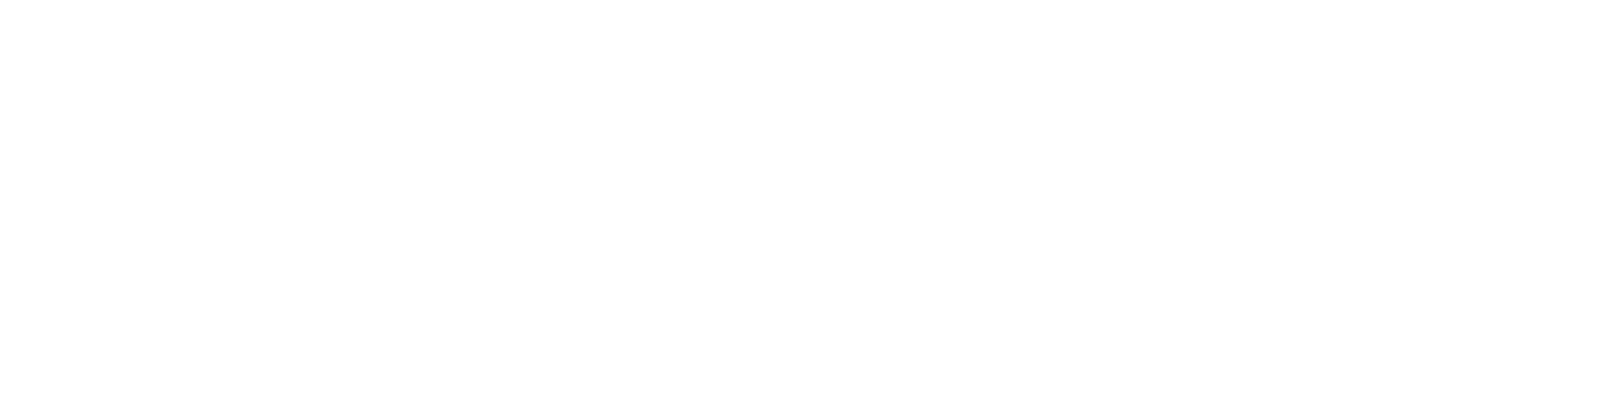

In [28]:
imagesRef = []
with torch.no_grad():
    for iCam in range(len(cams)):
        image_cur = renderRef.renderer(meshRef,  cameras=cams[iCam]).cpu().detach().numpy()
        image_cur[np.where(image_cur)] = 1        
        imagesRef.append(image_cur)
visualize2DResults(imagesRef, outImgFile = join(outFolderForExperiment, 'Target.png'))

<IPython.core.display.Javascript object>


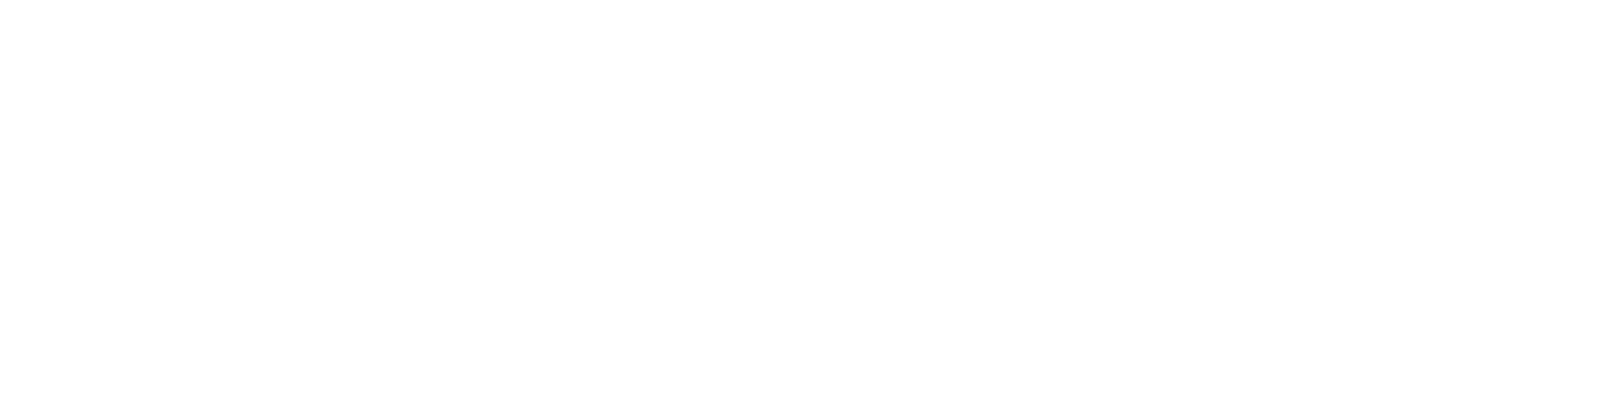

Before release: active_bytes.all.current: 21.490688 MB
After release: active_bytes.all.current: 21.490688 MB


In [29]:
images = []
with torch.no_grad():
    for iCam in range(len(cams)):
        image_cur = renderSynth.renderer(mesh,  cameras=cams[iCam])
        images.append(image_cur.cpu().detach().numpy())
visualize2DResults(images)
showCudaMemUsage(device)

In [30]:
diffImages = []
loss = 0
for iCam in range(len(cams)):
    imgDiff = np.abs(images[iCam] - imagesRef[iCam])
    diffImages.append(imgDiff)
    
    loss += 1 -np.sum(np.abs(images[iCam][..., 3] * imagesRef[iCam][..., 3])) / np.sum(np.abs(imagesRef[iCam][..., 3] + images[iCam][..., 3] - imagesRef[iCam][..., 3] * images[iCam][..., 3]))

In [31]:
print("mesh_laplacian_smoothing", mesh_laplacian_smoothing(mesh))
print("mesh_normal_consistency", mesh_normal_consistency(mesh))

mesh_laplacian_smoothing tensor(2.6368, device='cuda:0')
mesh_normal_consistency tensor(0.0479, device='cuda:0')


In [32]:
a = np.array([[2,2], [2,2]])
print(np.linalg.norm(a.flatten(), ord=1))

8.0


<IPython.core.display.Javascript object>


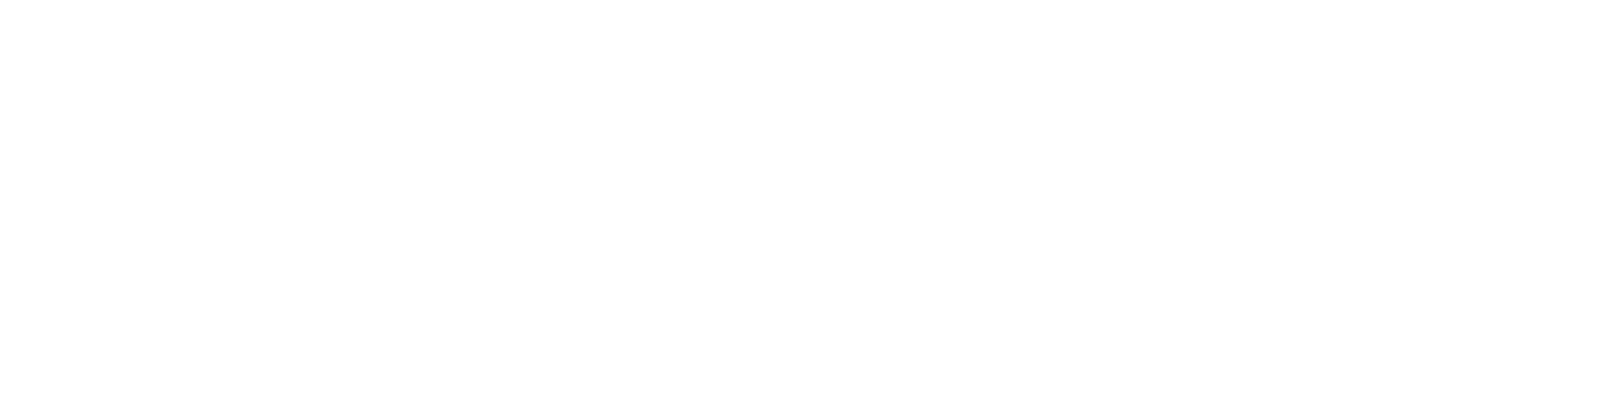

In [33]:
visualize2DResults(diffImages)

In [34]:
# with torch.no_grad():
#     loss = torch.sum((imageRef[..., 3] - image[..., 3]) ** 2)
# print('Inital loss:', loss)
poses = []
losses = []

# cfg.learningRate = 0.05
# cfg.learningRate = 0.1
cfg.plotStep = 5
# cfg.learningRate = 3

In [35]:


optimizer = torch.optim.Adam([normalShift], lr=cfg.learningRate)

logFile = join(outFolderForExperiment, 'Logs.txt')
logger = Logger.configLogger(logFile)

In [36]:
torch.cuda.empty_cache()
showCudaMemUsage(device)


Before release: active_bytes.all.current: 23.247872 MB
After release: active_bytes.all.current: 23.247872 MB


C:\Users\Anka\.conda\envs\pytorch3d\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


2020-06-02 23:10:56,173 logger INFO loss 2.22, 3D Dis:  10.00mm, shiftDiff: 67168.484375, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


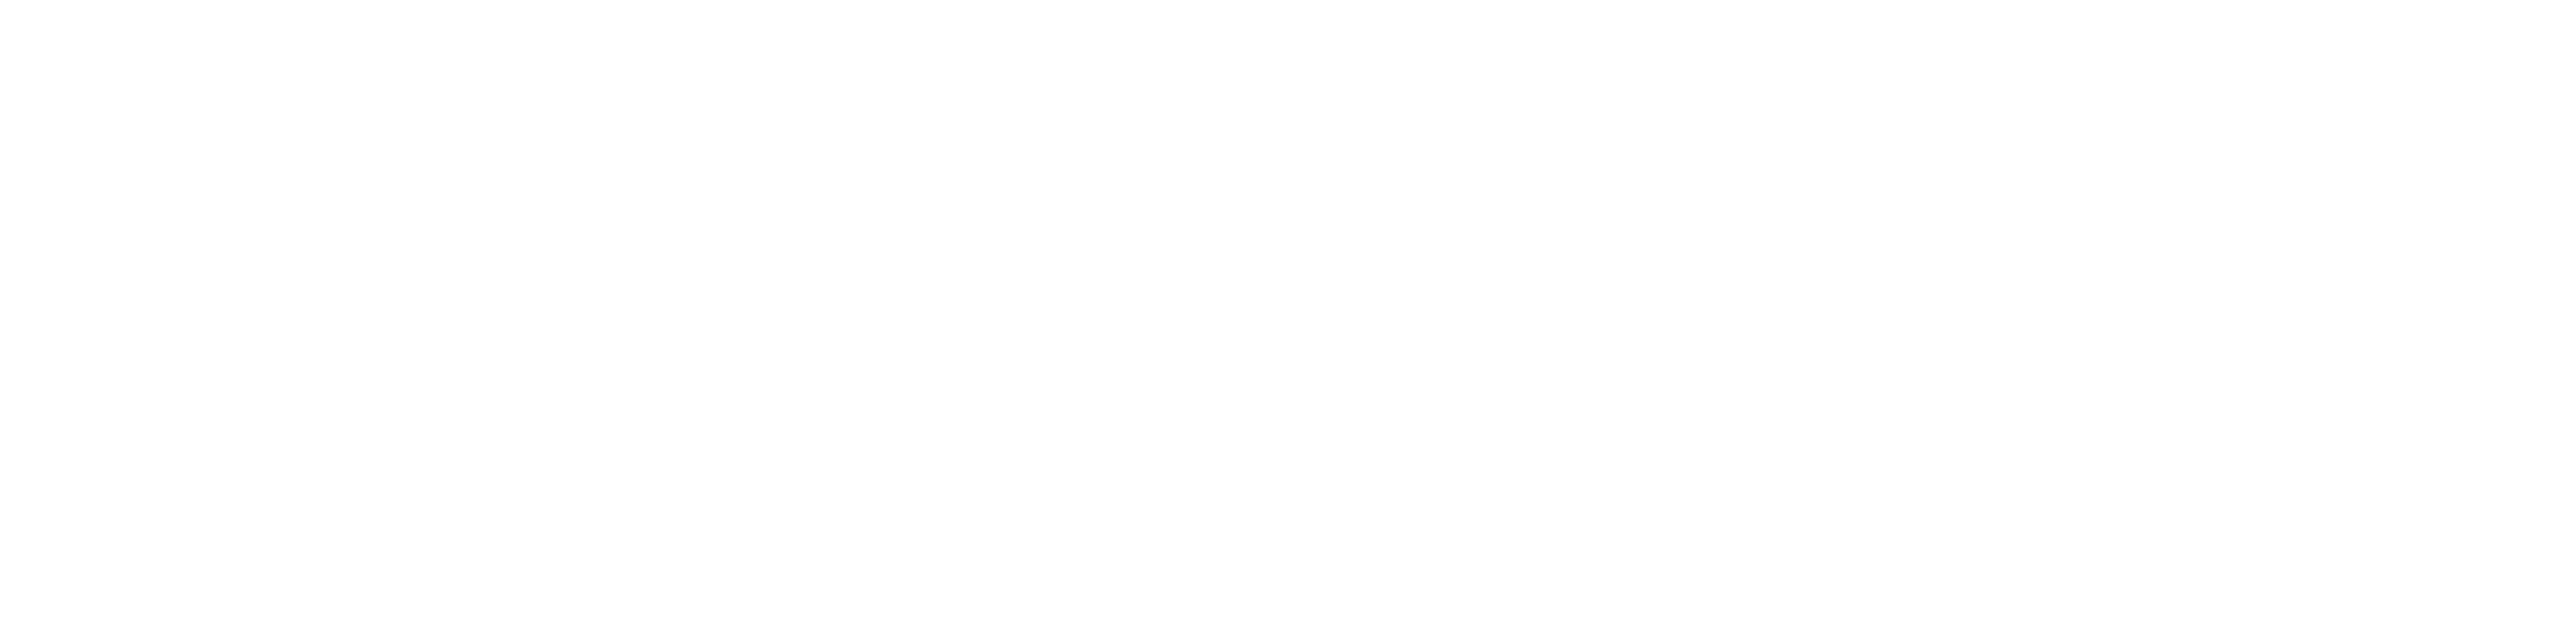

2020-06-02 23:11:24,524 logger INFO loss 2.20, 3D Dis:  9.95mm, shiftDiff: 66836.859375, MemUsed:50.86
2020-06-02 23:11:33,456 logger INFO loss 2.17, 3D Dis:  9.90mm, shiftDiff: 66507.031250, MemUsed:50.86
2020-06-02 23:11:42,342 logger INFO loss 2.15, 3D Dis:  9.85mm, shiftDiff: 66177.726562, MemUsed:50.86
2020-06-02 23:11:51,299 logger INFO loss 2.13, 3D Dis:  9.80mm, shiftDiff: 65849.203125, MemUsed:50.86
2020-06-02 23:12:00,302 logger INFO loss 2.11, 3D Dis:  9.76mm, shiftDiff: 65521.726562, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


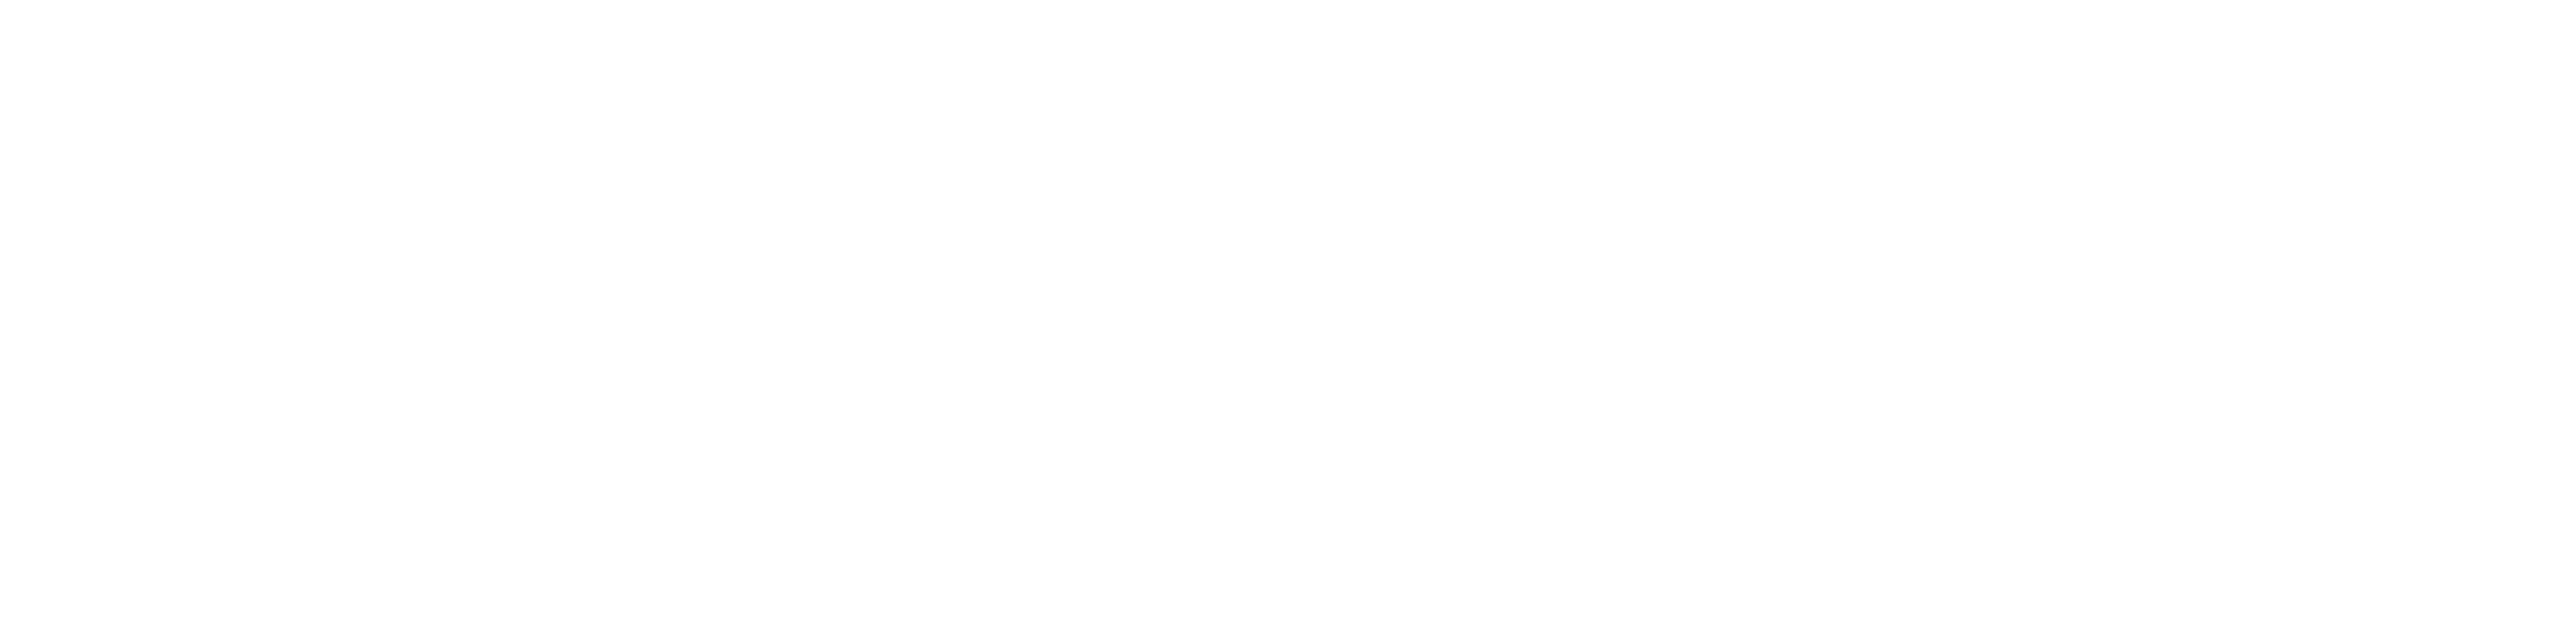

2020-06-02 23:12:29,053 logger INFO loss 2.09, 3D Dis:  9.71mm, shiftDiff: 65195.542969, MemUsed:50.86
2020-06-02 23:12:38,022 logger INFO loss 2.07, 3D Dis:  9.66mm, shiftDiff: 64870.136719, MemUsed:50.86
2020-06-02 23:12:47,173 logger INFO loss 2.05, 3D Dis:  9.61mm, shiftDiff: 64545.523438, MemUsed:50.86
2020-06-02 23:12:56,288 logger INFO loss 2.04, 3D Dis:  9.56mm, shiftDiff: 64221.820312, MemUsed:50.86
2020-06-02 23:13:05,469 logger INFO loss 2.02, 3D Dis:  9.51mm, shiftDiff: 63898.546875, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


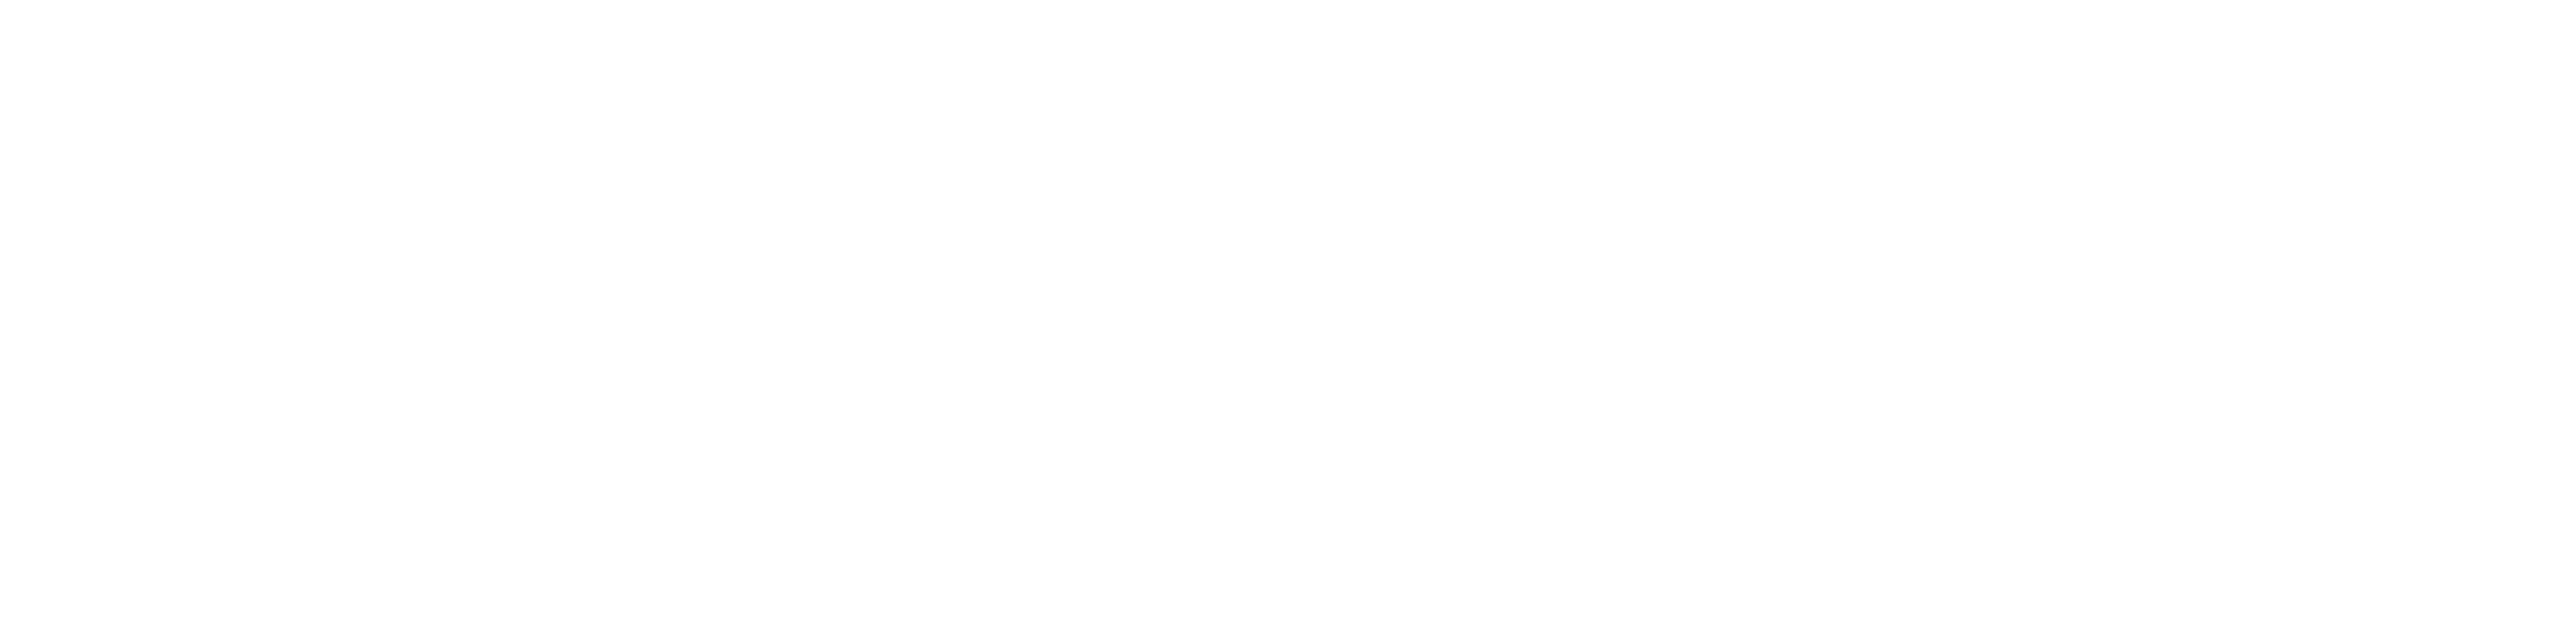

2020-06-02 23:13:33,979 logger INFO loss 2.00, 3D Dis:  9.47mm, shiftDiff: 63575.164062, MemUsed:50.86
2020-06-02 23:13:43,241 logger INFO loss 1.98, 3D Dis:  9.42mm, shiftDiff: 63251.671875, MemUsed:50.86
2020-06-02 23:13:52,327 logger INFO loss 1.96, 3D Dis:  9.37mm, shiftDiff: 62927.929688, MemUsed:50.86
2020-06-02 23:14:01,471 logger INFO loss 1.94, 3D Dis:  9.32mm, shiftDiff: 62603.730469, MemUsed:50.86
2020-06-02 23:14:10,594 logger INFO loss 1.92, 3D Dis:  9.27mm, shiftDiff: 62278.500000, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


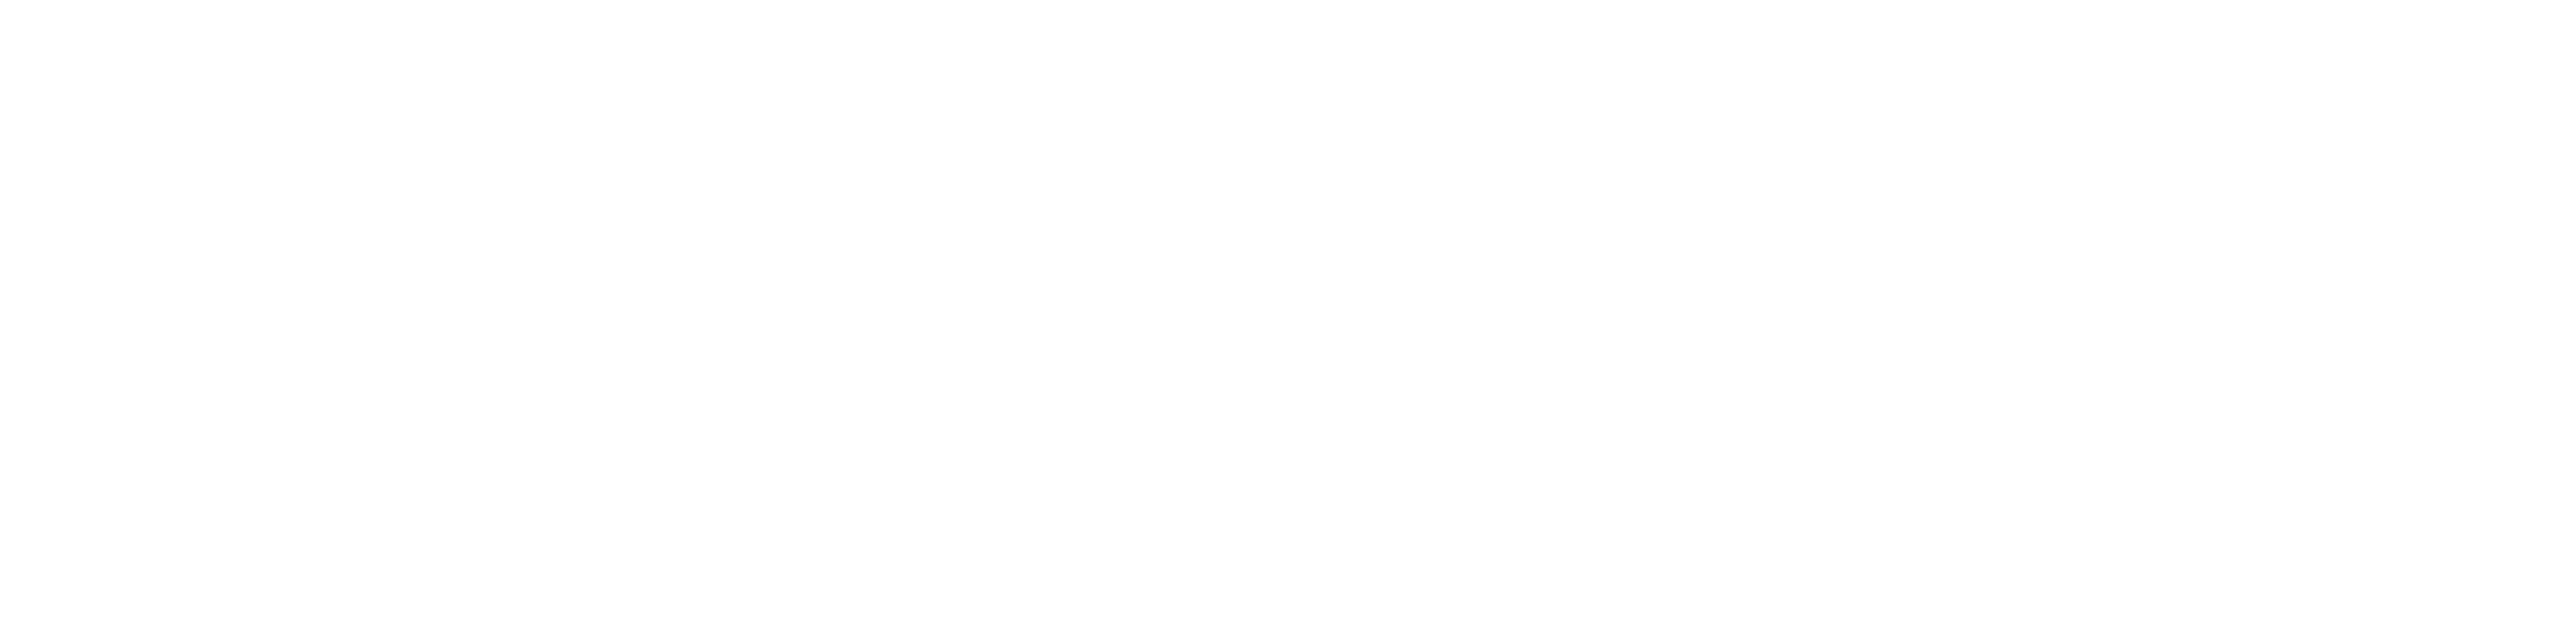

2020-06-02 23:14:39,548 logger INFO loss 1.90, 3D Dis:  9.23mm, shiftDiff: 61952.101562, MemUsed:50.86
2020-06-02 23:14:48,502 logger INFO loss 1.88, 3D Dis:  9.18mm, shiftDiff: 61624.710938, MemUsed:50.86
2020-06-02 23:14:57,639 logger INFO loss 1.86, 3D Dis:  9.13mm, shiftDiff: 61296.445312, MemUsed:50.86
2020-06-02 23:15:06,710 logger INFO loss 1.85, 3D Dis:  9.08mm, shiftDiff: 60967.351562, MemUsed:50.86
2020-06-02 23:15:15,873 logger INFO loss 1.83, 3D Dis:  9.03mm, shiftDiff: 60637.429688, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


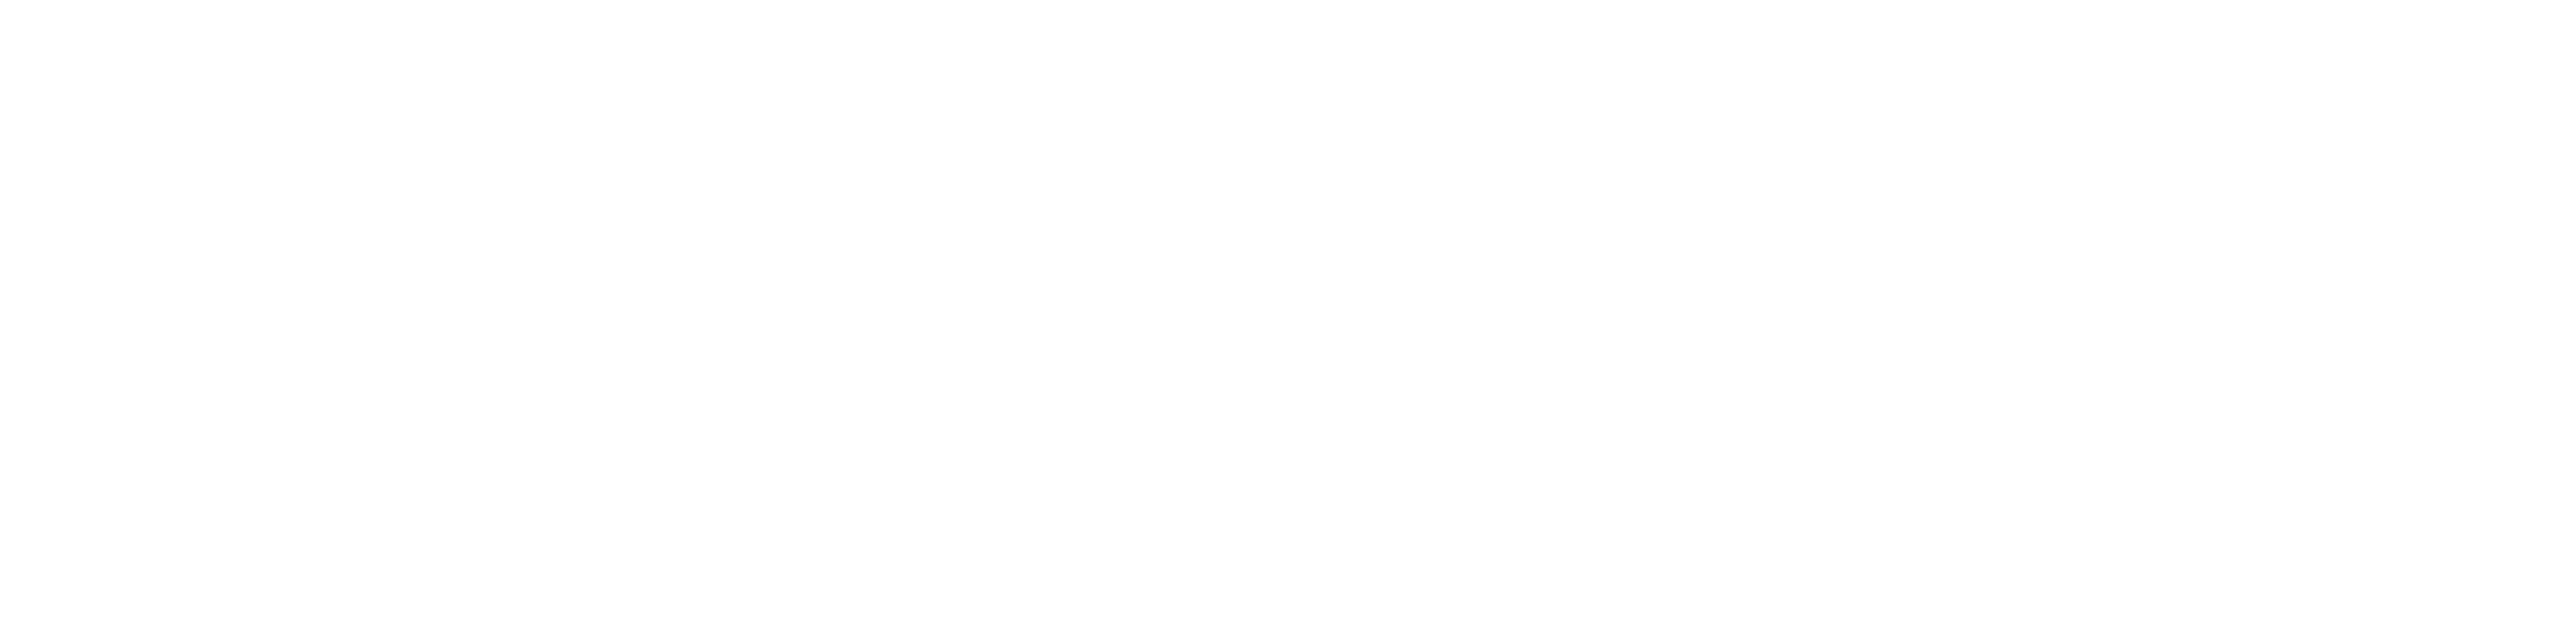

2020-06-02 23:15:44,472 logger INFO loss 1.81, 3D Dis:  8.98mm, shiftDiff: 60306.925781, MemUsed:50.86
2020-06-02 23:15:53,695 logger INFO loss 1.79, 3D Dis:  8.93mm, shiftDiff: 59975.984375, MemUsed:50.86
2020-06-02 23:16:02,737 logger INFO loss 1.77, 3D Dis:  8.89mm, shiftDiff: 59644.781250, MemUsed:50.86
2020-06-02 23:16:11,894 logger INFO loss 1.75, 3D Dis:  8.84mm, shiftDiff: 59313.332031, MemUsed:50.86
2020-06-02 23:16:21,107 logger INFO loss 1.73, 3D Dis:  8.79mm, shiftDiff: 58982.007812, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


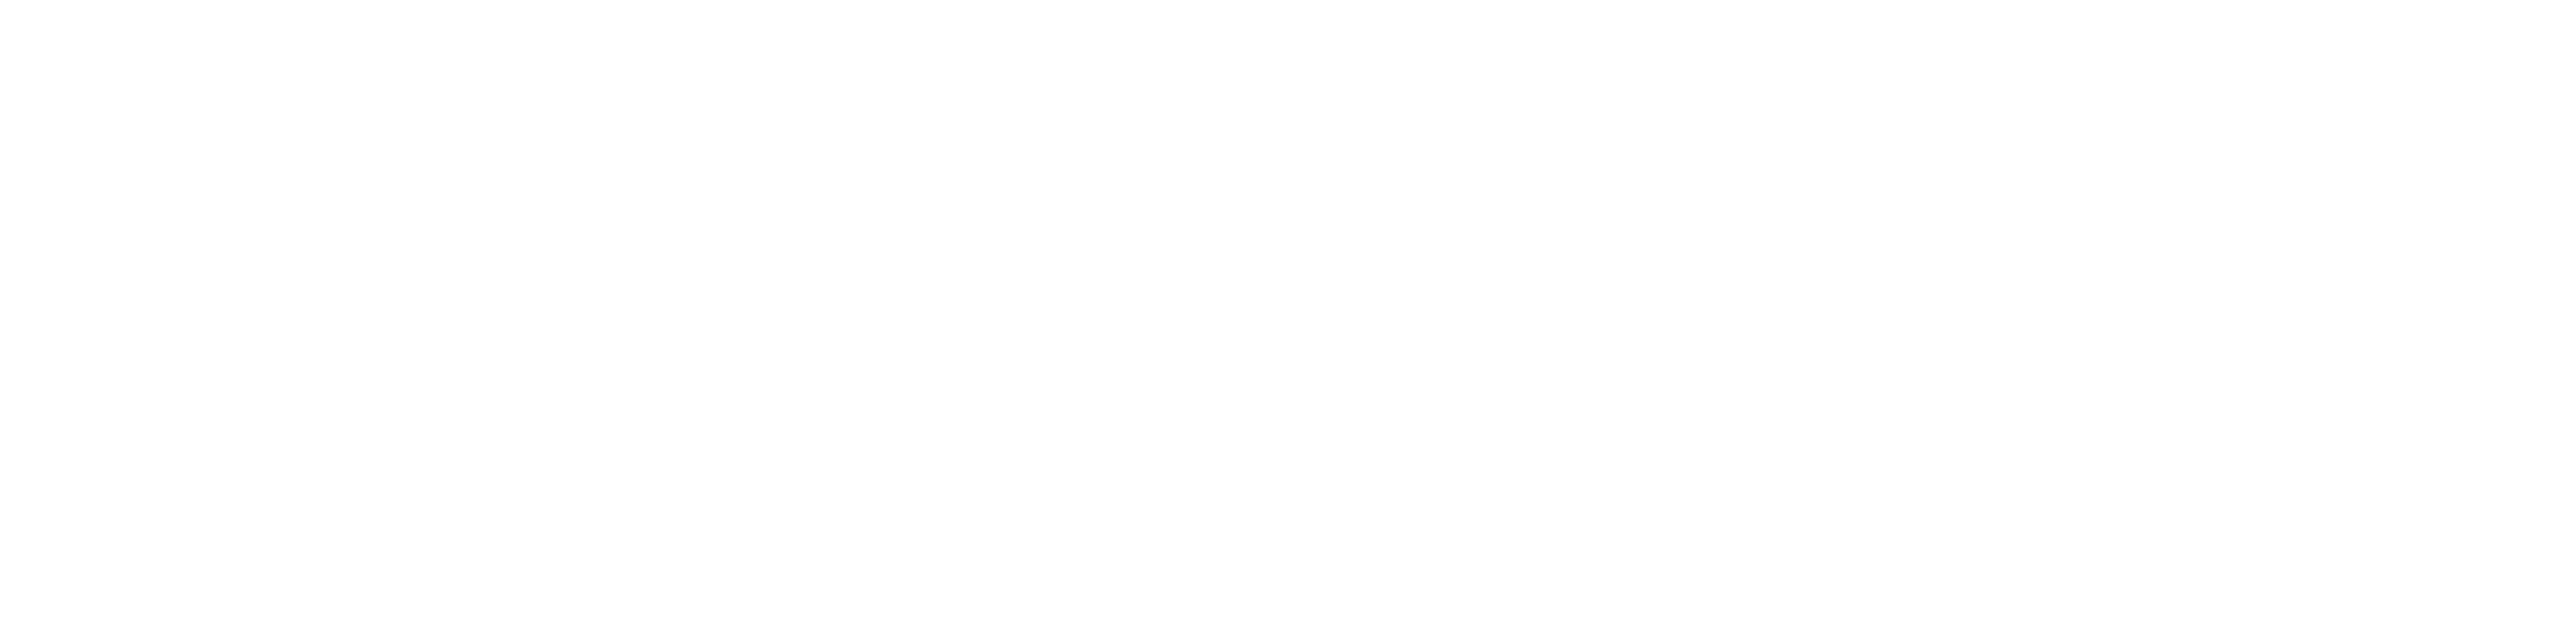

2020-06-02 23:16:49,769 logger INFO loss 1.72, 3D Dis:  8.74mm, shiftDiff: 58651.152344, MemUsed:50.86
2020-06-02 23:16:58,720 logger INFO loss 1.70, 3D Dis:  8.69mm, shiftDiff: 58320.894531, MemUsed:50.86
2020-06-02 23:17:07,778 logger INFO loss 1.68, 3D Dis:  8.64mm, shiftDiff: 57991.585938, MemUsed:50.86
2020-06-02 23:17:16,875 logger INFO loss 1.66, 3D Dis:  8.59mm, shiftDiff: 57662.937500, MemUsed:50.86
2020-06-02 23:17:25,968 logger INFO loss 1.64, 3D Dis:  8.54mm, shiftDiff: 57334.554688, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


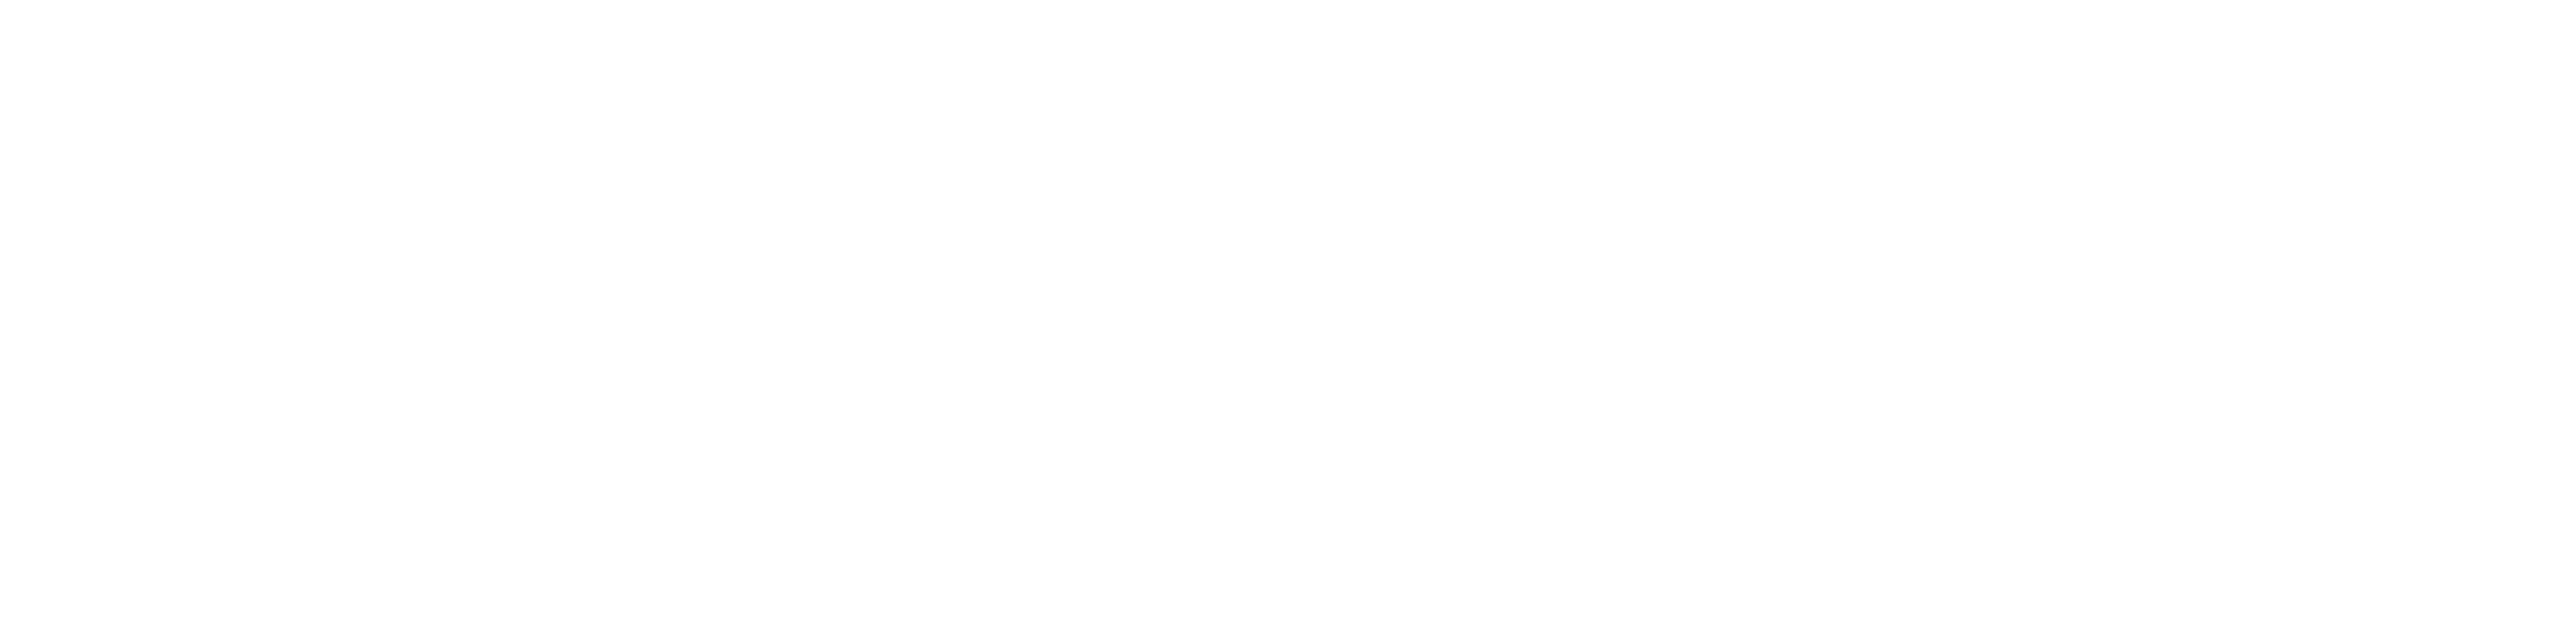

2020-06-02 23:17:54,531 logger INFO loss 1.62, 3D Dis:  8.49mm, shiftDiff: 57005.937500, MemUsed:50.86
2020-06-02 23:18:03,437 logger INFO loss 1.61, 3D Dis:  8.45mm, shiftDiff: 56676.792969, MemUsed:50.86
2020-06-02 23:18:12,497 logger INFO loss 1.59, 3D Dis:  8.40mm, shiftDiff: 56346.726562, MemUsed:50.86
2020-06-02 23:18:21,542 logger INFO loss 1.57, 3D Dis:  8.35mm, shiftDiff: 56015.925781, MemUsed:50.86
2020-06-02 23:18:30,576 logger INFO loss 1.55, 3D Dis:  8.30mm, shiftDiff: 55684.617188, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


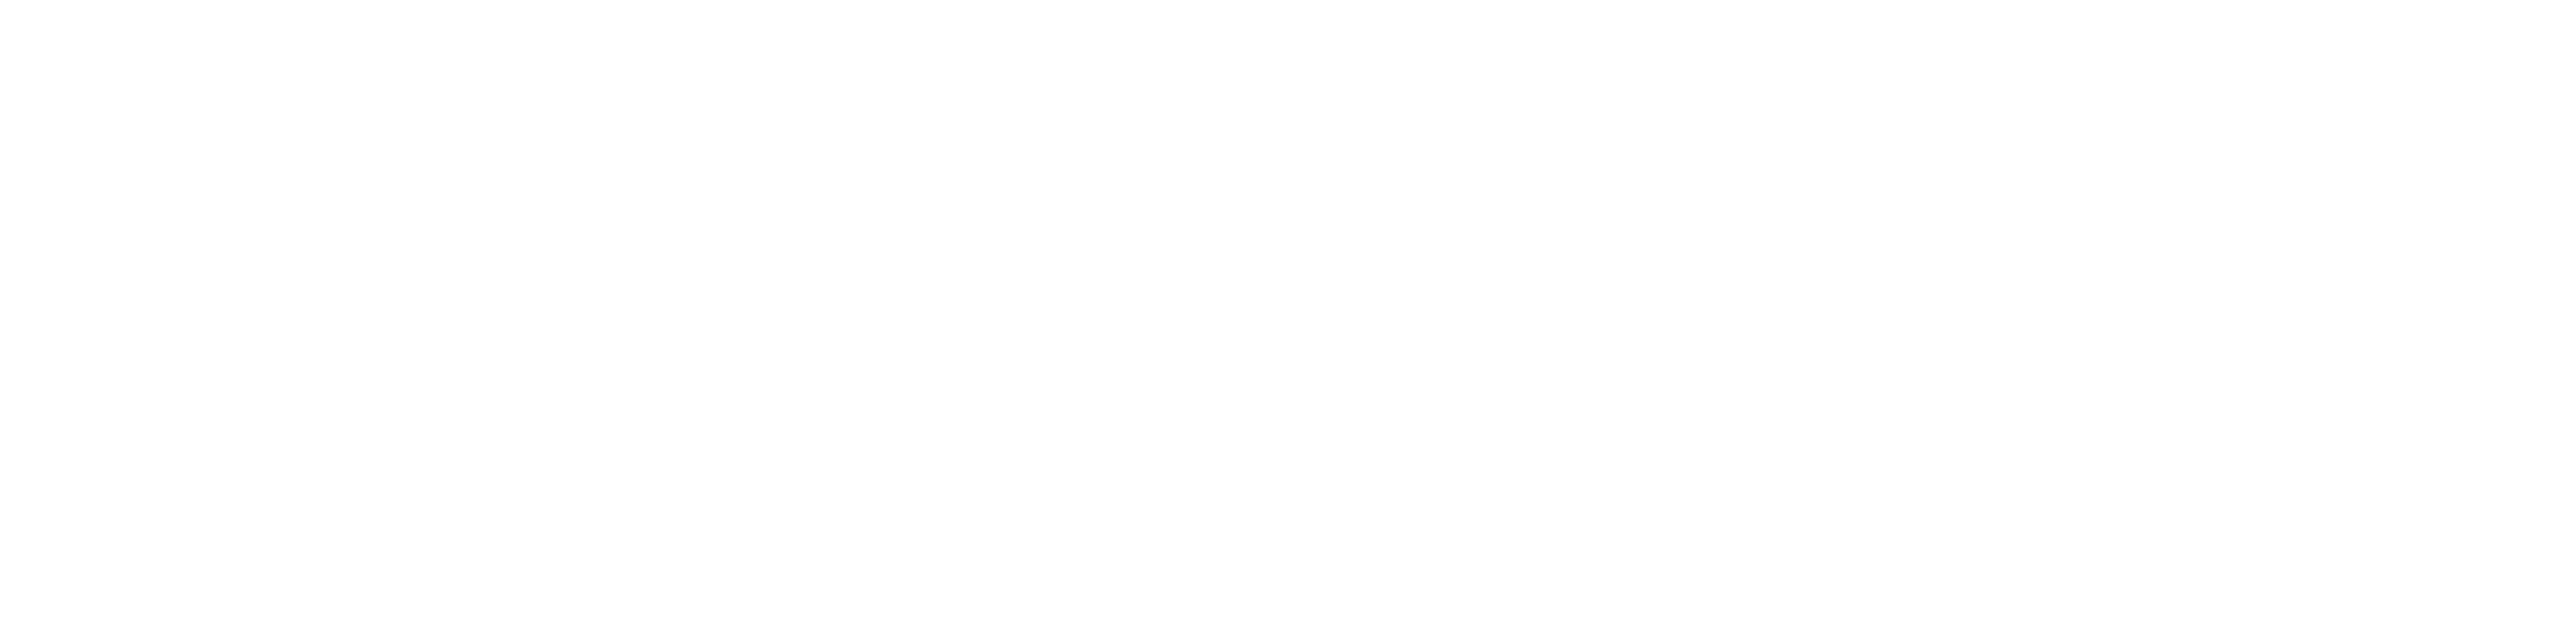

2020-06-02 23:18:59,193 logger INFO loss 1.53, 3D Dis:  8.25mm, shiftDiff: 55352.941406, MemUsed:50.86
2020-06-02 23:19:08,158 logger INFO loss 1.51, 3D Dis:  8.20mm, shiftDiff: 55021.132812, MemUsed:50.86
2020-06-02 23:19:17,171 logger INFO loss 1.49, 3D Dis:  8.15mm, shiftDiff: 54689.093750, MemUsed:50.86
2020-06-02 23:19:26,324 logger INFO loss 1.47, 3D Dis:  8.10mm, shiftDiff: 54356.648438, MemUsed:50.86
2020-06-02 23:19:35,388 logger INFO loss 1.46, 3D Dis:  8.05mm, shiftDiff: 54023.277344, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


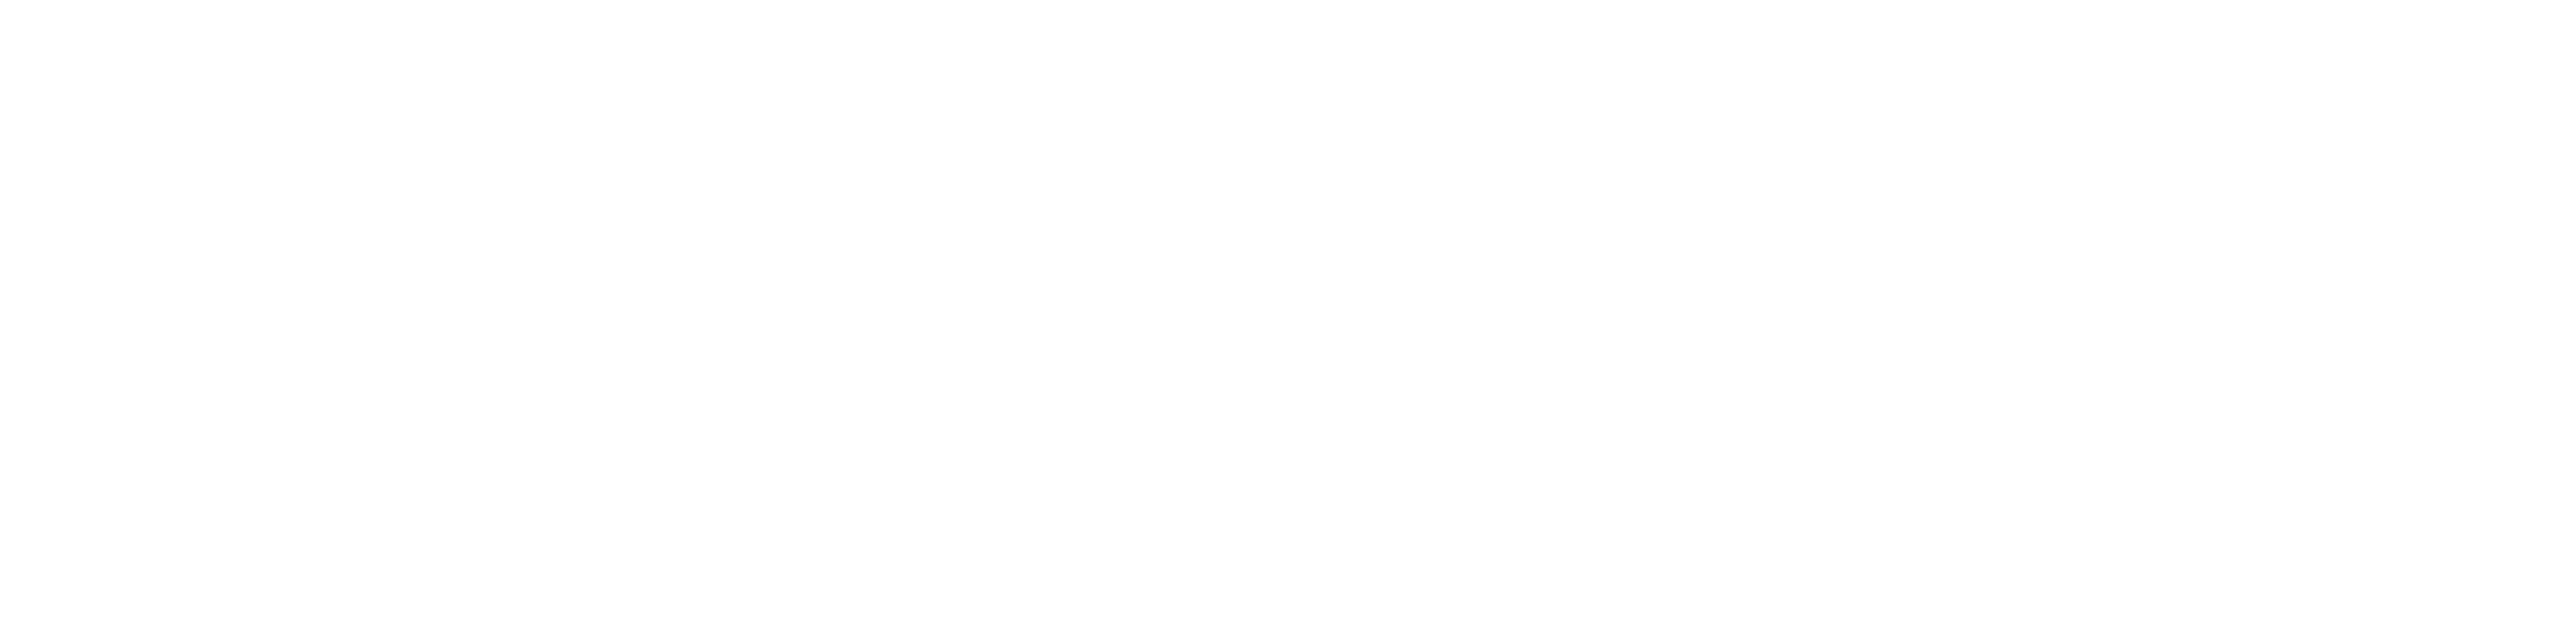

2020-06-02 23:20:03,985 logger INFO loss 1.44, 3D Dis:  8.00mm, shiftDiff: 53688.734375, MemUsed:50.86
2020-06-02 23:20:12,941 logger INFO loss 1.42, 3D Dis:  7.95mm, shiftDiff: 53353.015625, MemUsed:50.86
2020-06-02 23:20:21,988 logger INFO loss 1.40, 3D Dis:  7.90mm, shiftDiff: 53016.125000, MemUsed:50.86
2020-06-02 23:20:31,007 logger INFO loss 1.38, 3D Dis:  7.85mm, shiftDiff: 52678.500000, MemUsed:50.86
2020-06-02 23:20:40,110 logger INFO loss 1.36, 3D Dis:  7.80mm, shiftDiff: 52340.757812, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


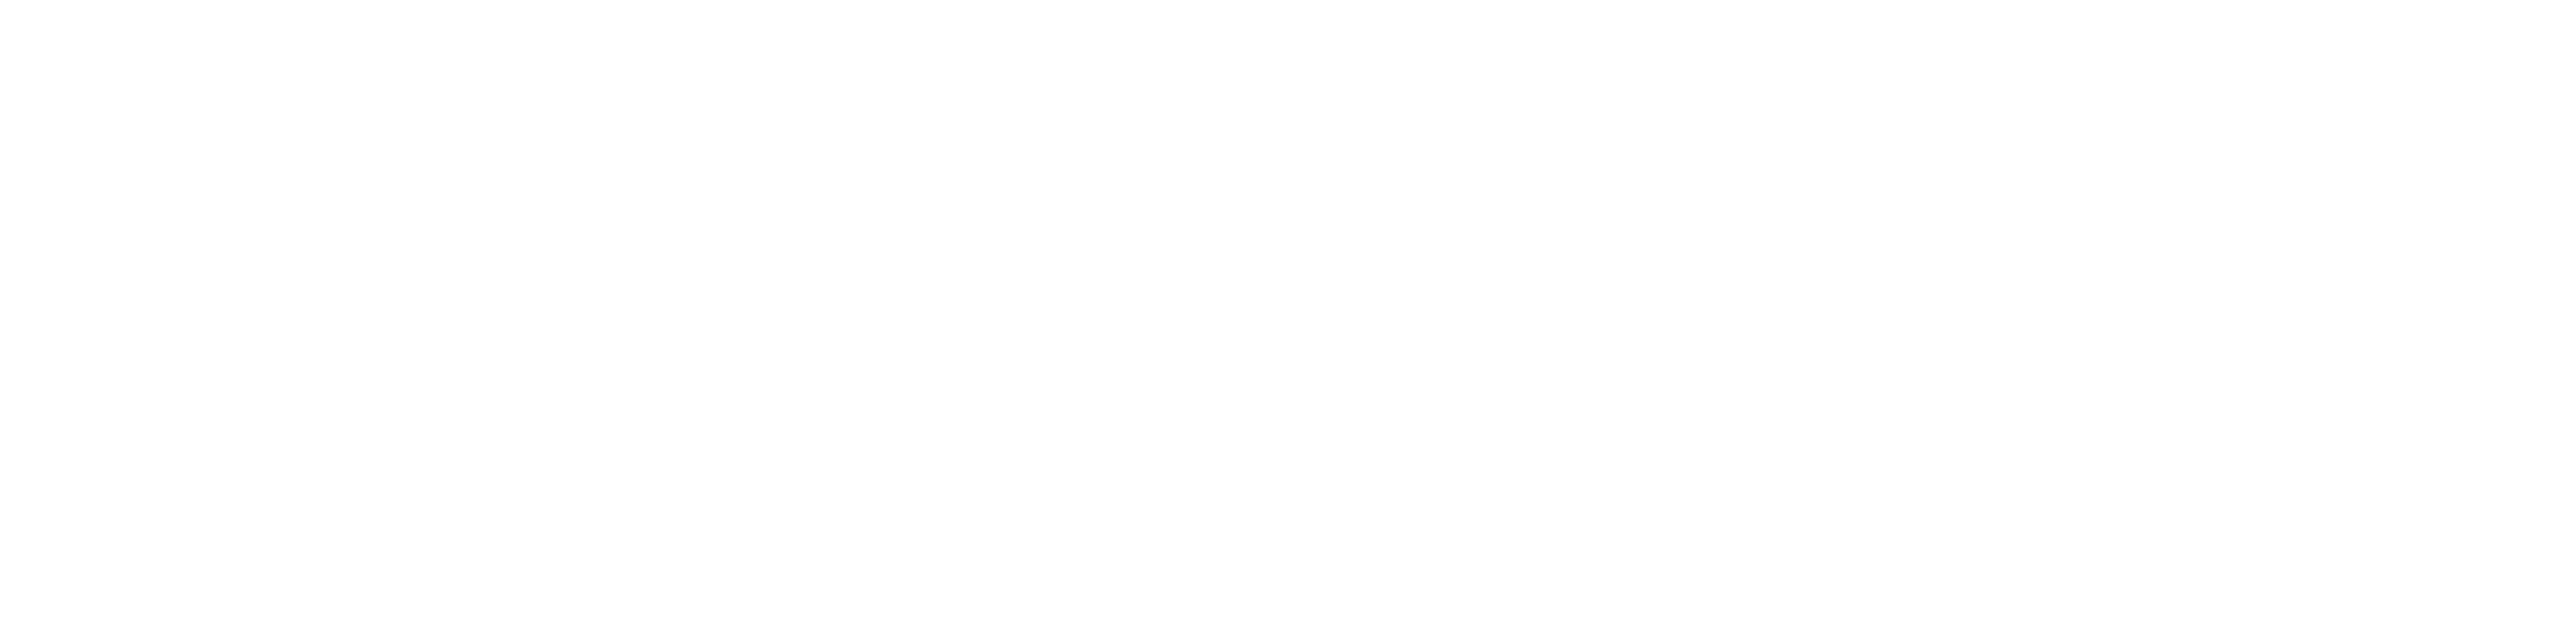

2020-06-02 23:21:08,617 logger INFO loss 1.34, 3D Dis:  7.75mm, shiftDiff: 52003.109375, MemUsed:50.86
2020-06-02 23:21:17,672 logger INFO loss 1.32, 3D Dis:  7.70mm, shiftDiff: 51665.746094, MemUsed:50.86
2020-06-02 23:21:26,714 logger INFO loss 1.30, 3D Dis:  7.65mm, shiftDiff: 51329.070312, MemUsed:50.86
2020-06-02 23:21:35,830 logger INFO loss 1.29, 3D Dis:  7.60mm, shiftDiff: 50993.531250, MemUsed:50.86
2020-06-02 23:21:44,918 logger INFO loss 1.27, 3D Dis:  7.55mm, shiftDiff: 50659.625000, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


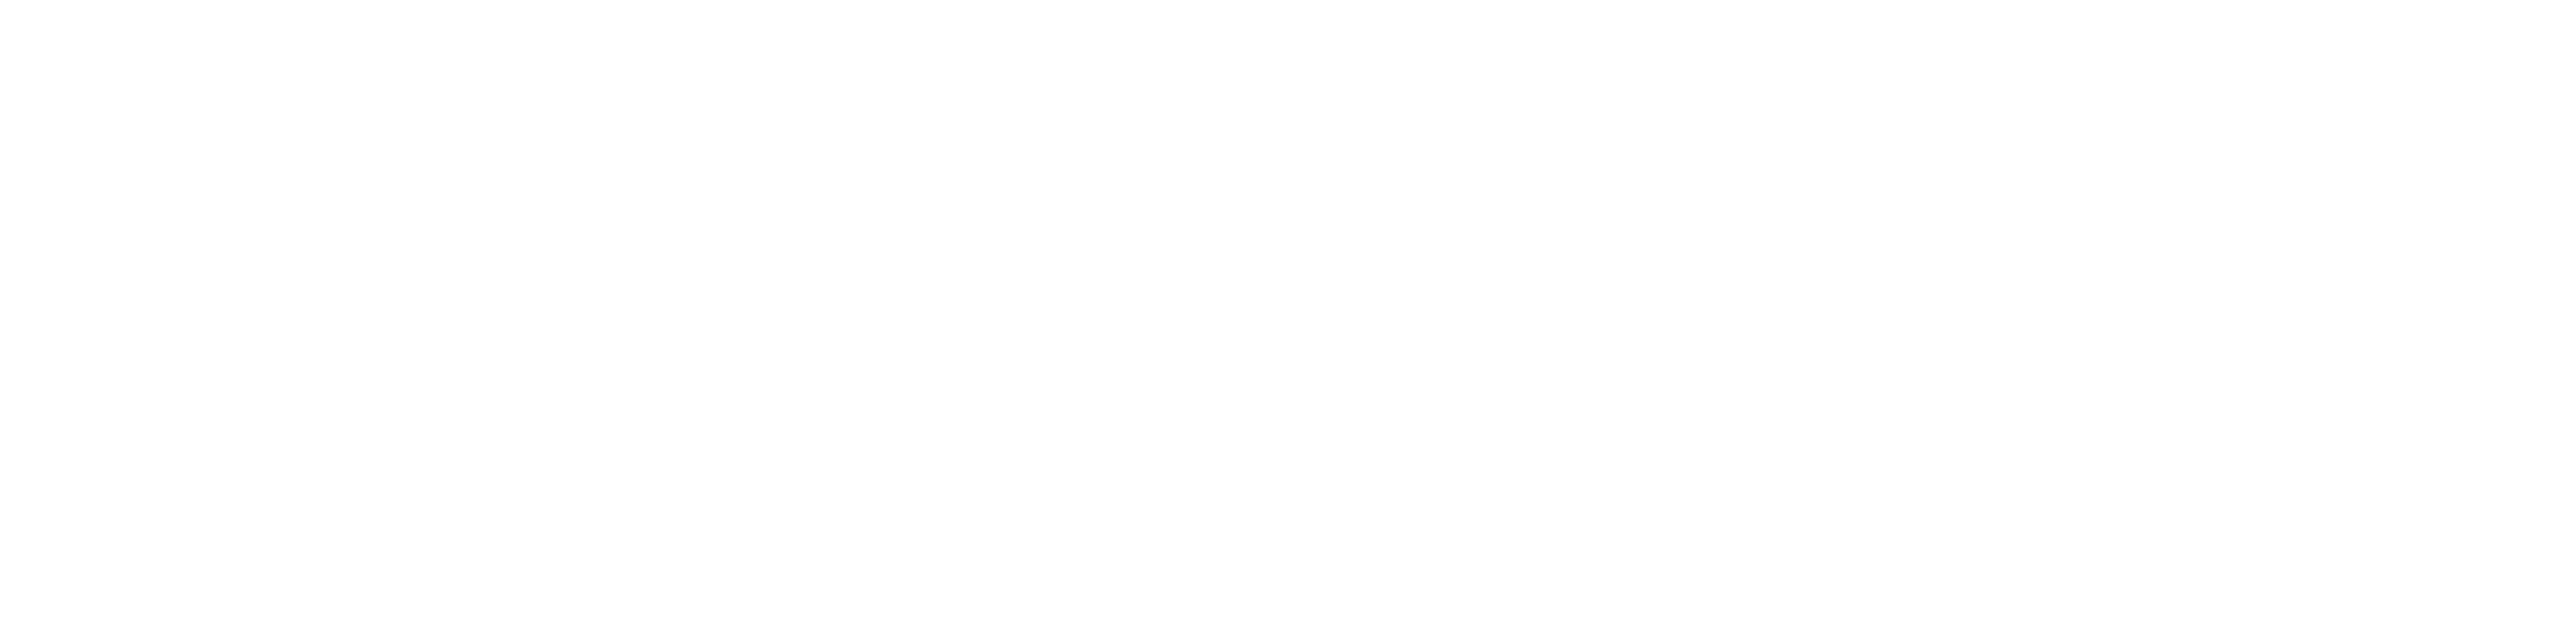

2020-06-02 23:22:13,555 logger INFO loss 1.25, 3D Dis:  7.51mm, shiftDiff: 50327.414062, MemUsed:50.86
2020-06-02 23:22:22,502 logger INFO loss 1.23, 3D Dis:  7.46mm, shiftDiff: 49996.914062, MemUsed:50.86
2020-06-02 23:22:31,565 logger INFO loss 1.21, 3D Dis:  7.41mm, shiftDiff: 49668.011719, MemUsed:50.86
2020-06-02 23:22:40,720 logger INFO loss 1.19, 3D Dis:  7.36mm, shiftDiff: 49340.453125, MemUsed:50.86
2020-06-02 23:22:49,889 logger INFO loss 1.17, 3D Dis:  7.31mm, shiftDiff: 49014.203125, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


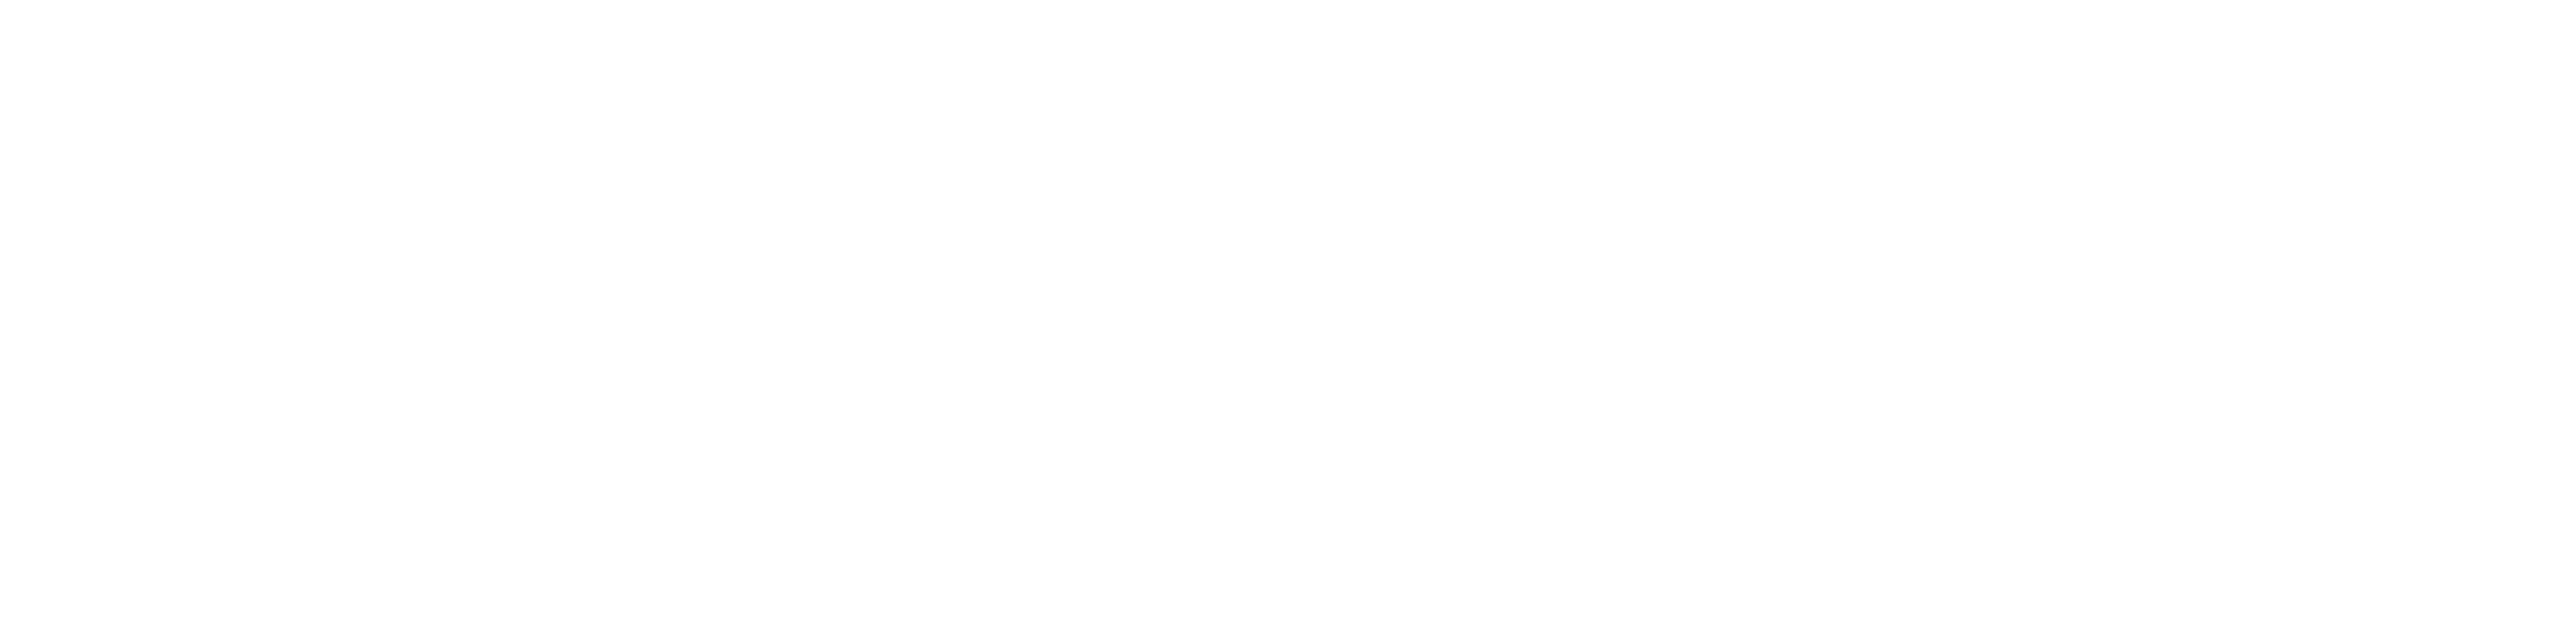

2020-06-02 23:23:18,359 logger INFO loss 1.16, 3D Dis:  7.26mm, shiftDiff: 48689.195312, MemUsed:50.86
2020-06-02 23:23:27,399 logger INFO loss 1.14, 3D Dis:  7.21mm, shiftDiff: 48365.550781, MemUsed:50.86
2020-06-02 23:23:36,440 logger INFO loss 1.12, 3D Dis:  7.17mm, shiftDiff: 48043.054688, MemUsed:50.86
2020-06-02 23:23:45,534 logger INFO loss 1.10, 3D Dis:  7.12mm, shiftDiff: 47721.195312, MemUsed:50.86
2020-06-02 23:23:54,653 logger INFO loss 1.08, 3D Dis:  7.07mm, shiftDiff: 47399.738281, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


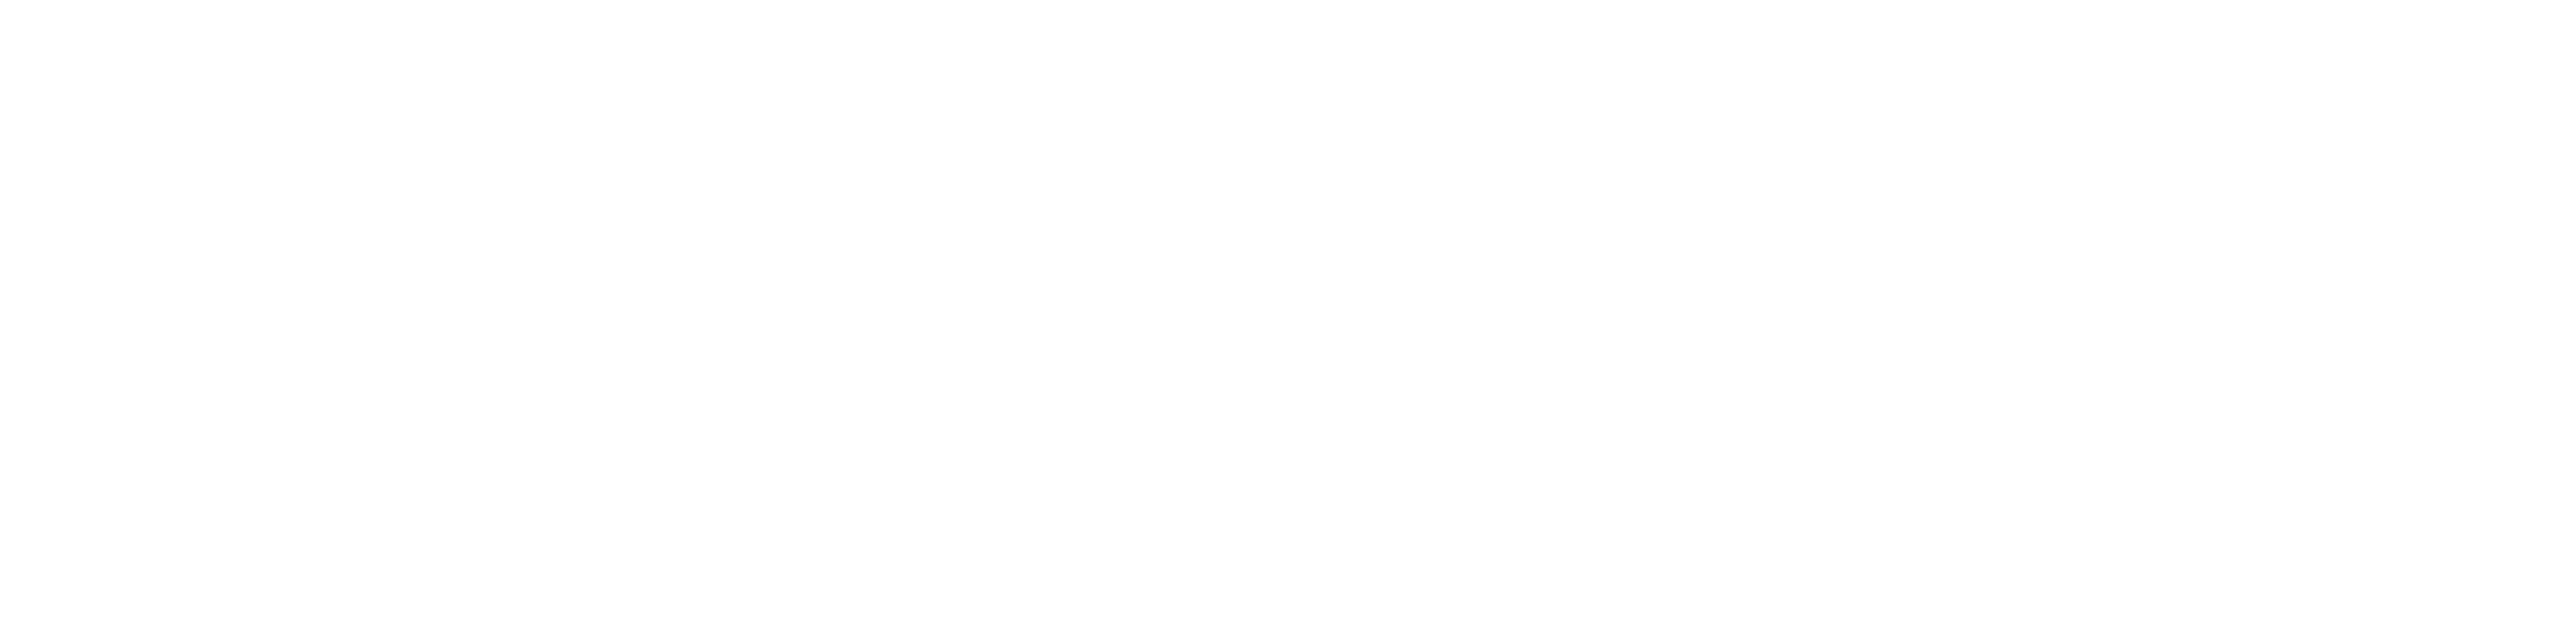

2020-06-02 23:24:23,246 logger INFO loss 1.06, 3D Dis:  7.02mm, shiftDiff: 47078.687500, MemUsed:50.86
2020-06-02 23:24:32,213 logger INFO loss 1.04, 3D Dis:  6.97mm, shiftDiff: 46757.875000, MemUsed:50.86
2020-06-02 23:24:41,333 logger INFO loss 1.02, 3D Dis:  6.93mm, shiftDiff: 46436.789062, MemUsed:50.86
2020-06-02 23:24:50,389 logger INFO loss 1.01, 3D Dis:  6.88mm, shiftDiff: 46115.382812, MemUsed:50.86
2020-06-02 23:24:59,493 logger INFO loss 0.99, 3D Dis:  6.83mm, shiftDiff: 45793.648438, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


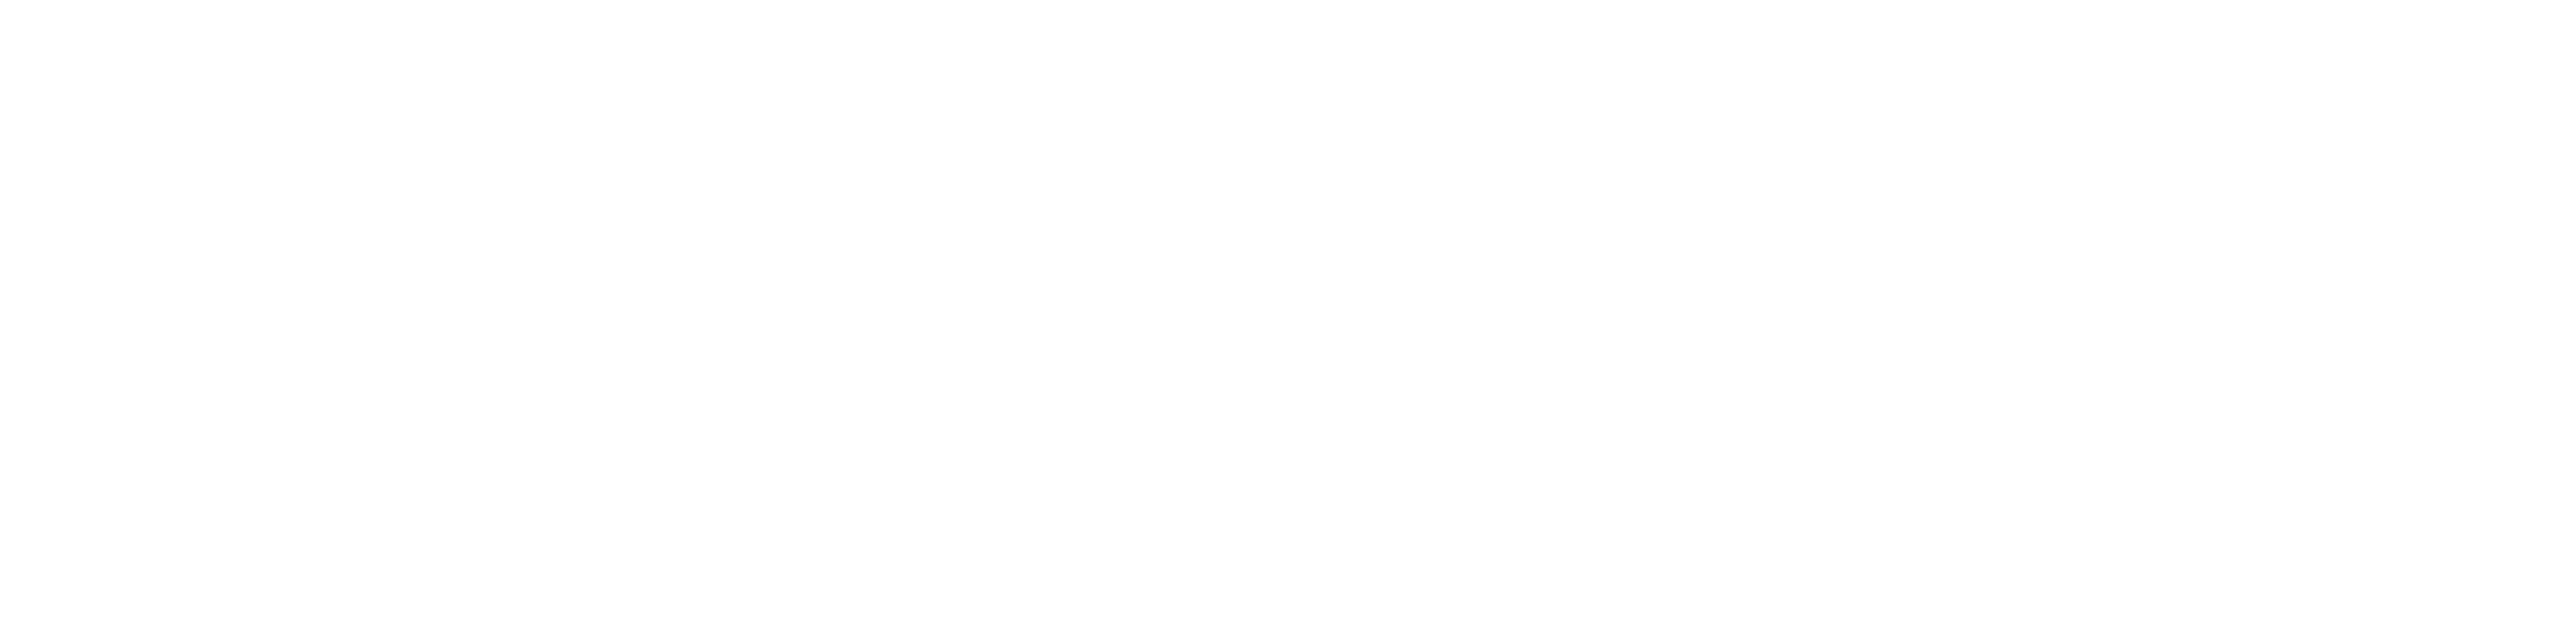

2020-06-02 23:25:28,036 logger INFO loss 0.97, 3D Dis:  6.78mm, shiftDiff: 45471.742188, MemUsed:50.86
2020-06-02 23:25:36,988 logger INFO loss 0.95, 3D Dis:  6.74mm, shiftDiff: 45149.906250, MemUsed:50.86
2020-06-02 23:25:46,065 logger INFO loss 0.93, 3D Dis:  6.69mm, shiftDiff: 44828.312500, MemUsed:50.86
2020-06-02 23:25:55,125 logger INFO loss 0.91, 3D Dis:  6.64mm, shiftDiff: 44506.906250, MemUsed:50.86
2020-06-02 23:26:04,195 logger INFO loss 0.89, 3D Dis:  6.59mm, shiftDiff: 44185.804688, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


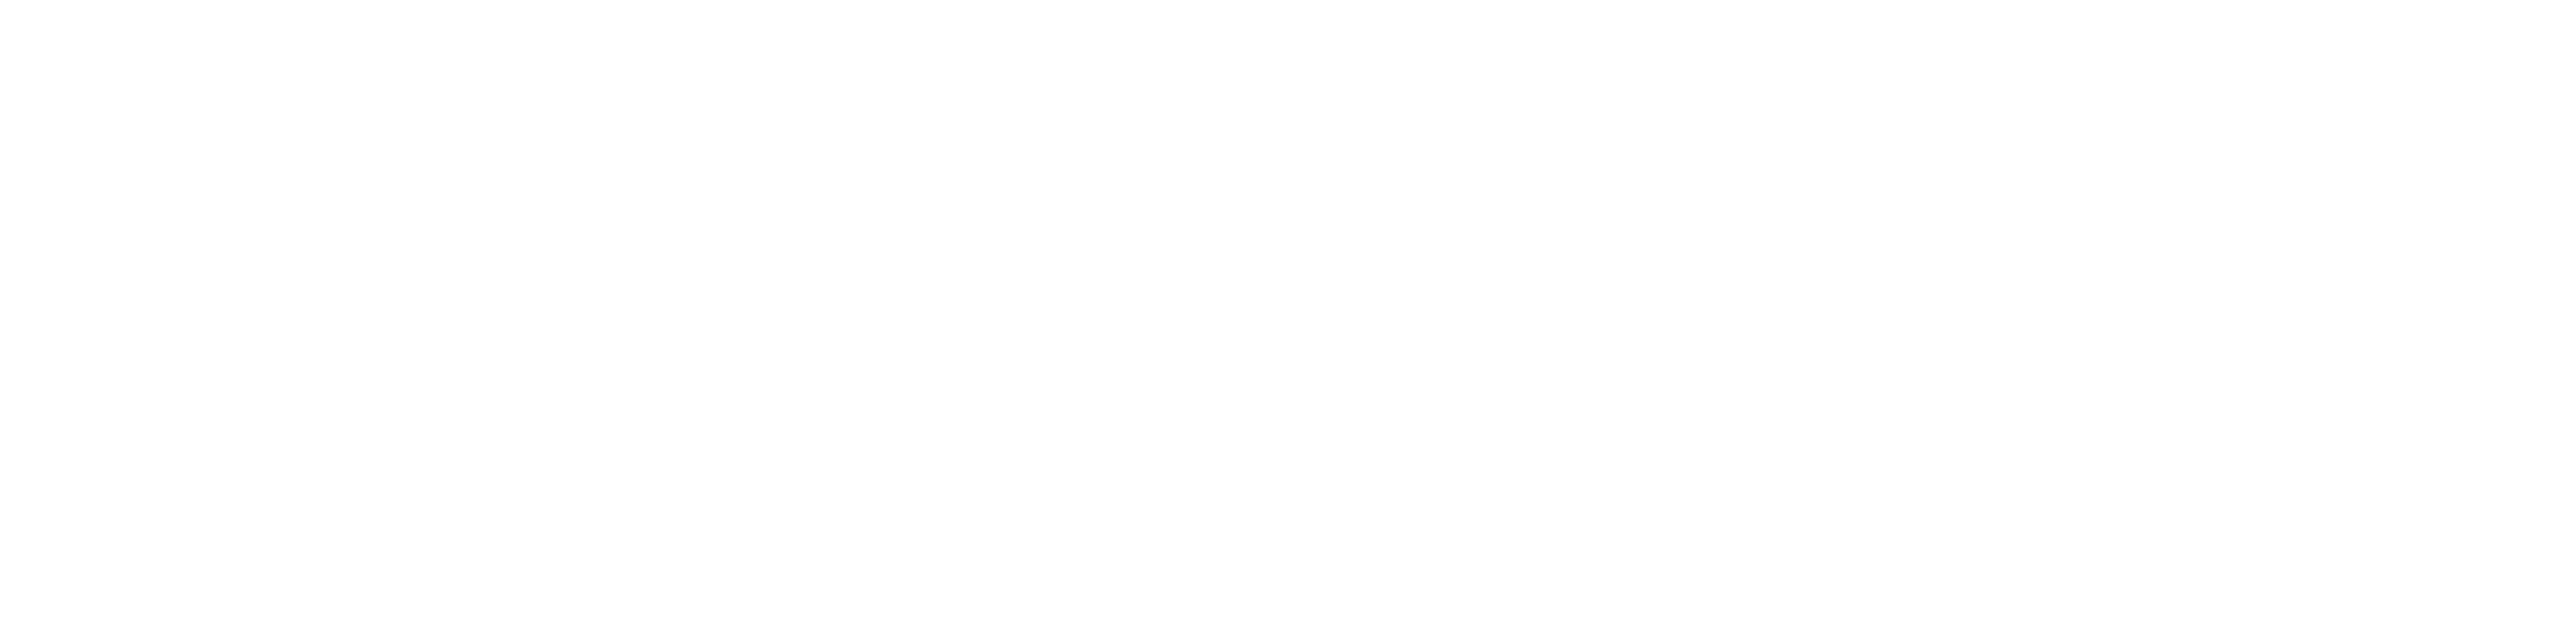

2020-06-02 23:26:32,789 logger INFO loss 0.87, 3D Dis:  6.55mm, shiftDiff: 43865.109375, MemUsed:50.86
2020-06-02 23:26:41,800 logger INFO loss 0.85, 3D Dis:  6.50mm, shiftDiff: 43545.125000, MemUsed:50.86
2020-06-02 23:26:50,810 logger INFO loss 0.83, 3D Dis:  6.45mm, shiftDiff: 43226.023438, MemUsed:50.86
2020-06-02 23:26:59,914 logger INFO loss 0.81, 3D Dis:  6.40mm, shiftDiff: 42908.191406, MemUsed:50.86
2020-06-02 23:27:08,963 logger INFO loss 0.80, 3D Dis:  6.36mm, shiftDiff: 42591.464844, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


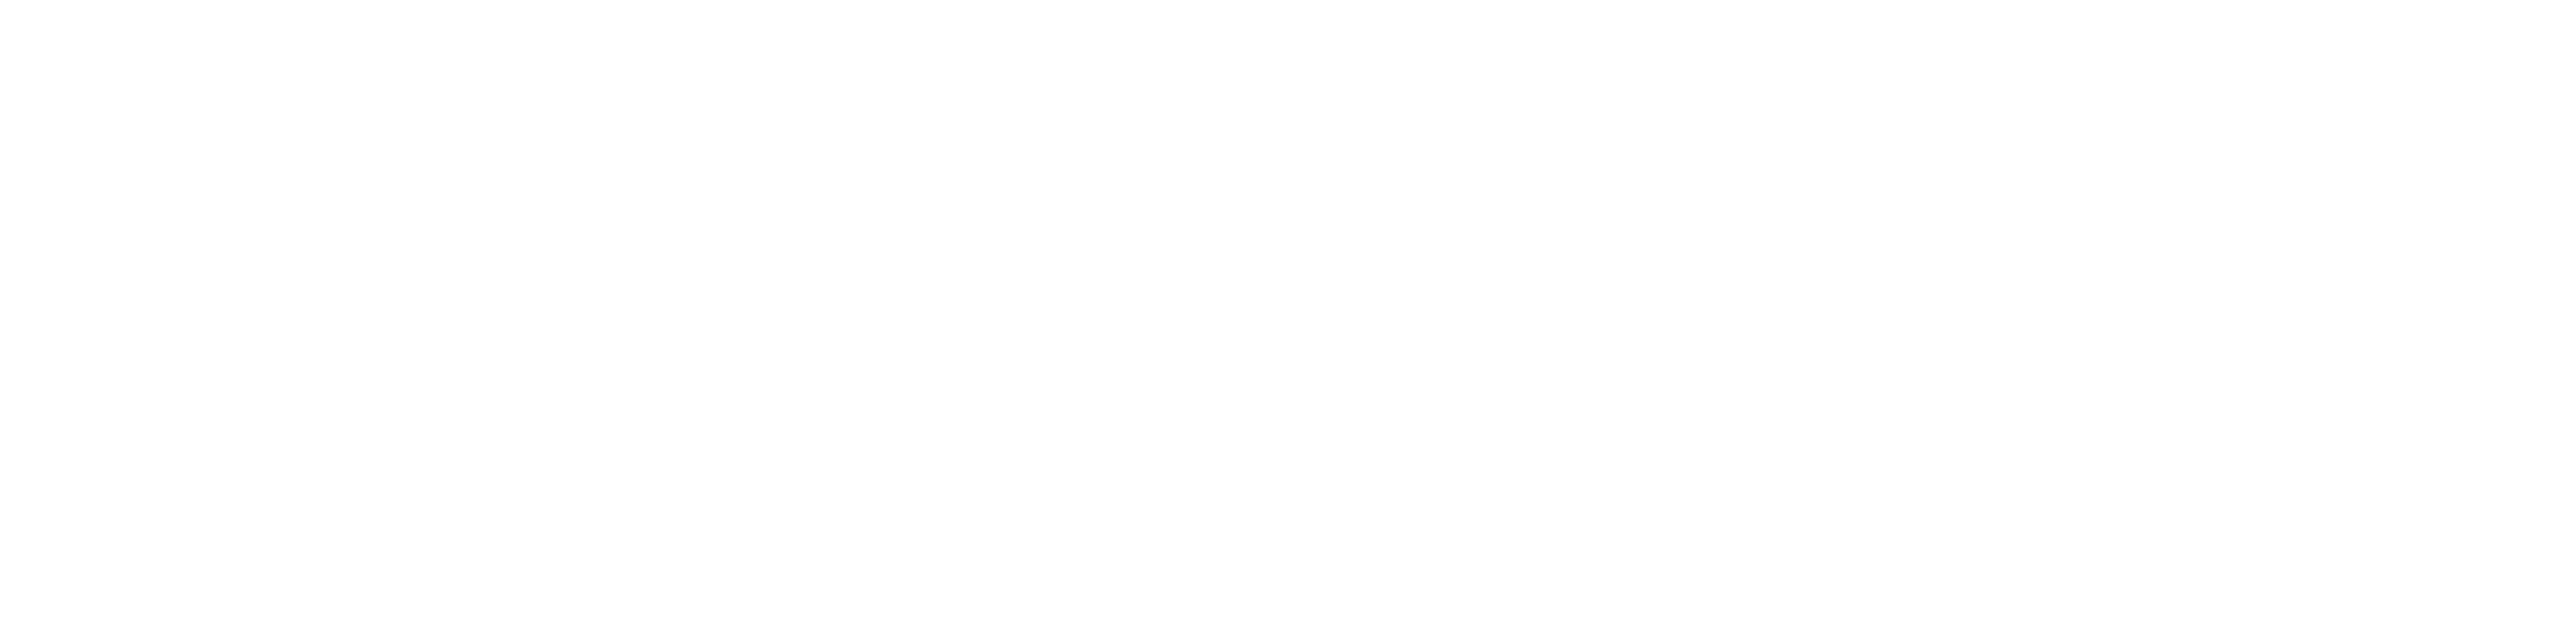

2020-06-02 23:27:37,520 logger INFO loss 0.78, 3D Dis:  6.31mm, shiftDiff: 42275.664062, MemUsed:50.86
2020-06-02 23:27:46,487 logger INFO loss 0.76, 3D Dis:  6.26mm, shiftDiff: 41960.820312, MemUsed:50.86
2020-06-02 23:27:55,554 logger INFO loss 0.74, 3D Dis:  6.22mm, shiftDiff: 41647.148438, MemUsed:50.86
2020-06-02 23:28:04,671 logger INFO loss 0.72, 3D Dis:  6.17mm, shiftDiff: 41334.742188, MemUsed:50.86
2020-06-02 23:28:13,772 logger INFO loss 0.70, 3D Dis:  6.12mm, shiftDiff: 41023.531250, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


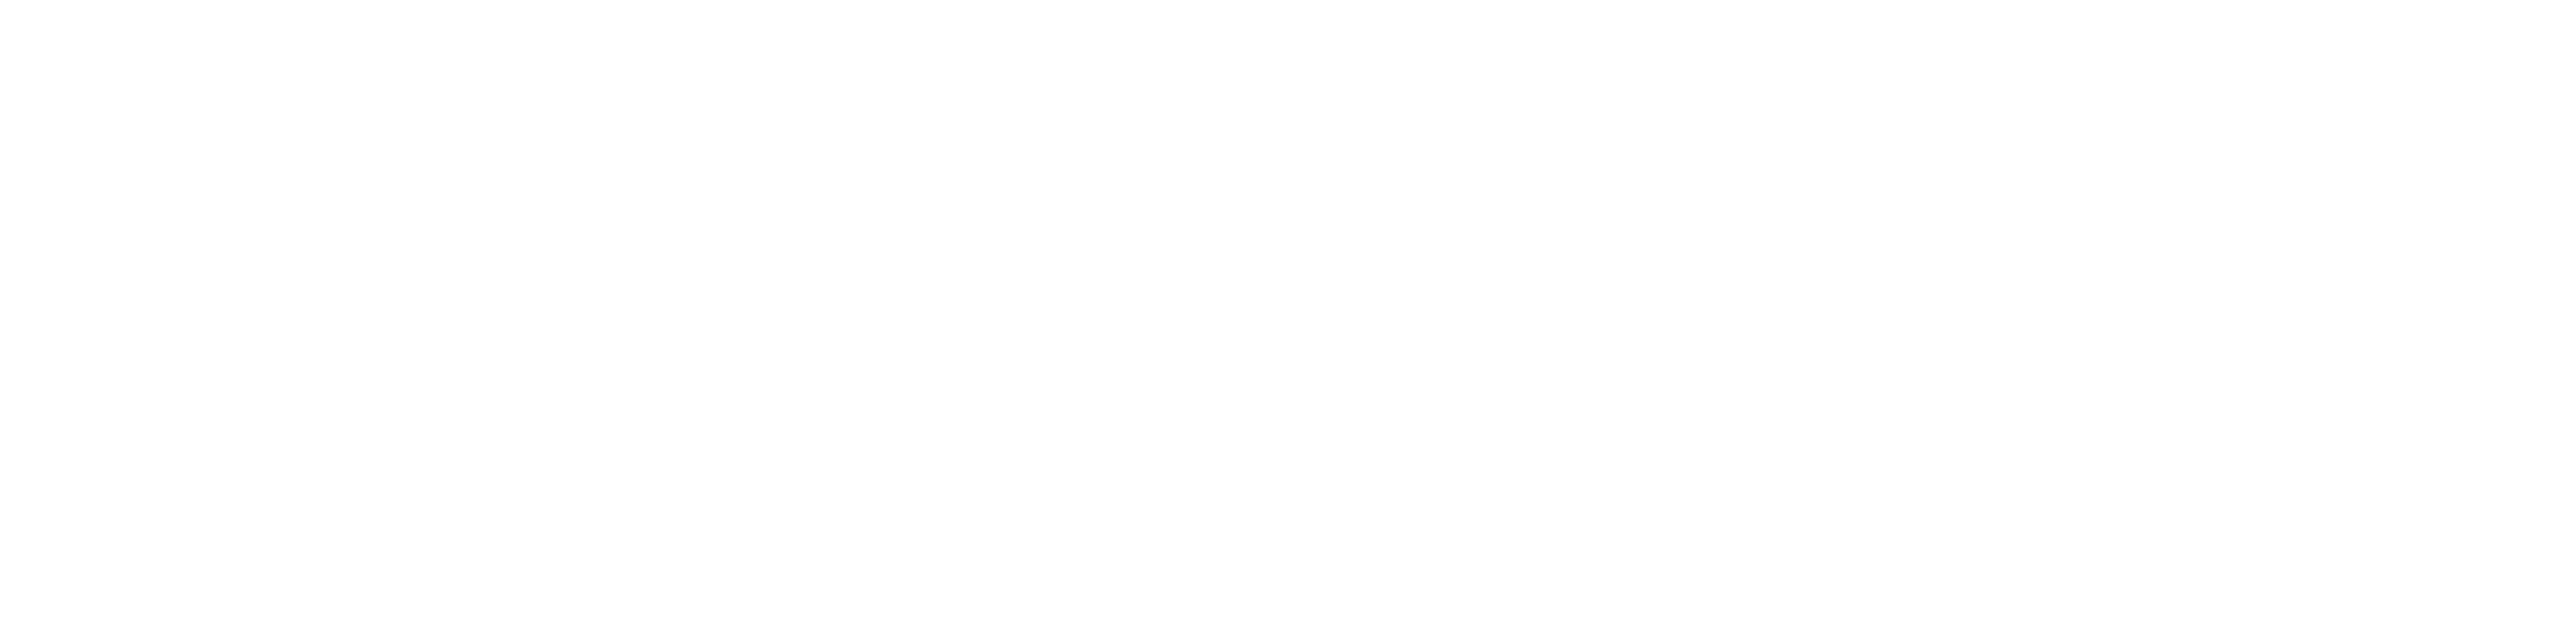

2020-06-02 23:28:42,252 logger INFO loss 0.68, 3D Dis:  6.08mm, shiftDiff: 40713.156250, MemUsed:50.86
2020-06-02 23:28:51,308 logger INFO loss 0.66, 3D Dis:  6.03mm, shiftDiff: 40404.207031, MemUsed:50.86
2020-06-02 23:29:00,370 logger INFO loss 0.64, 3D Dis:  5.99mm, shiftDiff: 40096.421875, MemUsed:50.86
2020-06-02 23:29:09,462 logger INFO loss 0.62, 3D Dis:  5.94mm, shiftDiff: 39789.796875, MemUsed:50.86
2020-06-02 23:29:18,529 logger INFO loss 0.61, 3D Dis:  5.89mm, shiftDiff: 39484.156250, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


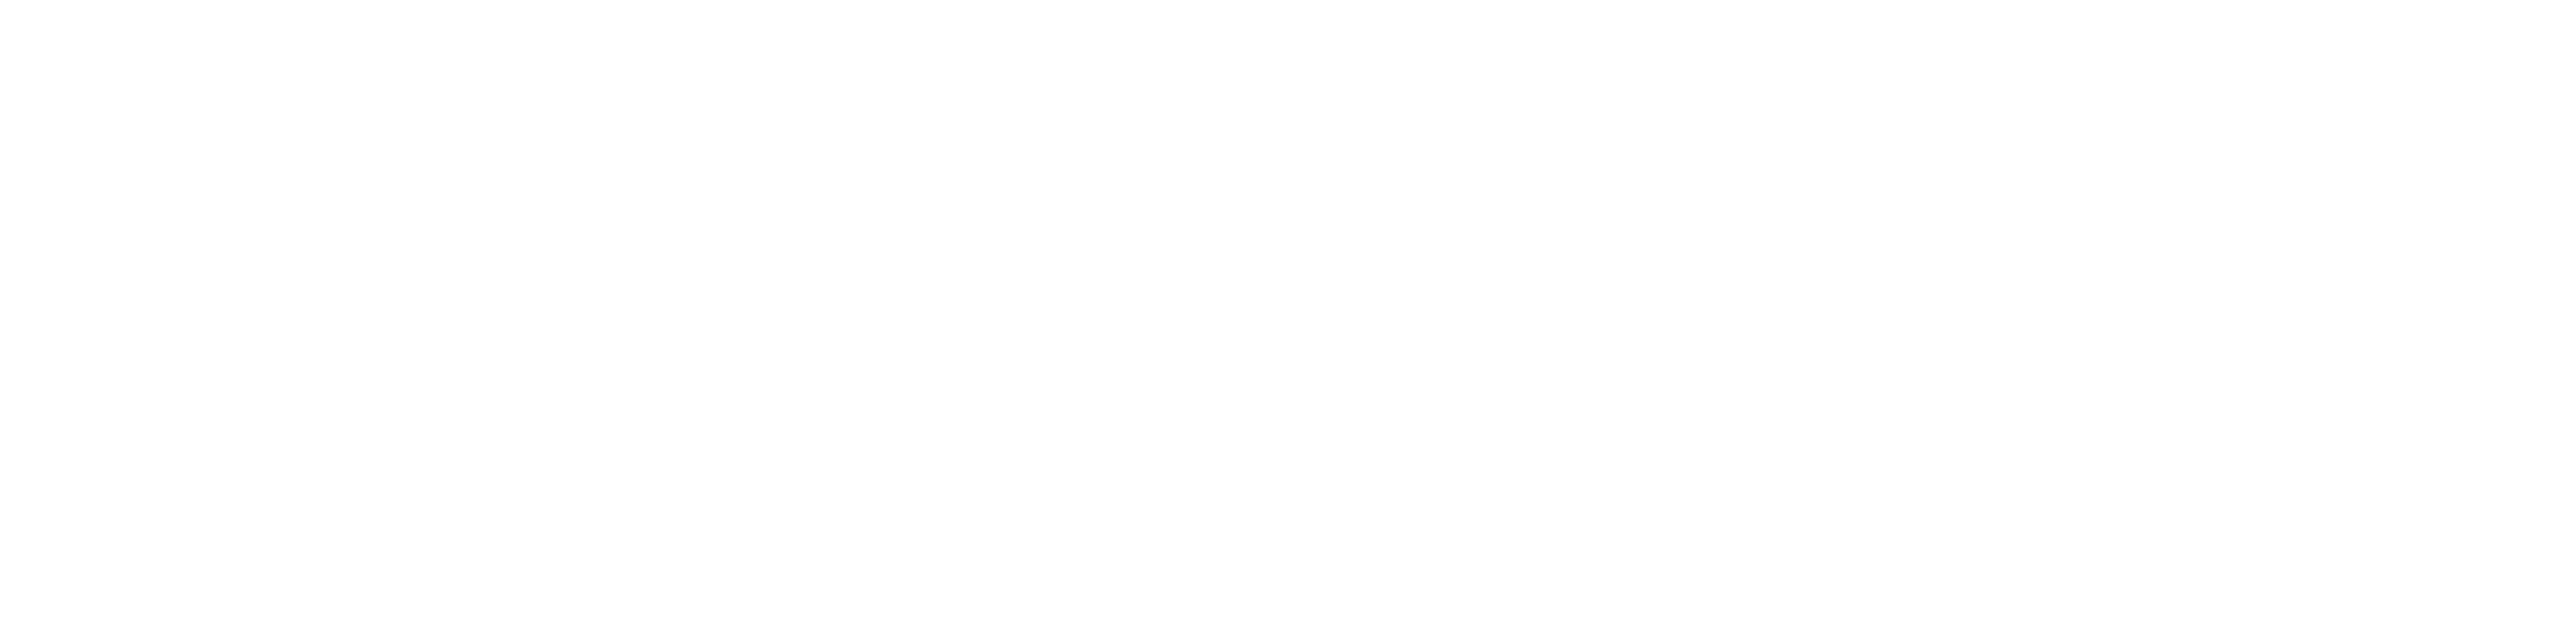

2020-06-02 23:29:47,048 logger INFO loss 0.59, 3D Dis:  5.85mm, shiftDiff: 39180.078125, MemUsed:50.86
2020-06-02 23:29:56,019 logger INFO loss 0.57, 3D Dis:  5.80mm, shiftDiff: 38879.171875, MemUsed:50.86
2020-06-02 23:30:05,065 logger INFO loss 0.55, 3D Dis:  5.76mm, shiftDiff: 38582.136719, MemUsed:50.86
2020-06-02 23:30:14,099 logger INFO loss 0.53, 3D Dis:  5.72mm, shiftDiff: 38290.597656, MemUsed:50.86
2020-06-02 23:30:23,189 logger INFO loss 0.52, 3D Dis:  5.67mm, shiftDiff: 38004.363281, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


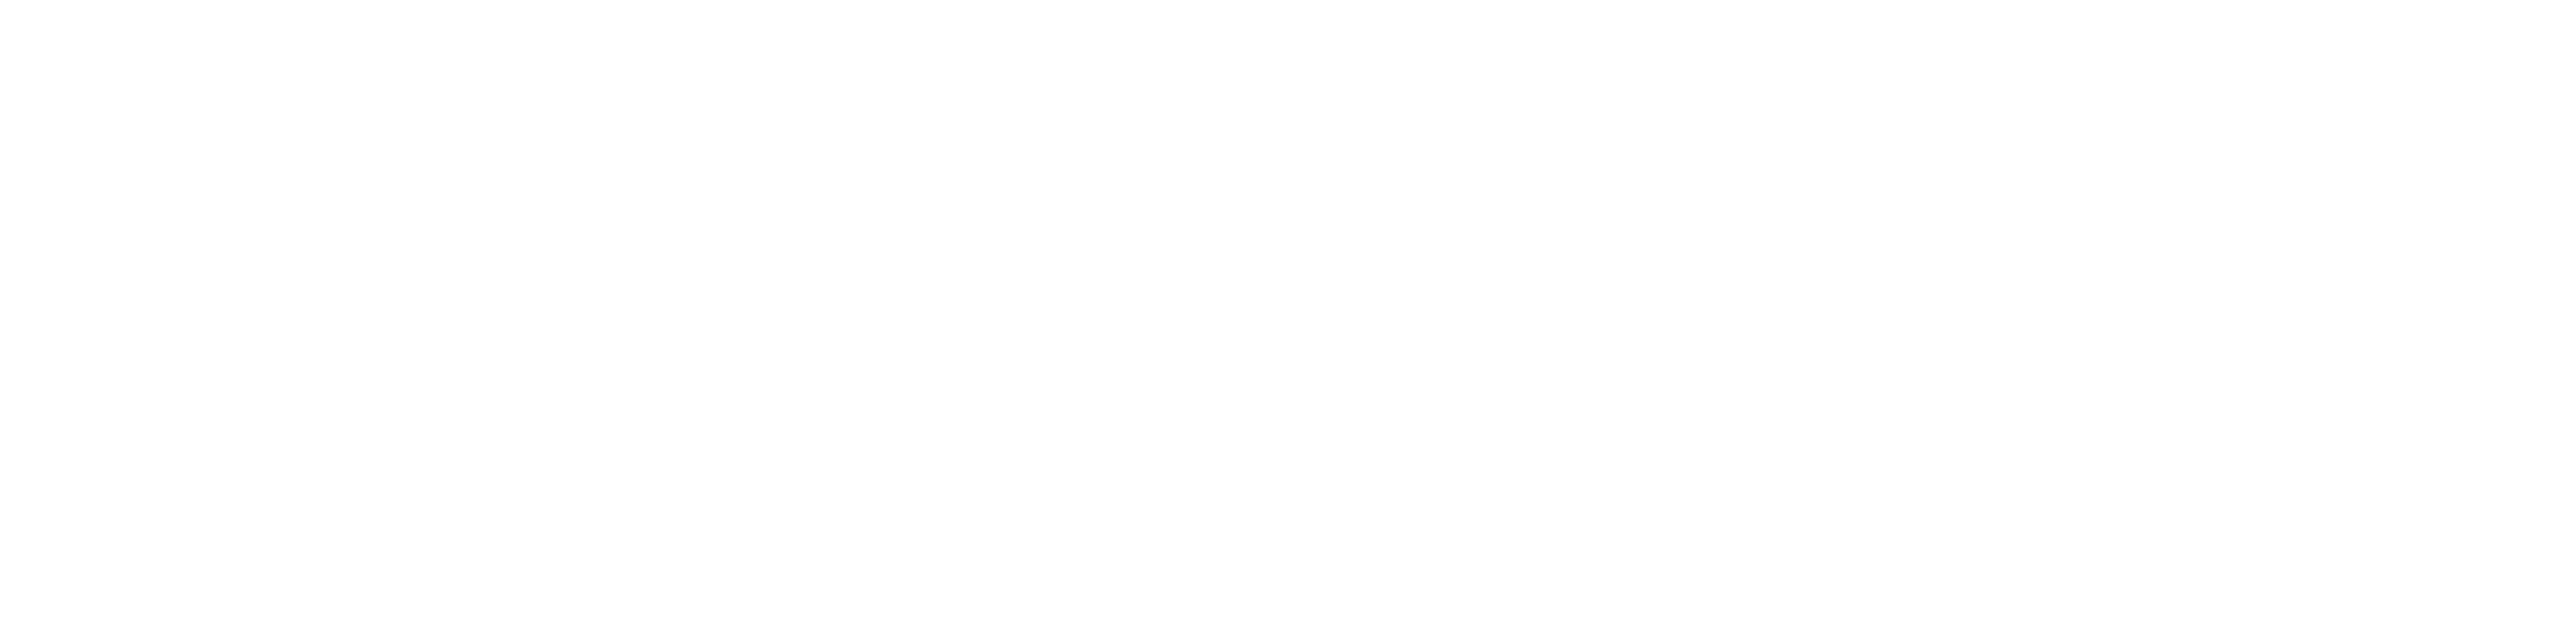

2020-06-02 23:30:51,679 logger INFO loss 0.50, 3D Dis:  5.63mm, shiftDiff: 37724.093750, MemUsed:50.86
2020-06-02 23:31:00,755 logger INFO loss 0.49, 3D Dis:  5.59mm, shiftDiff: 37449.828125, MemUsed:50.86
2020-06-02 23:31:09,816 logger INFO loss 0.47, 3D Dis:  5.55mm, shiftDiff: 37182.648438, MemUsed:50.86
2020-06-02 23:31:19,163 logger INFO loss 0.46, 3D Dis:  5.51mm, shiftDiff: 36924.539062, MemUsed:50.86
2020-06-02 23:31:28,308 logger INFO loss 0.45, 3D Dis:  5.47mm, shiftDiff: 36676.460938, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


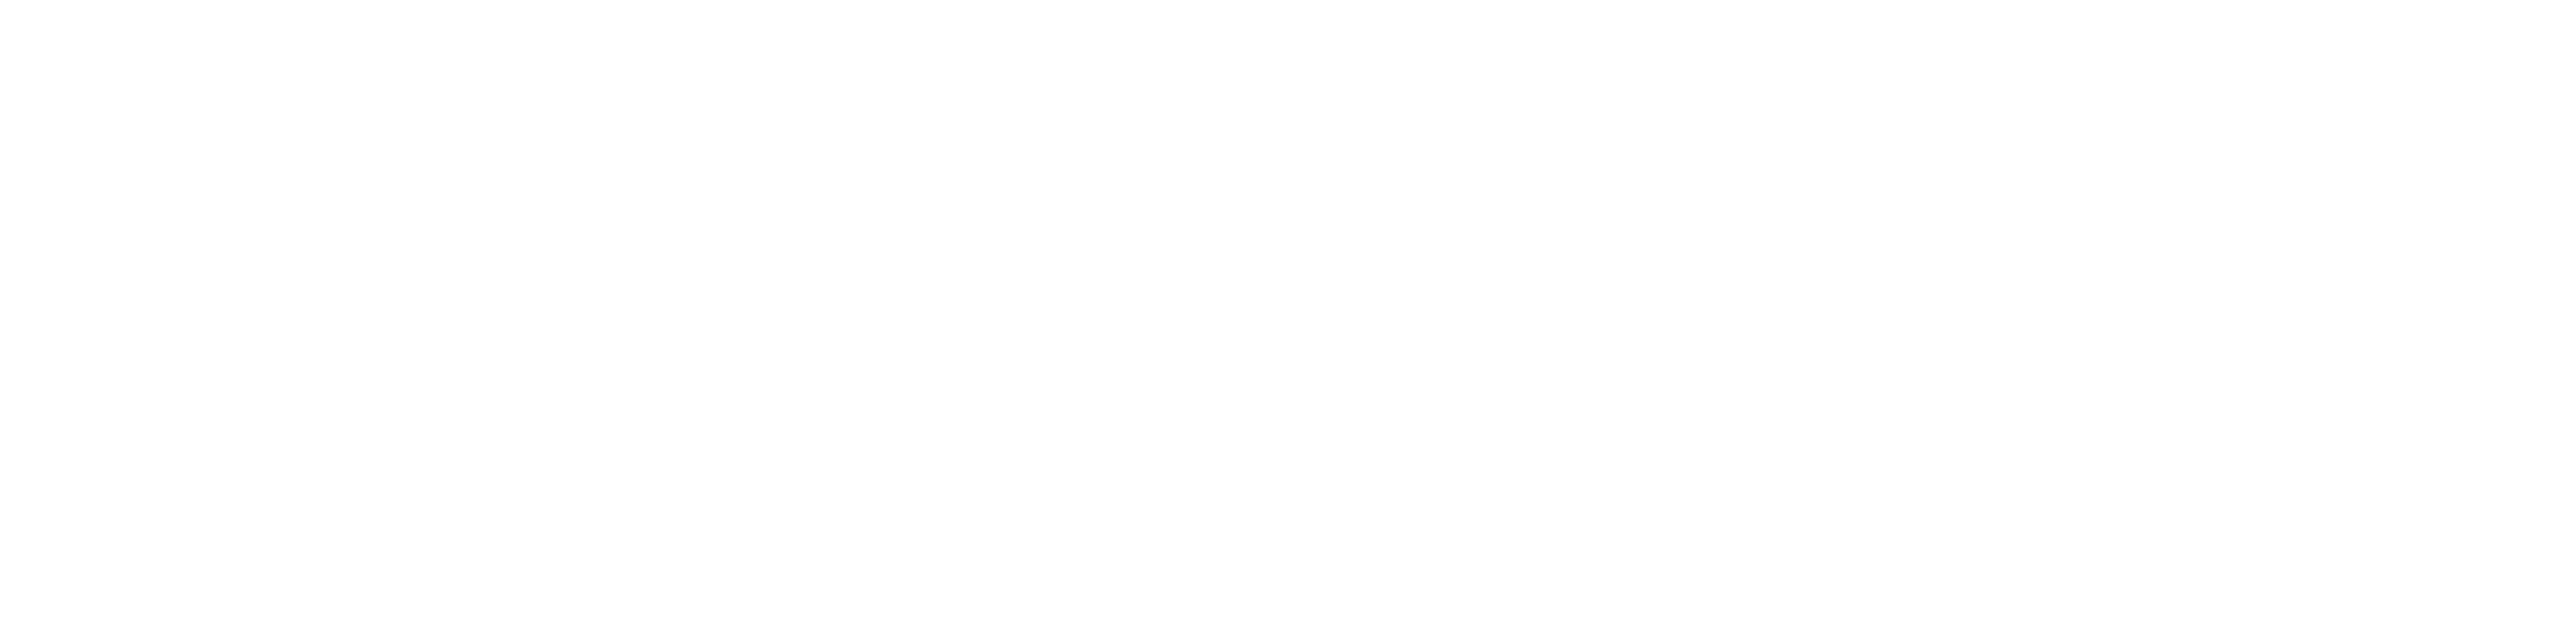

2020-06-02 23:31:56,872 logger INFO loss 0.45, 3D Dis:  5.43mm, shiftDiff: 36440.246094, MemUsed:50.86
2020-06-02 23:32:05,886 logger INFO loss 0.44, 3D Dis:  5.40mm, shiftDiff: 36216.695312, MemUsed:50.86
2020-06-02 23:32:14,877 logger INFO loss 0.44, 3D Dis:  5.37mm, shiftDiff: 36007.847656, MemUsed:50.86
2020-06-02 23:32:23,912 logger INFO loss 0.44, 3D Dis:  5.33mm, shiftDiff: 35815.468750, MemUsed:50.86
2020-06-02 23:32:32,985 logger INFO loss 0.44, 3D Dis:  5.31mm, shiftDiff: 35639.632812, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


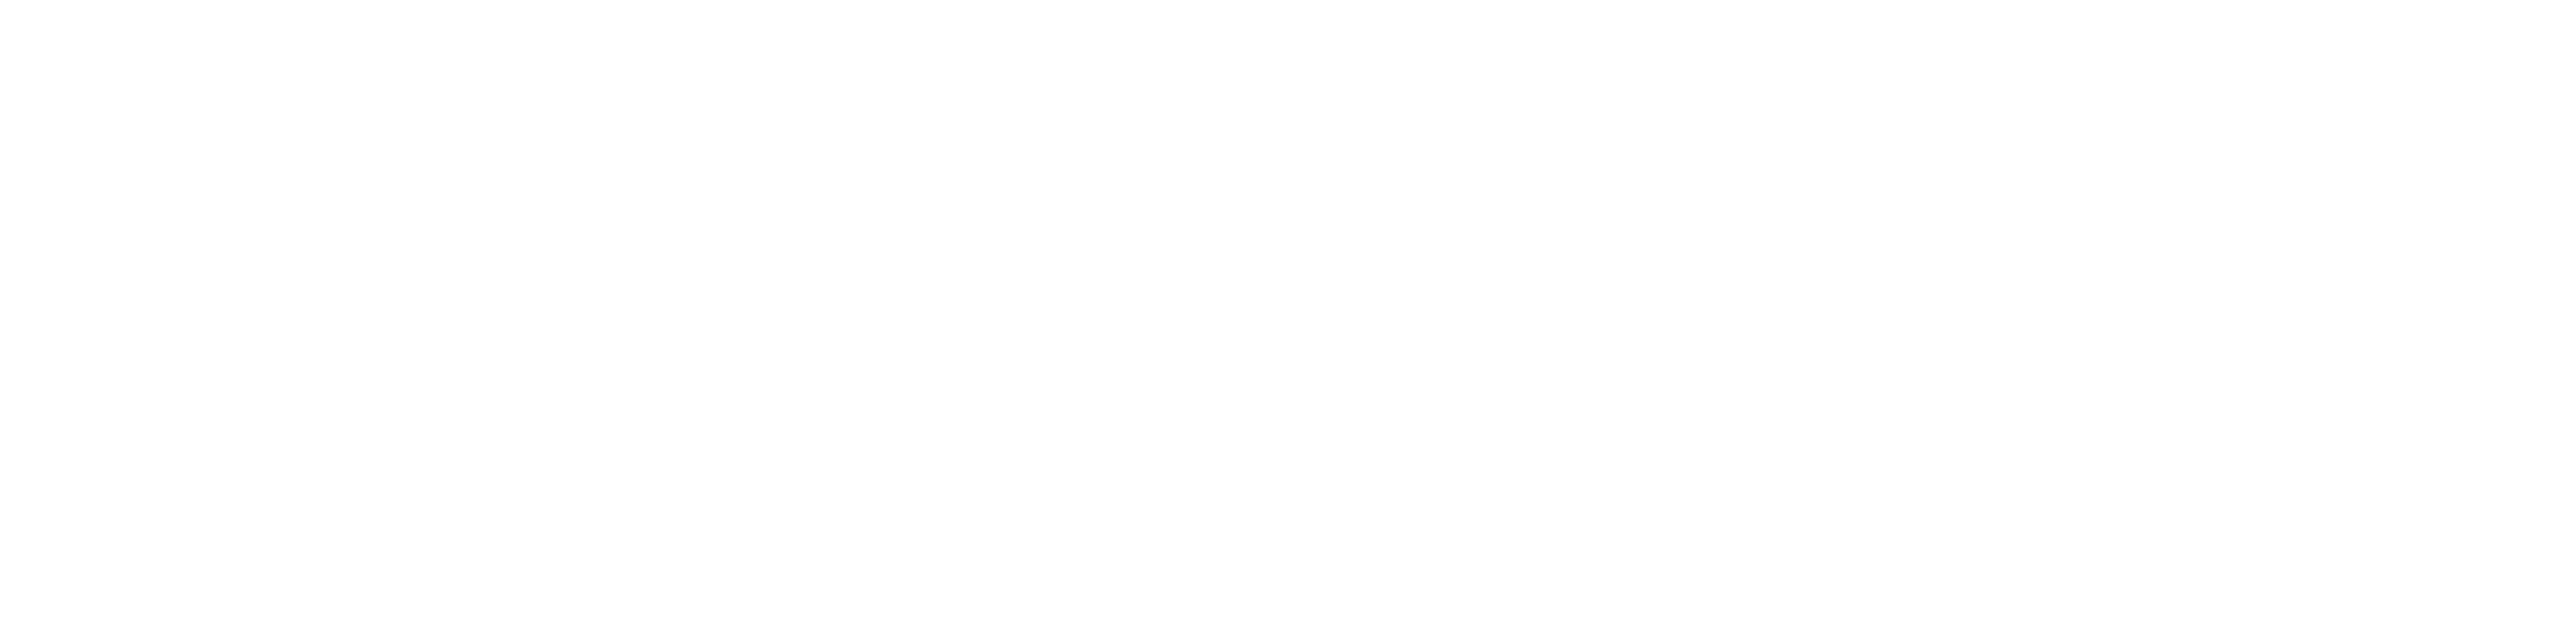

2020-06-02 23:33:01,623 logger INFO loss 0.44, 3D Dis:  5.28mm, shiftDiff: 35477.507812, MemUsed:50.86
2020-06-02 23:33:10,573 logger INFO loss 0.44, 3D Dis:  5.26mm, shiftDiff: 35330.515625, MemUsed:50.86
2020-06-02 23:33:19,703 logger INFO loss 0.44, 3D Dis:  5.23mm, shiftDiff: 35197.332031, MemUsed:50.86
2020-06-02 23:33:28,784 logger INFO loss 0.44, 3D Dis:  5.21mm, shiftDiff: 35075.738281, MemUsed:50.86
2020-06-02 23:33:37,875 logger INFO loss 0.44, 3D Dis:  5.20mm, shiftDiff: 34964.023438, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


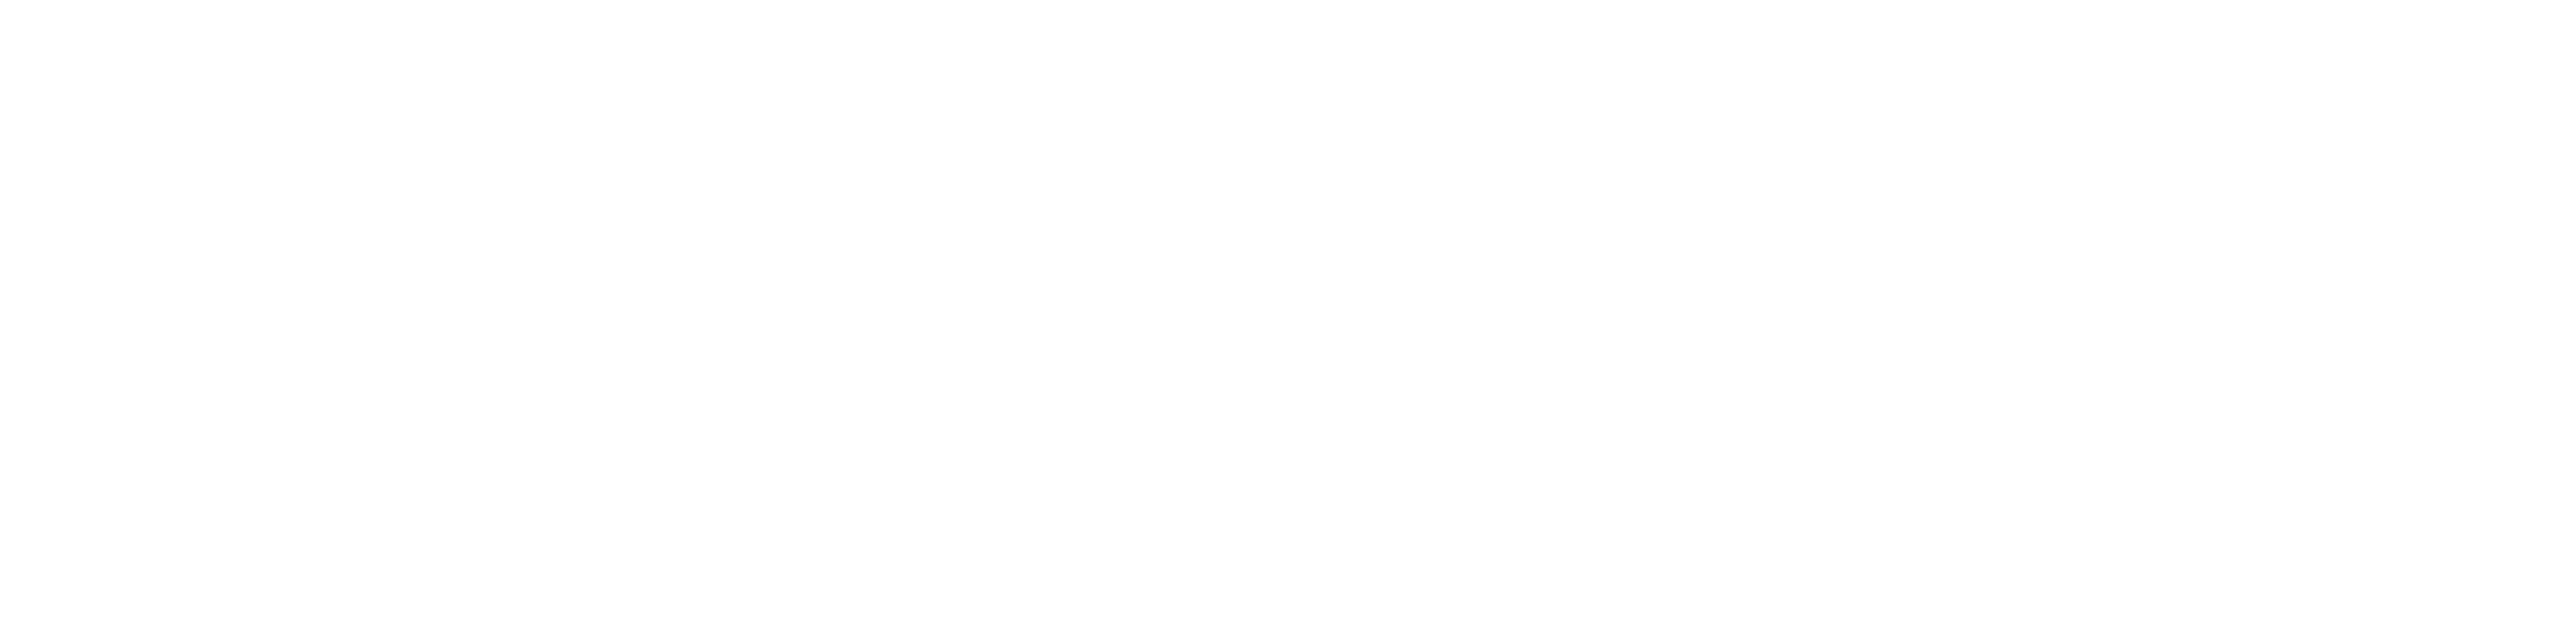

2020-06-02 23:34:06,425 logger INFO loss 0.44, 3D Dis:  5.18mm, shiftDiff: 34861.433594, MemUsed:50.86
2020-06-02 23:34:15,460 logger INFO loss 0.43, 3D Dis:  5.16mm, shiftDiff: 34768.484375, MemUsed:50.86
2020-06-02 23:34:24,499 logger INFO loss 0.43, 3D Dis:  5.15mm, shiftDiff: 34684.562500, MemUsed:50.86
2020-06-02 23:34:33,597 logger INFO loss 0.43, 3D Dis:  5.14mm, shiftDiff: 34609.808594, MemUsed:50.86
2020-06-02 23:34:42,709 logger INFO loss 0.43, 3D Dis:  5.13mm, shiftDiff: 34543.648438, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


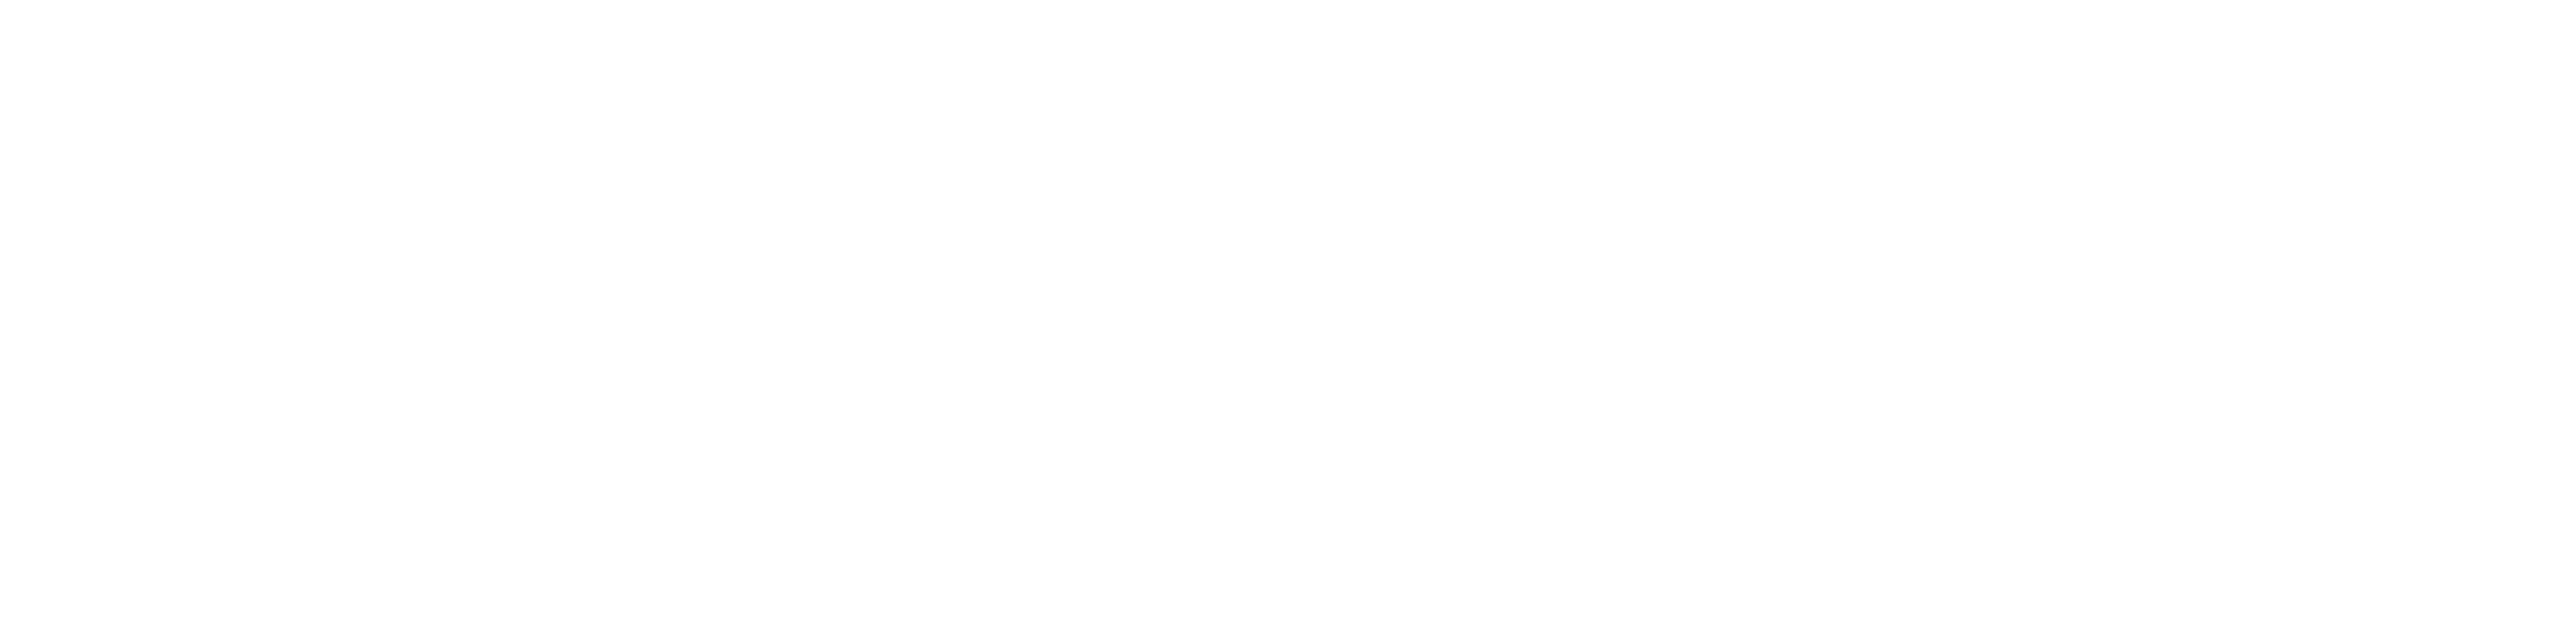

2020-06-02 23:35:11,251 logger INFO loss 0.43, 3D Dis:  5.12mm, shiftDiff: 34484.277344, MemUsed:50.86
2020-06-02 23:35:20,251 logger INFO loss 0.42, 3D Dis:  5.11mm, shiftDiff: 34430.976562, MemUsed:50.86
2020-06-02 23:35:29,262 logger INFO loss 0.42, 3D Dis:  5.10mm, shiftDiff: 34383.523438, MemUsed:50.86
2020-06-02 23:35:38,306 logger INFO loss 0.42, 3D Dis:  5.09mm, shiftDiff: 34340.714844, MemUsed:50.86
2020-06-02 23:35:47,430 logger INFO loss 0.42, 3D Dis:  5.09mm, shiftDiff: 34301.808594, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


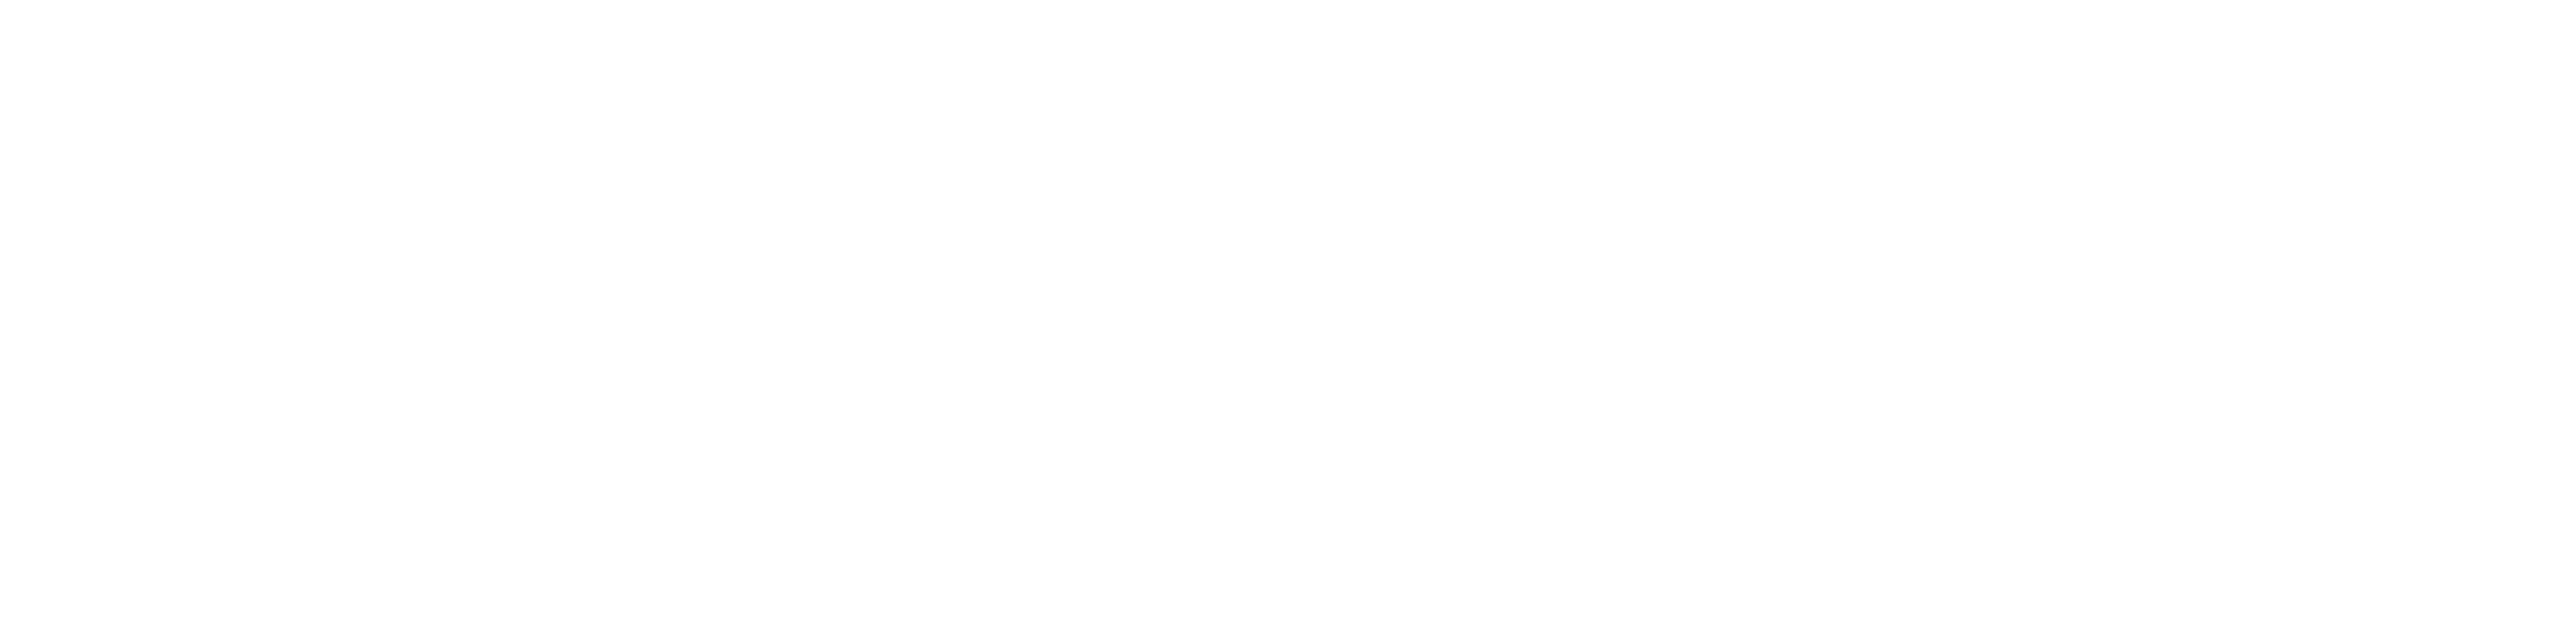

2020-06-02 23:36:15,966 logger INFO loss 0.41, 3D Dis:  5.08mm, shiftDiff: 34265.785156, MemUsed:50.86
2020-06-02 23:36:25,019 logger INFO loss 0.41, 3D Dis:  5.08mm, shiftDiff: 34230.906250, MemUsed:50.86
2020-06-02 23:36:34,048 logger INFO loss 0.41, 3D Dis:  5.07mm, shiftDiff: 34195.734375, MemUsed:50.86
2020-06-02 23:36:43,128 logger INFO loss 0.41, 3D Dis:  5.07mm, shiftDiff: 34160.144531, MemUsed:50.86
2020-06-02 23:36:52,238 logger INFO loss 0.41, 3D Dis:  5.06mm, shiftDiff: 34123.367188, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


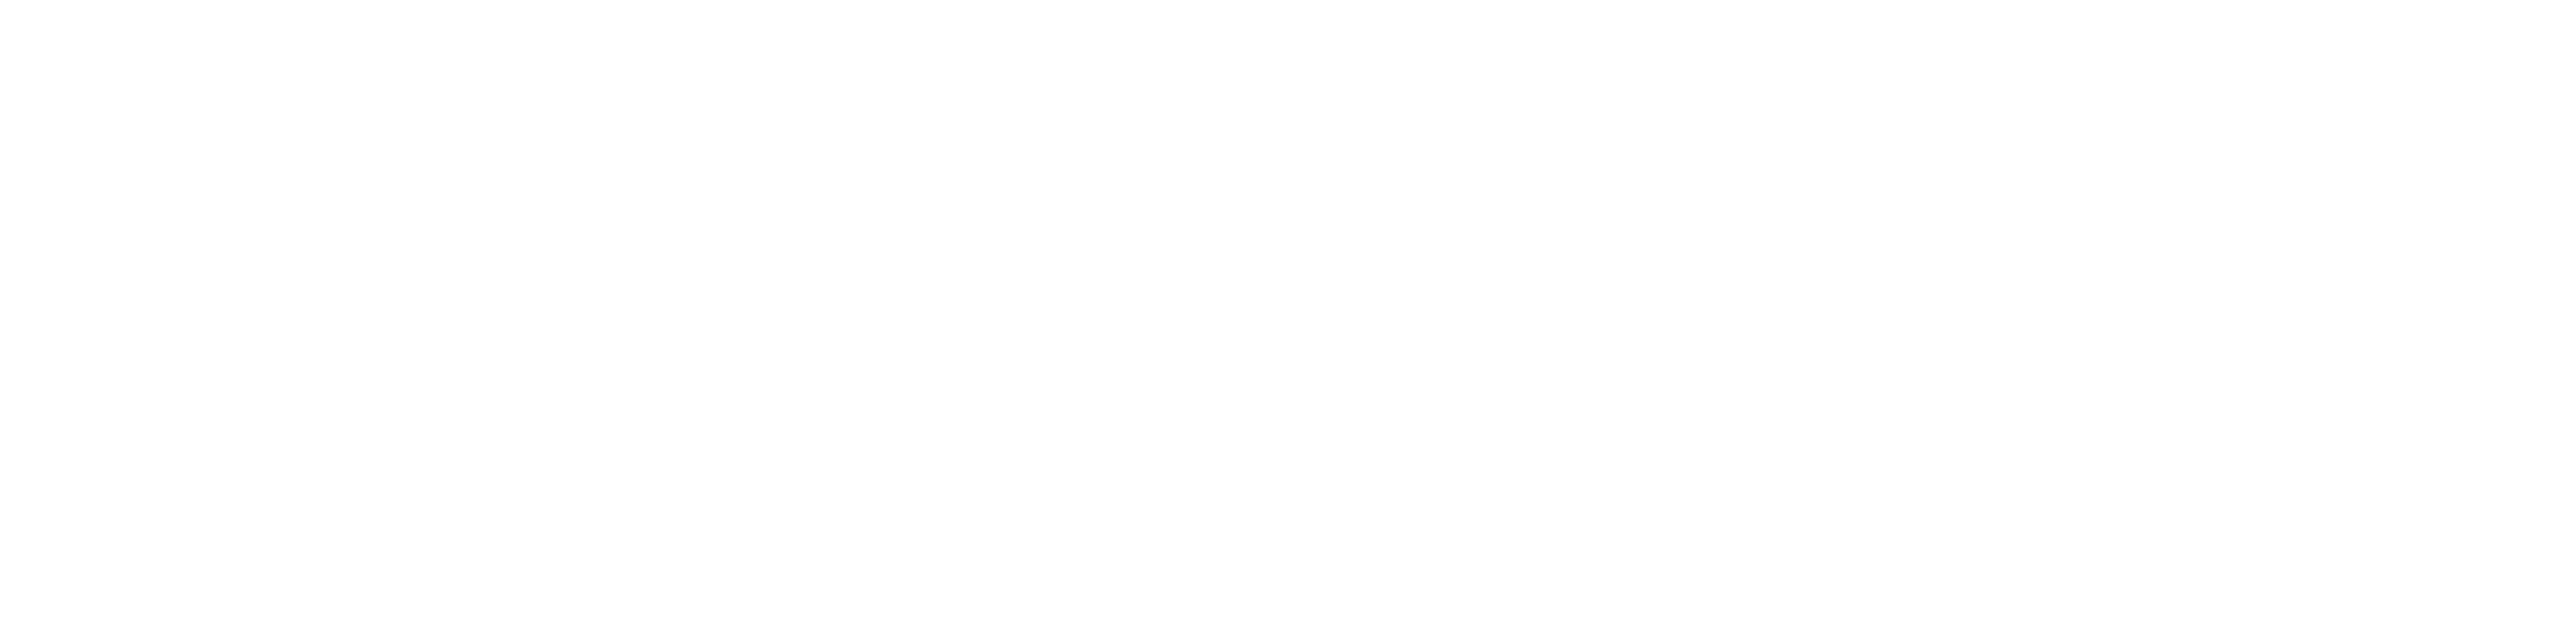

2020-06-02 23:37:20,766 logger INFO loss 0.41, 3D Dis:  5.06mm, shiftDiff: 34085.289062, MemUsed:50.86
2020-06-02 23:37:29,747 logger INFO loss 0.41, 3D Dis:  5.05mm, shiftDiff: 34045.023438, MemUsed:50.86
2020-06-02 23:37:38,761 logger INFO loss 0.41, 3D Dis:  5.04mm, shiftDiff: 34002.304688, MemUsed:50.86
2020-06-02 23:37:47,821 logger INFO loss 0.41, 3D Dis:  5.04mm, shiftDiff: 33957.125000, MemUsed:50.86
2020-06-02 23:37:56,996 logger INFO loss 0.41, 3D Dis:  5.03mm, shiftDiff: 33910.210938, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


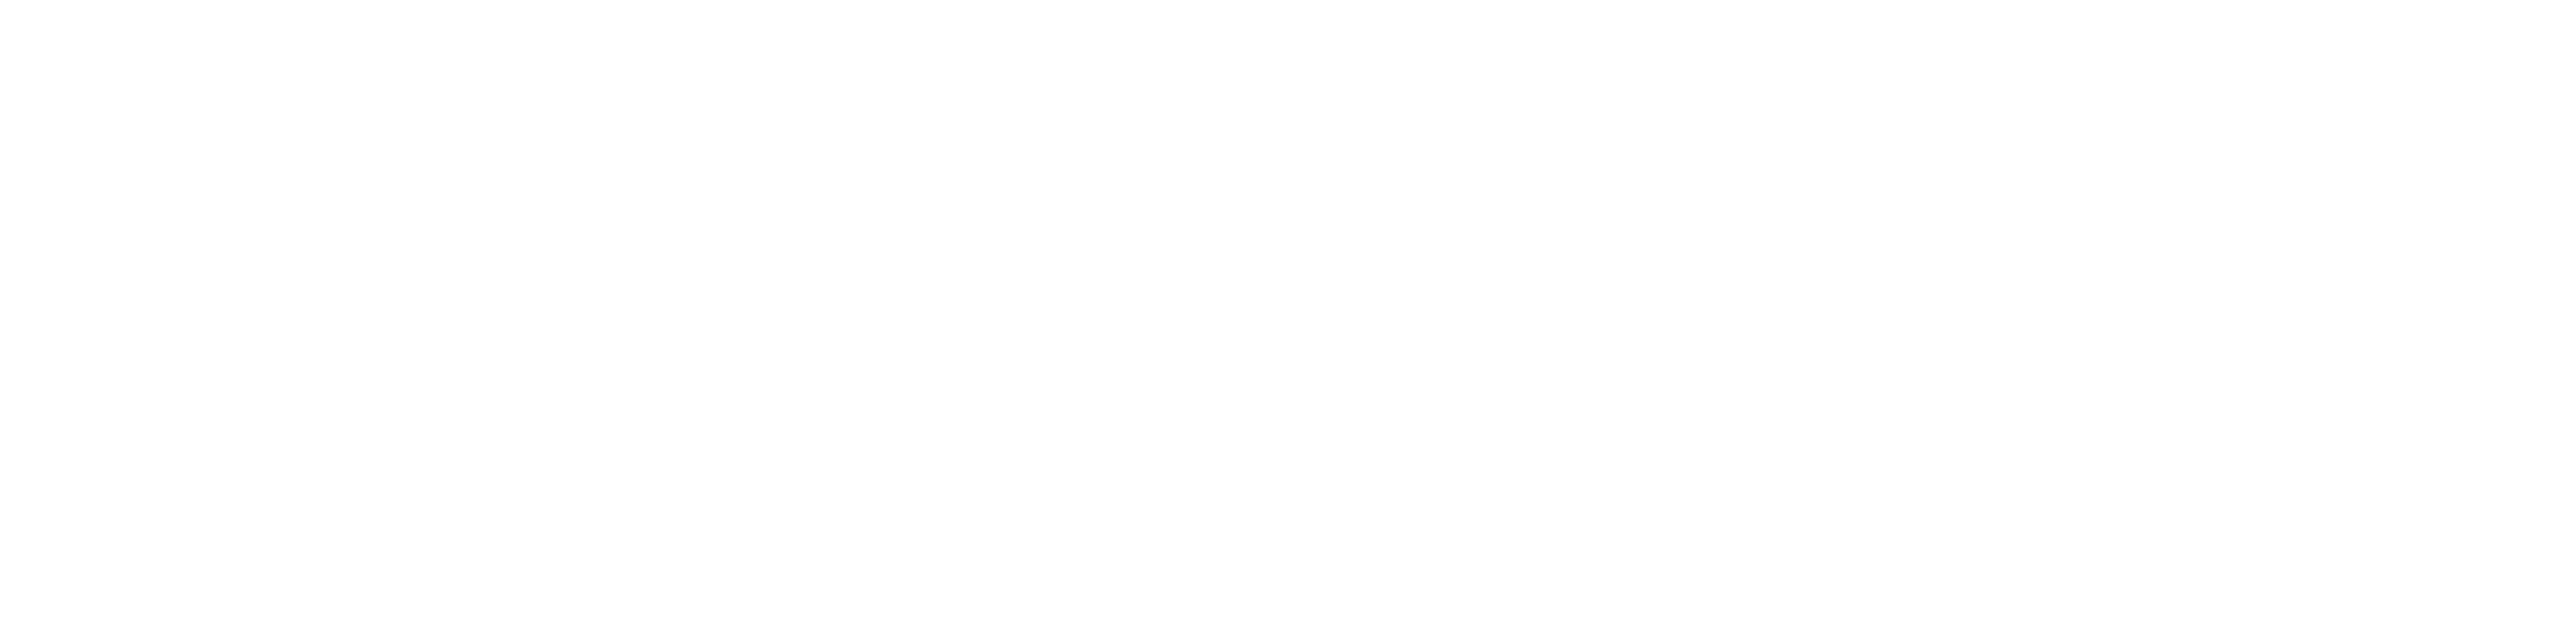

2020-06-02 23:38:25,523 logger INFO loss 0.41, 3D Dis:  5.02mm, shiftDiff: 33861.929688, MemUsed:50.86
2020-06-02 23:38:34,611 logger INFO loss 0.41, 3D Dis:  5.02mm, shiftDiff: 33812.652344, MemUsed:50.86
2020-06-02 23:38:43,718 logger INFO loss 0.41, 3D Dis:  5.01mm, shiftDiff: 33763.085938, MemUsed:50.86
2020-06-02 23:38:52,796 logger INFO loss 0.41, 3D Dis:  5.00mm, shiftDiff: 33713.253906, MemUsed:50.86
2020-06-02 23:39:01,893 logger INFO loss 0.40, 3D Dis:  4.99mm, shiftDiff: 33663.050781, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


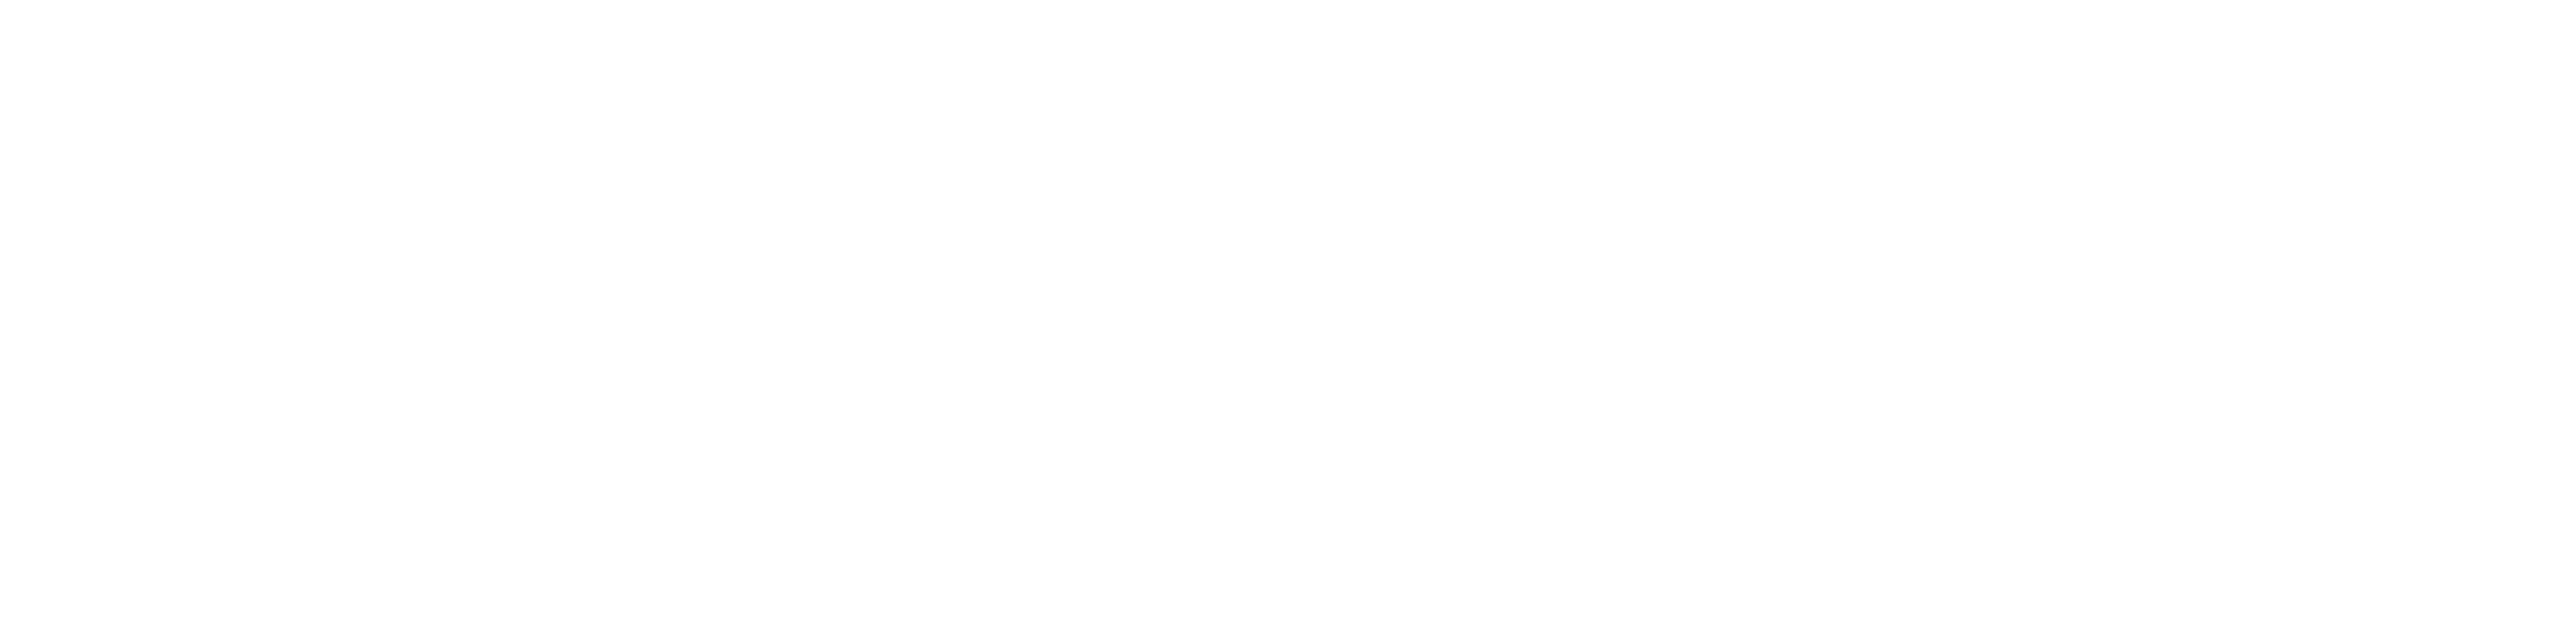

2020-06-02 23:39:30,444 logger INFO loss 0.40, 3D Dis:  4.99mm, shiftDiff: 33613.472656, MemUsed:50.86
2020-06-02 23:39:39,448 logger INFO loss 0.40, 3D Dis:  4.98mm, shiftDiff: 33564.339844, MemUsed:50.86
2020-06-02 23:39:48,532 logger INFO loss 0.40, 3D Dis:  4.97mm, shiftDiff: 33516.238281, MemUsed:50.86
2020-06-02 23:39:57,621 logger INFO loss 0.40, 3D Dis:  4.97mm, shiftDiff: 33469.281250, MemUsed:50.86
2020-06-02 23:40:06,720 logger INFO loss 0.40, 3D Dis:  4.96mm, shiftDiff: 33423.808594, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


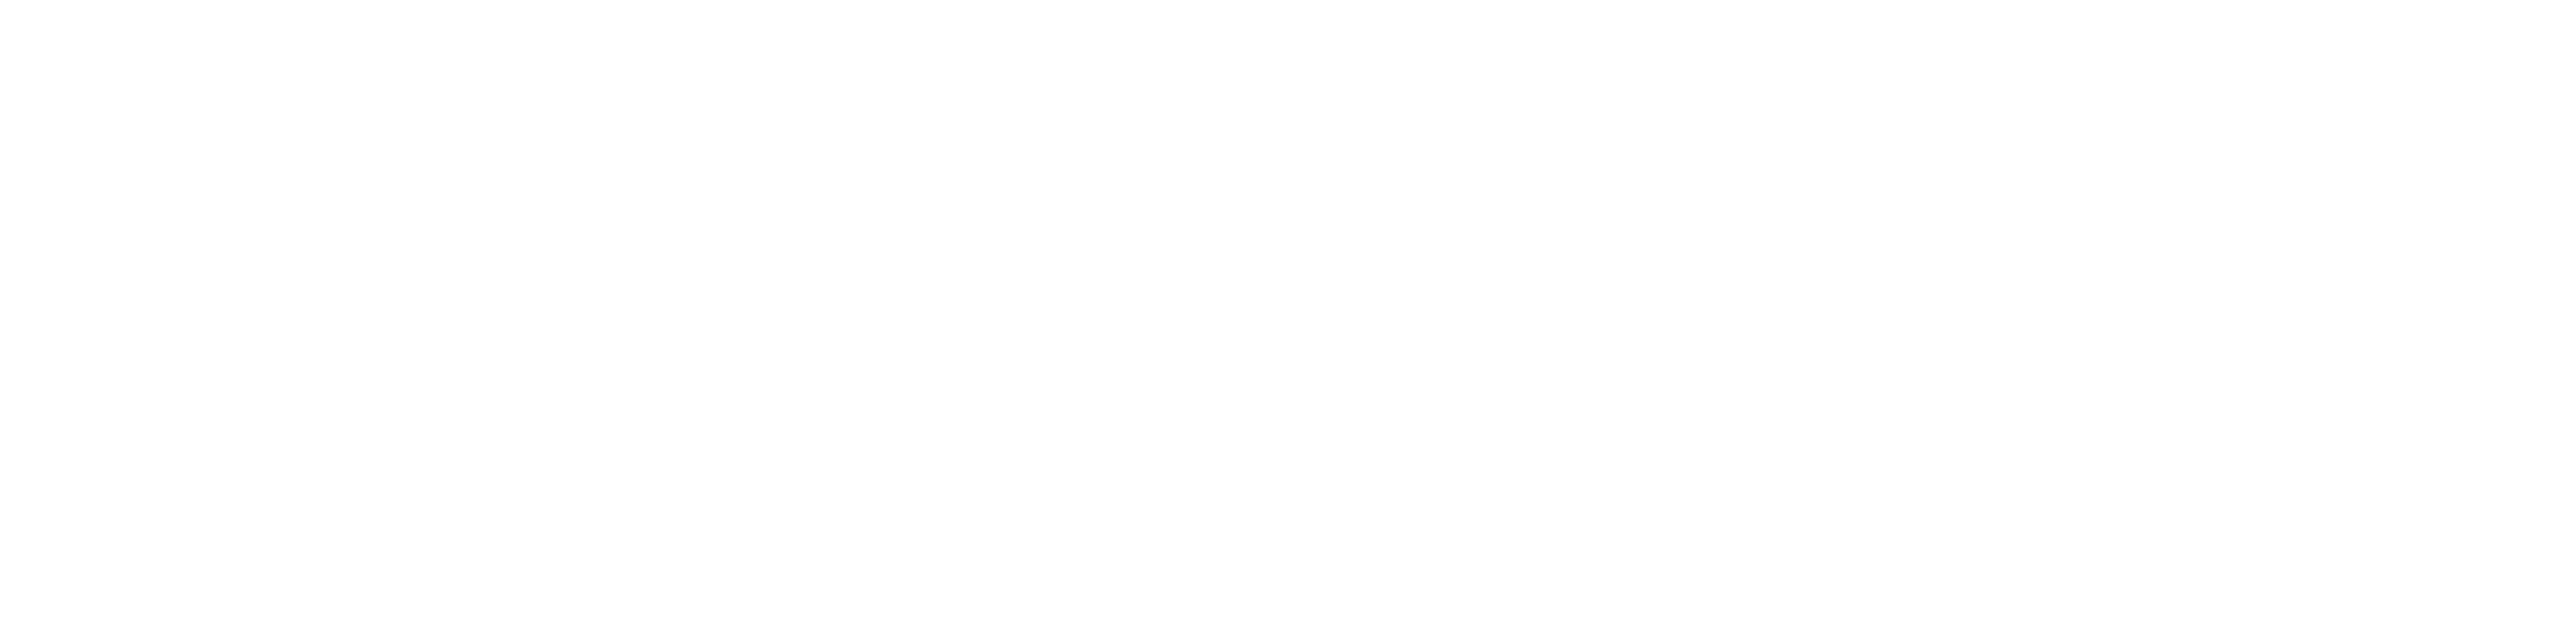

2020-06-02 23:40:35,262 logger INFO loss 0.40, 3D Dis:  4.95mm, shiftDiff: 33380.535156, MemUsed:50.86
2020-06-02 23:40:44,264 logger INFO loss 0.40, 3D Dis:  4.95mm, shiftDiff: 33339.585938, MemUsed:50.86
2020-06-02 23:40:53,337 logger INFO loss 0.40, 3D Dis:  4.94mm, shiftDiff: 33301.230469, MemUsed:50.86
2020-06-02 23:41:02,366 logger INFO loss 0.40, 3D Dis:  4.93mm, shiftDiff: 33265.312500, MemUsed:50.86
2020-06-02 23:41:11,466 logger INFO loss 0.40, 3D Dis:  4.93mm, shiftDiff: 33231.945312, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


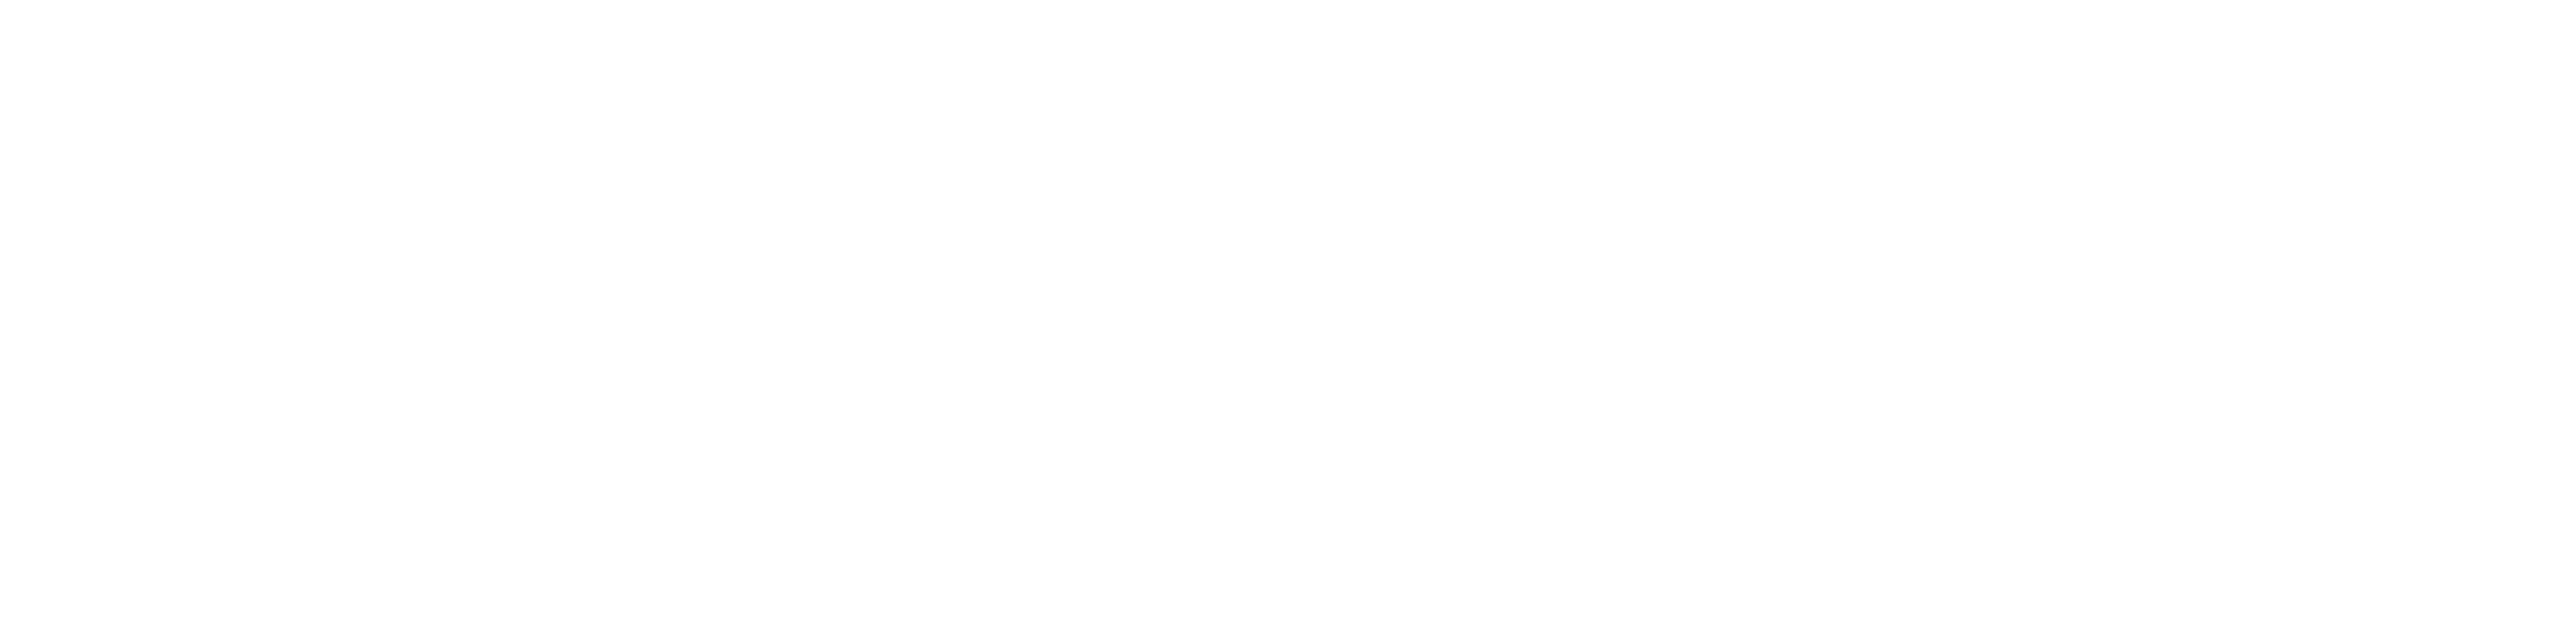

2020-06-02 23:41:40,002 logger INFO loss 0.40, 3D Dis:  4.92mm, shiftDiff: 33200.601562, MemUsed:50.86
2020-06-02 23:41:49,154 logger INFO loss 0.40, 3D Dis:  4.92mm, shiftDiff: 33171.218750, MemUsed:50.86
2020-06-02 23:41:58,306 logger INFO loss 0.40, 3D Dis:  4.91mm, shiftDiff: 33143.273438, MemUsed:50.86
2020-06-02 23:42:07,826 logger INFO loss 0.40, 3D Dis:  4.91mm, shiftDiff: 33116.570312, MemUsed:50.86
2020-06-02 23:42:17,093 logger INFO loss 0.40, 3D Dis:  4.91mm, shiftDiff: 33090.882812, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


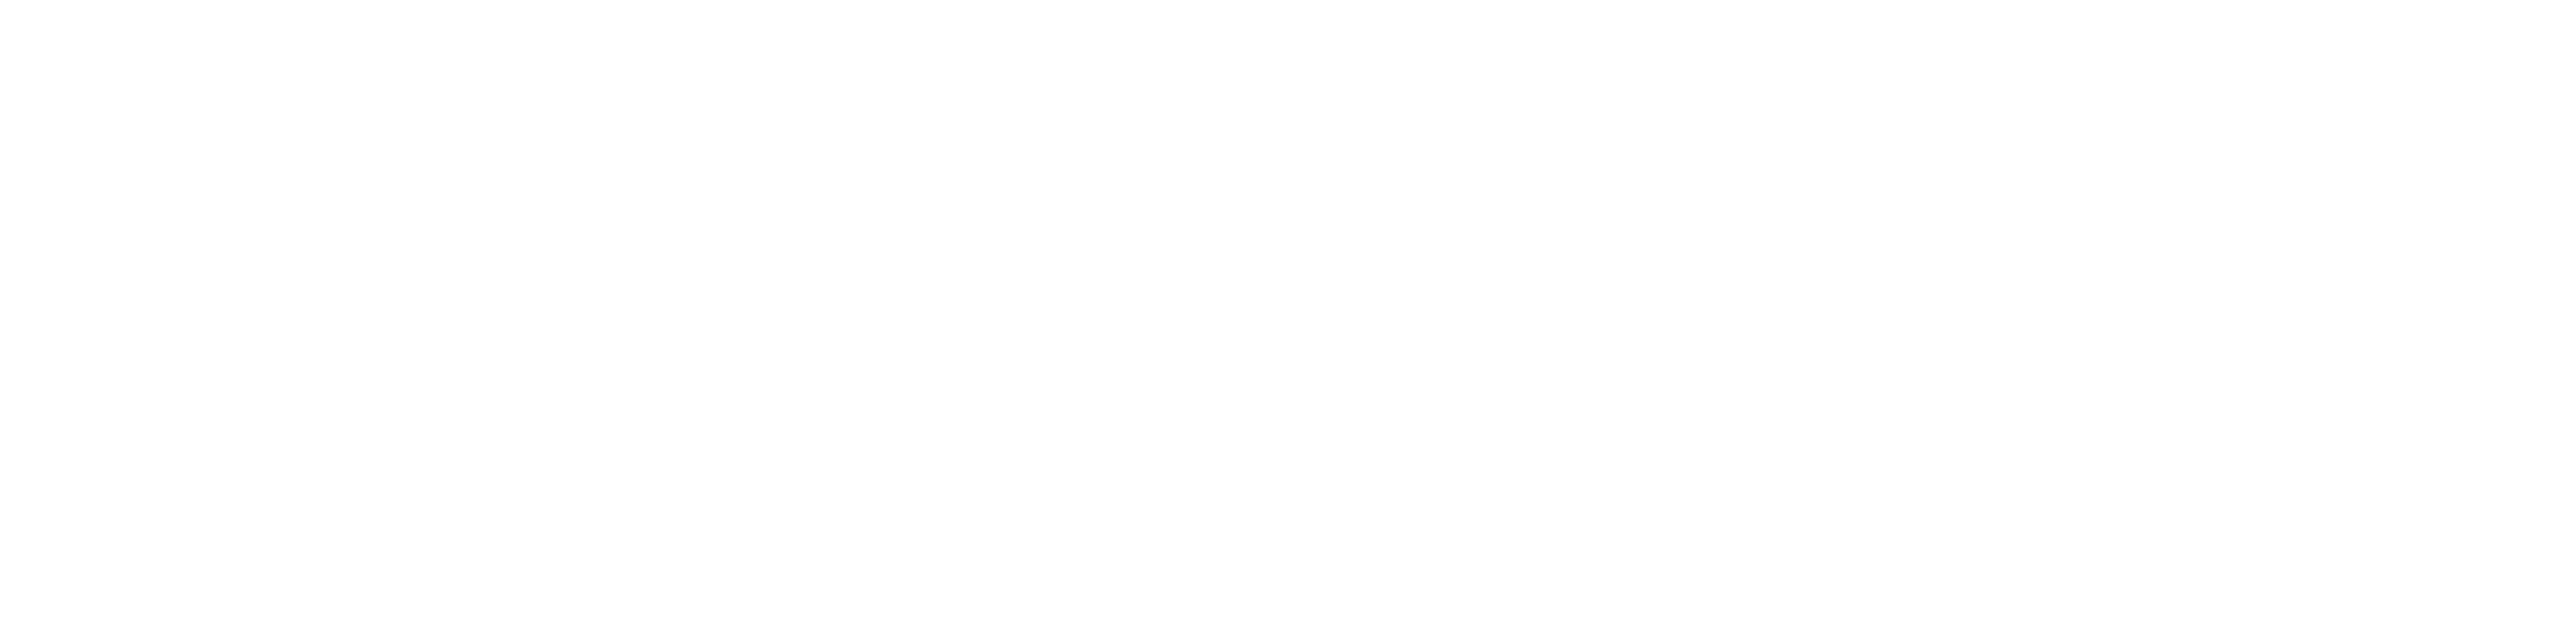

2020-06-02 23:42:46,119 logger INFO loss 0.40, 3D Dis:  4.90mm, shiftDiff: 33066.023438, MemUsed:50.86
2020-06-02 23:42:55,198 logger INFO loss 0.40, 3D Dis:  4.90mm, shiftDiff: 33041.929688, MemUsed:50.86
2020-06-02 23:43:04,293 logger INFO loss 0.40, 3D Dis:  4.90mm, shiftDiff: 33018.406250, MemUsed:50.86
2020-06-02 23:43:13,359 logger INFO loss 0.40, 3D Dis:  4.89mm, shiftDiff: 32995.468750, MemUsed:50.86
2020-06-02 23:43:22,471 logger INFO loss 0.40, 3D Dis:  4.89mm, shiftDiff: 32972.667969, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


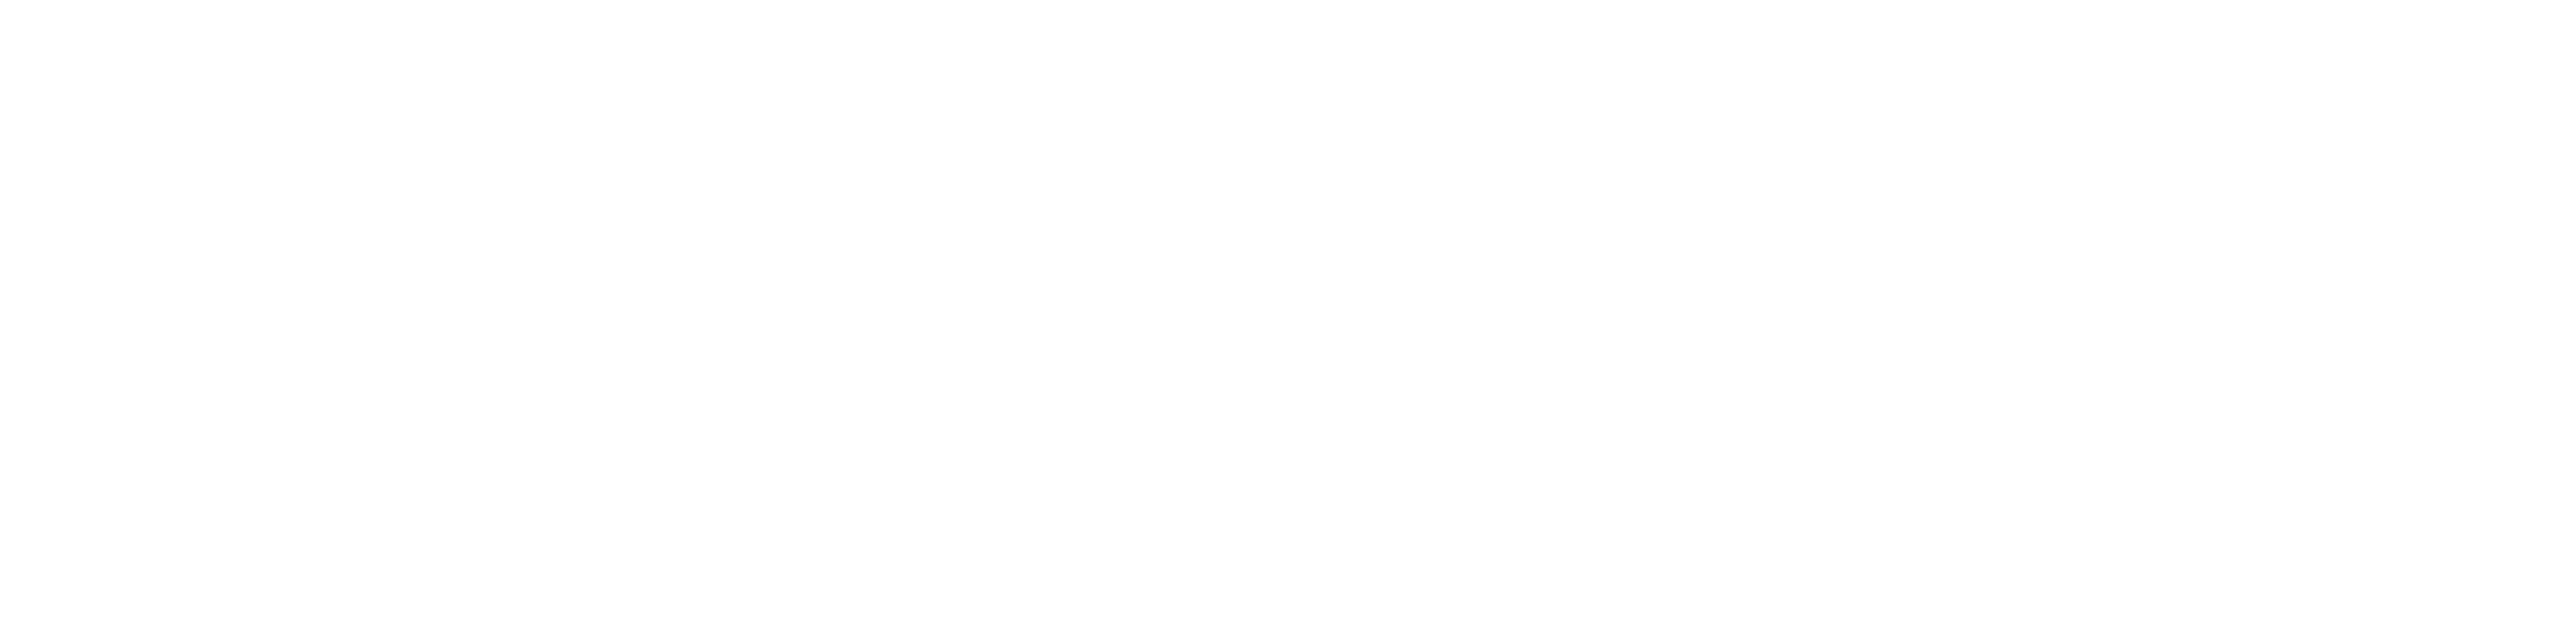

2020-06-02 23:43:50,951 logger INFO loss 0.40, 3D Dis:  4.88mm, shiftDiff: 32949.804688, MemUsed:50.86
2020-06-02 23:44:00,039 logger INFO loss 0.40, 3D Dis:  4.88mm, shiftDiff: 32927.199219, MemUsed:50.86
2020-06-02 23:44:09,130 logger INFO loss 0.40, 3D Dis:  4.88mm, shiftDiff: 32904.898438, MemUsed:50.86
2020-06-02 23:44:18,242 logger INFO loss 0.40, 3D Dis:  4.87mm, shiftDiff: 32882.460938, MemUsed:50.86
2020-06-02 23:44:27,305 logger INFO loss 0.40, 3D Dis:  4.87mm, shiftDiff: 32860.035156, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


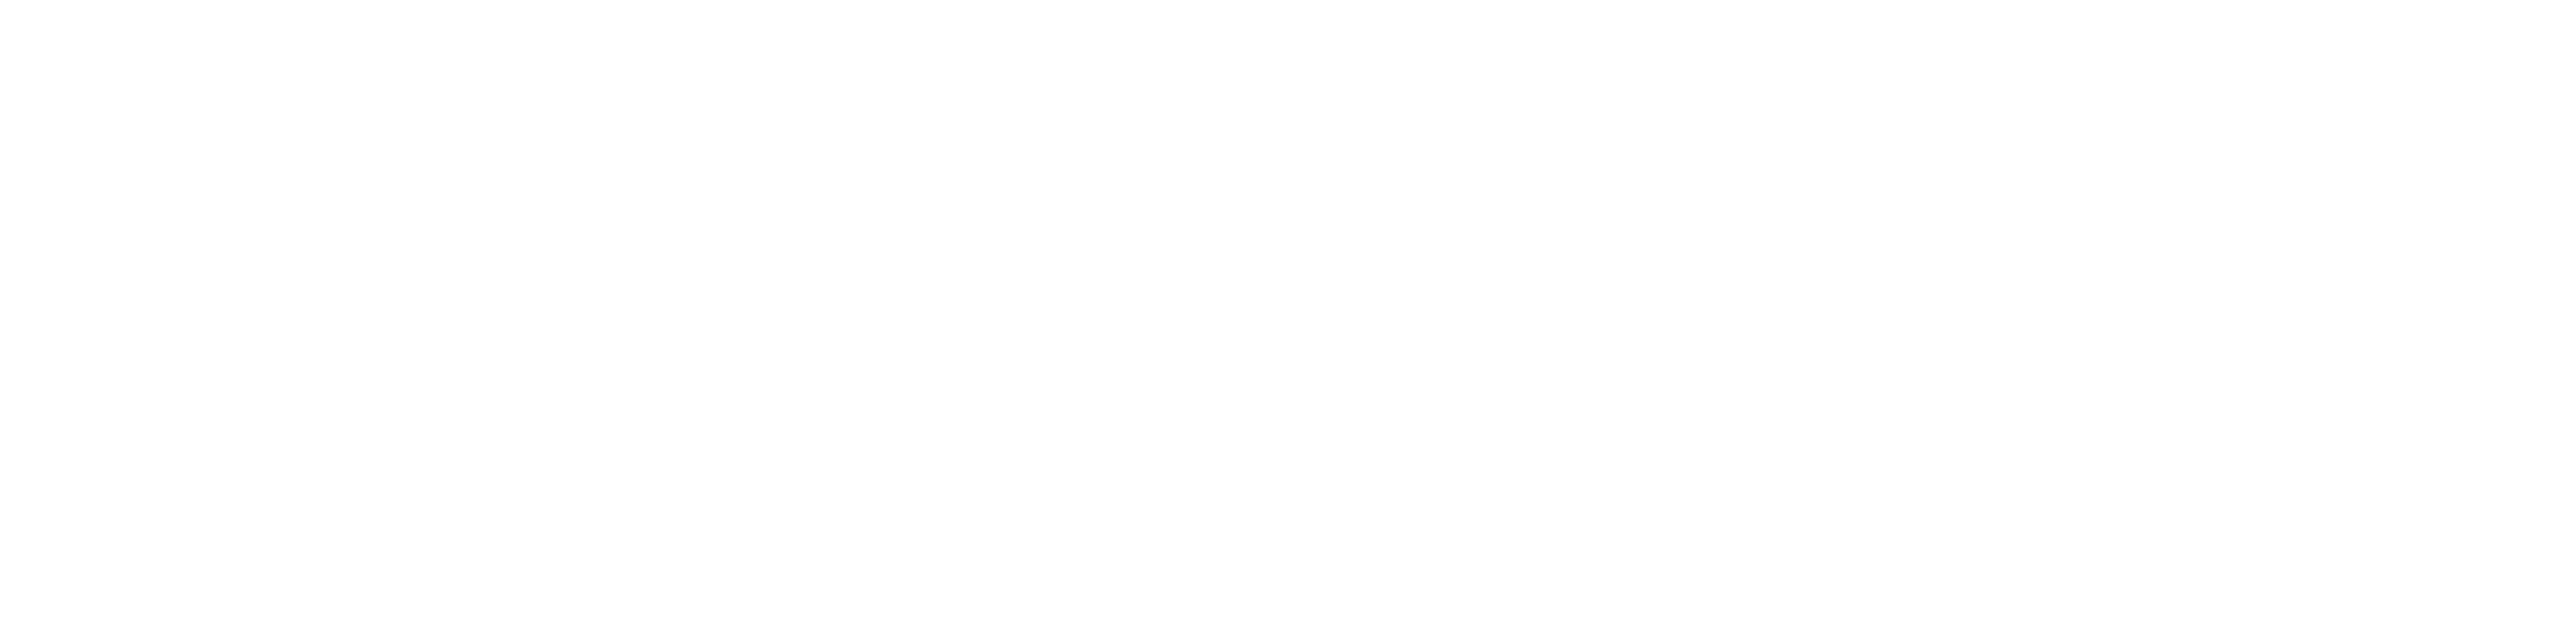

2020-06-02 23:44:55,844 logger INFO loss 0.40, 3D Dis:  4.87mm, shiftDiff: 32837.312500, MemUsed:50.86
2020-06-02 23:45:04,847 logger INFO loss 0.40, 3D Dis:  4.86mm, shiftDiff: 32814.250000, MemUsed:50.86
2020-06-02 23:45:13,937 logger INFO loss 0.40, 3D Dis:  4.86mm, shiftDiff: 32790.421875, MemUsed:50.86
2020-06-02 23:45:23,021 logger INFO loss 0.40, 3D Dis:  4.86mm, shiftDiff: 32766.037109, MemUsed:50.86
2020-06-02 23:45:32,119 logger INFO loss 0.40, 3D Dis:  4.85mm, shiftDiff: 32741.693359, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


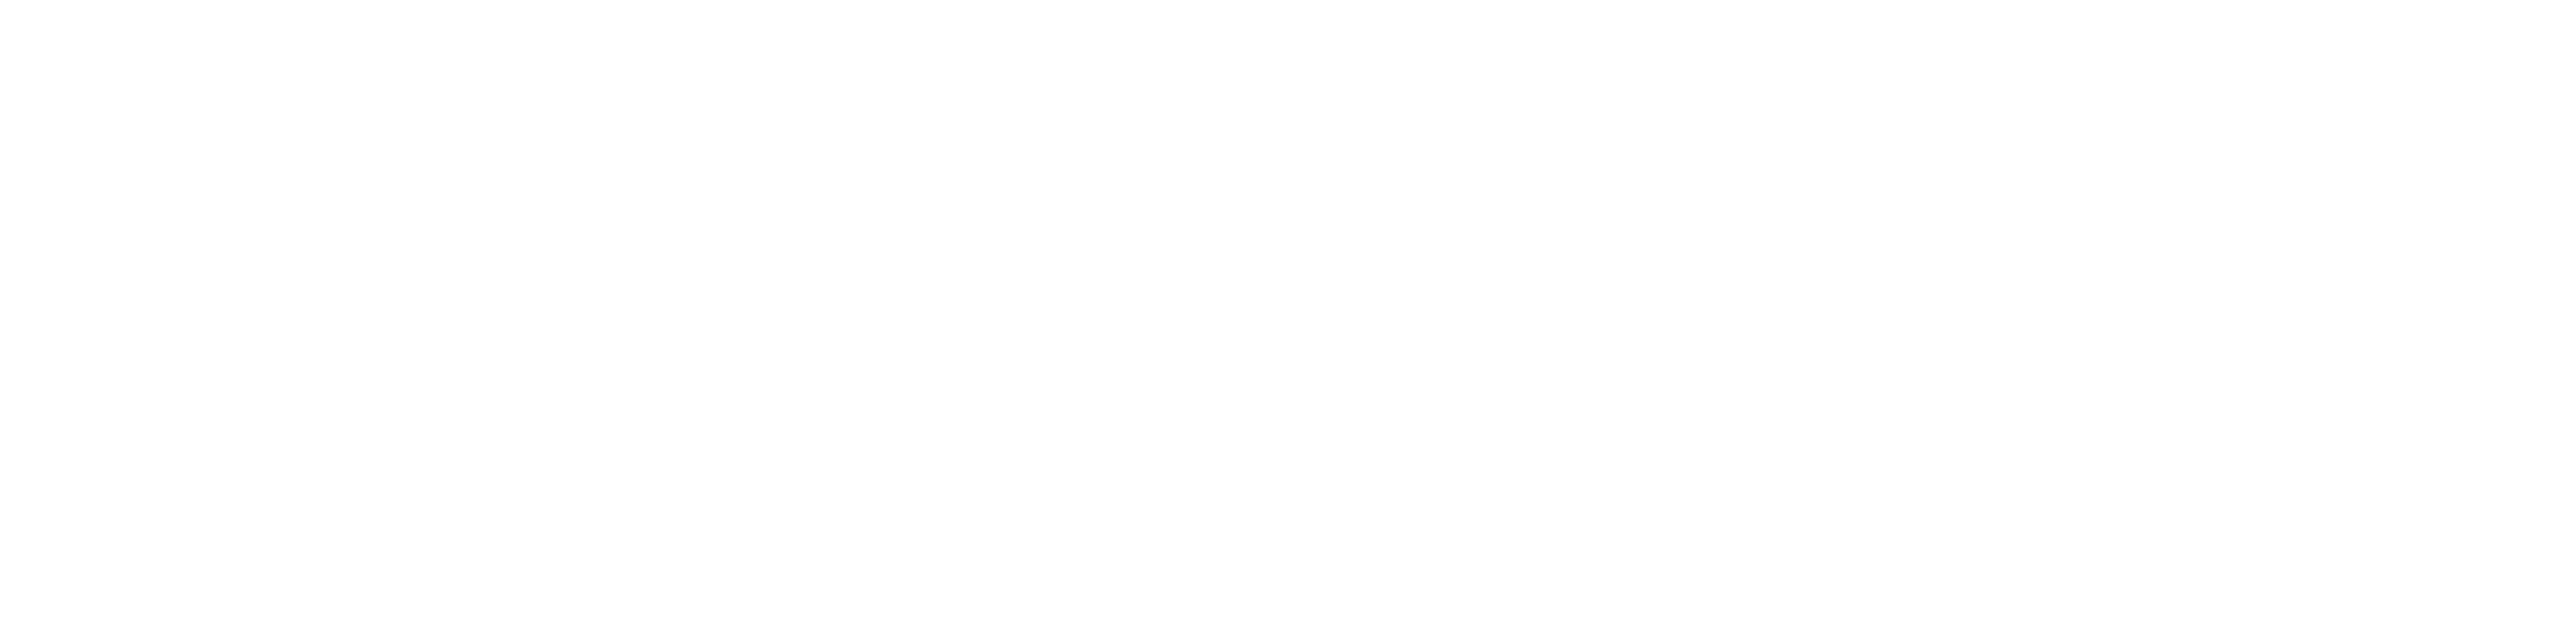

2020-06-02 23:46:00,502 logger INFO loss 0.40, 3D Dis:  4.85mm, shiftDiff: 32717.255859, MemUsed:50.86
2020-06-02 23:46:09,599 logger INFO loss 0.40, 3D Dis:  4.85mm, shiftDiff: 32693.253906, MemUsed:50.86
2020-06-02 23:46:18,646 logger INFO loss 0.40, 3D Dis:  4.84mm, shiftDiff: 32670.265625, MemUsed:50.86
2020-06-02 23:46:27,732 logger INFO loss 0.40, 3D Dis:  4.84mm, shiftDiff: 32647.933594, MemUsed:50.86
2020-06-02 23:46:36,870 logger INFO loss 0.40, 3D Dis:  4.84mm, shiftDiff: 32626.515625, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


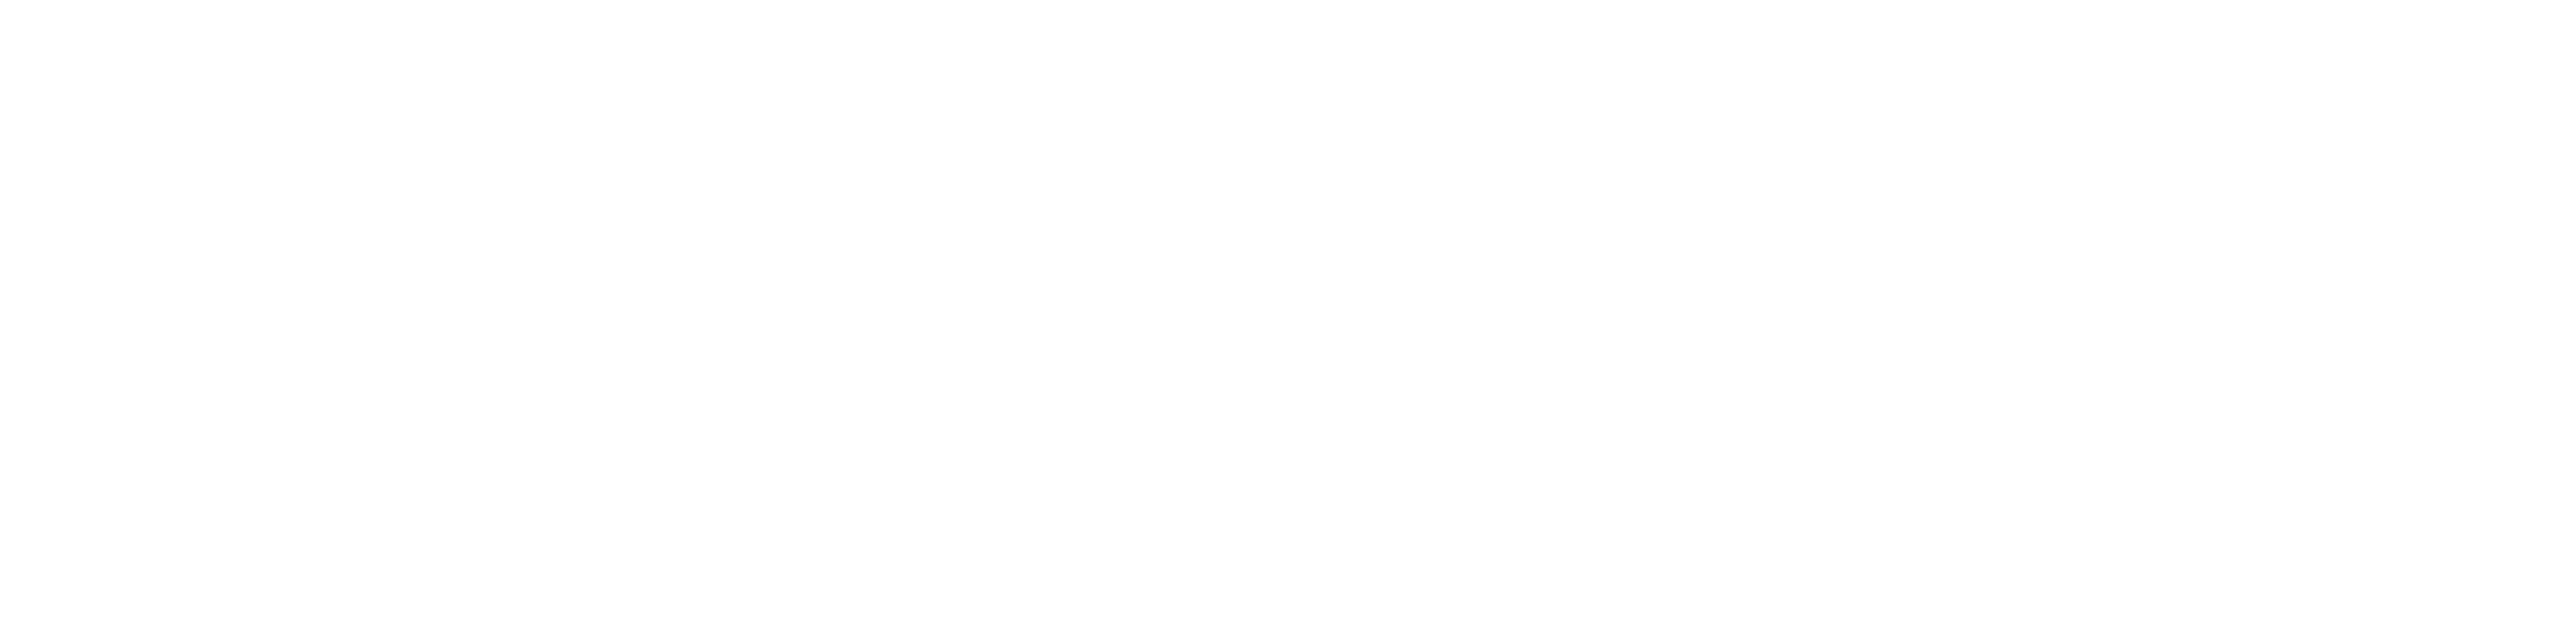

2020-06-02 23:47:05,453 logger INFO loss 0.40, 3D Dis:  4.83mm, shiftDiff: 32605.425781, MemUsed:50.86
2020-06-02 23:47:14,488 logger INFO loss 0.40, 3D Dis:  4.83mm, shiftDiff: 32584.791016, MemUsed:50.86
2020-06-02 23:47:23,571 logger INFO loss 0.40, 3D Dis:  4.83mm, shiftDiff: 32564.816406, MemUsed:50.86
2020-06-02 23:47:32,639 logger INFO loss 0.40, 3D Dis:  4.82mm, shiftDiff: 32544.996094, MemUsed:50.86
2020-06-02 23:47:41,778 logger INFO loss 0.40, 3D Dis:  4.82mm, shiftDiff: 32525.679688, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


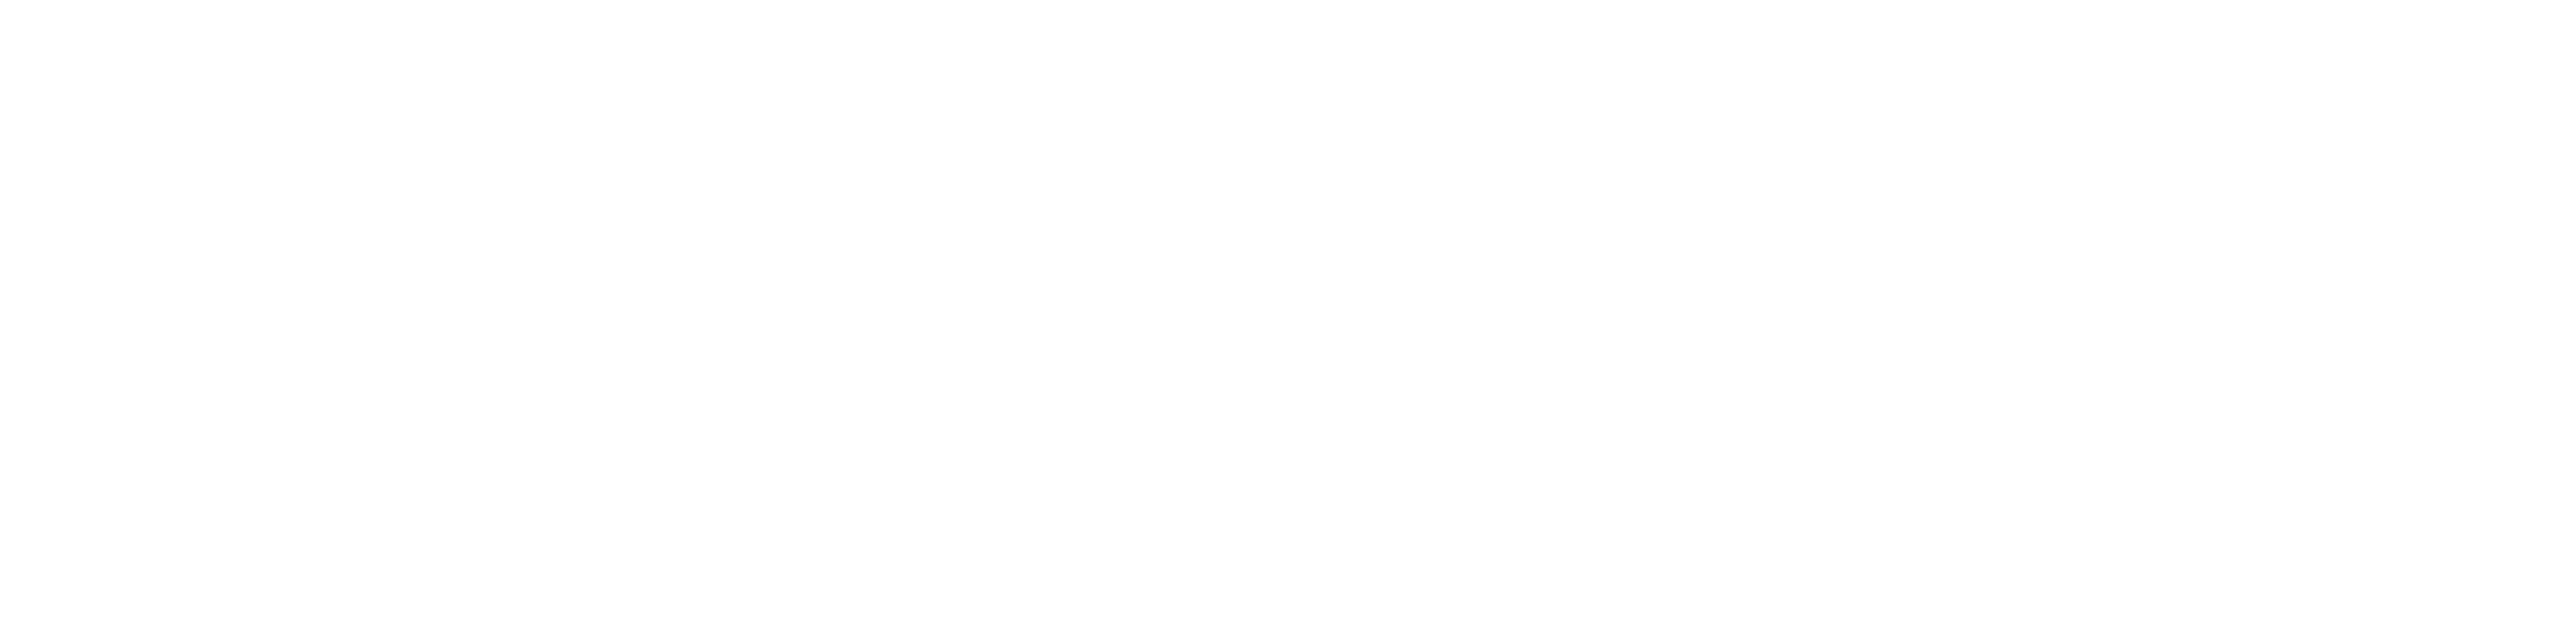

2020-06-02 23:48:10,354 logger INFO loss 0.40, 3D Dis:  4.82mm, shiftDiff: 32506.566406, MemUsed:50.86
2020-06-02 23:48:19,353 logger INFO loss 0.40, 3D Dis:  4.82mm, shiftDiff: 32487.804688, MemUsed:50.86
2020-06-02 23:48:28,396 logger INFO loss 0.40, 3D Dis:  4.81mm, shiftDiff: 32469.378906, MemUsed:50.86
2020-06-02 23:48:37,427 logger INFO loss 0.40, 3D Dis:  4.81mm, shiftDiff: 32451.160156, MemUsed:50.86
2020-06-02 23:48:46,512 logger INFO loss 0.40, 3D Dis:  4.81mm, shiftDiff: 32433.263672, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


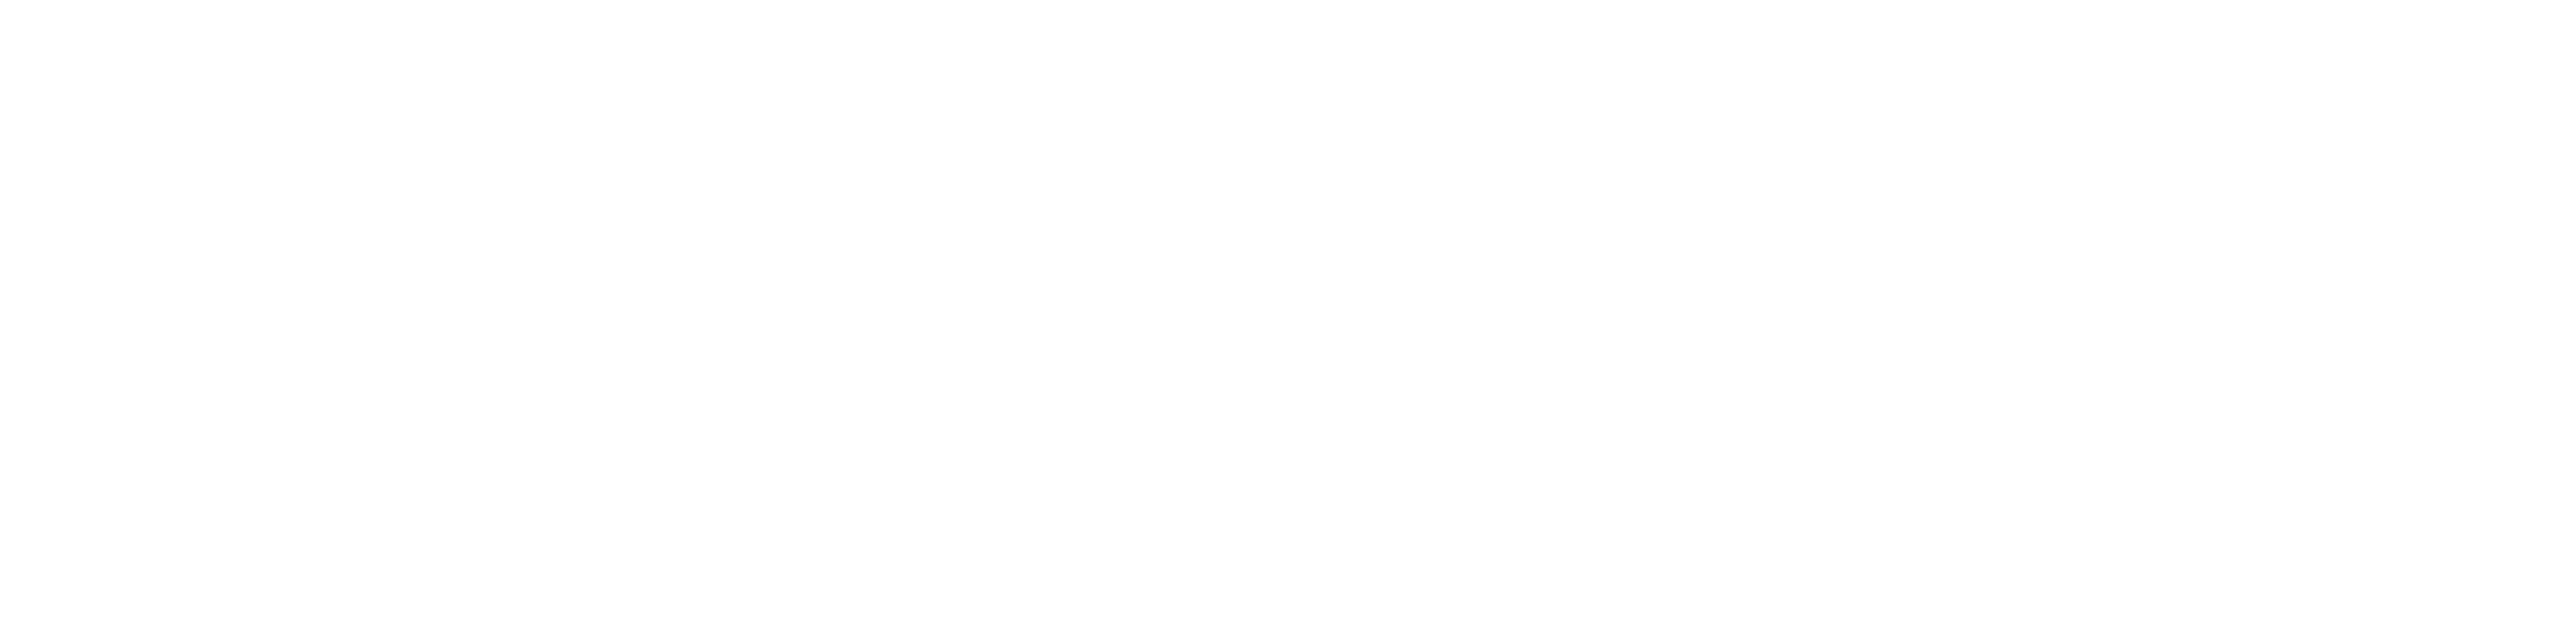

2020-06-02 23:49:15,062 logger INFO loss 0.40, 3D Dis:  4.80mm, shiftDiff: 32415.708984, MemUsed:50.86
2020-06-02 23:49:24,115 logger INFO loss 0.40, 3D Dis:  4.80mm, shiftDiff: 32398.312500, MemUsed:50.86
2020-06-02 23:49:33,182 logger INFO loss 0.40, 3D Dis:  4.80mm, shiftDiff: 32381.025391, MemUsed:50.86
2020-06-02 23:49:42,284 logger INFO loss 0.40, 3D Dis:  4.80mm, shiftDiff: 32363.826172, MemUsed:50.86
2020-06-02 23:49:51,375 logger INFO loss 0.40, 3D Dis:  4.79mm, shiftDiff: 32346.500000, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


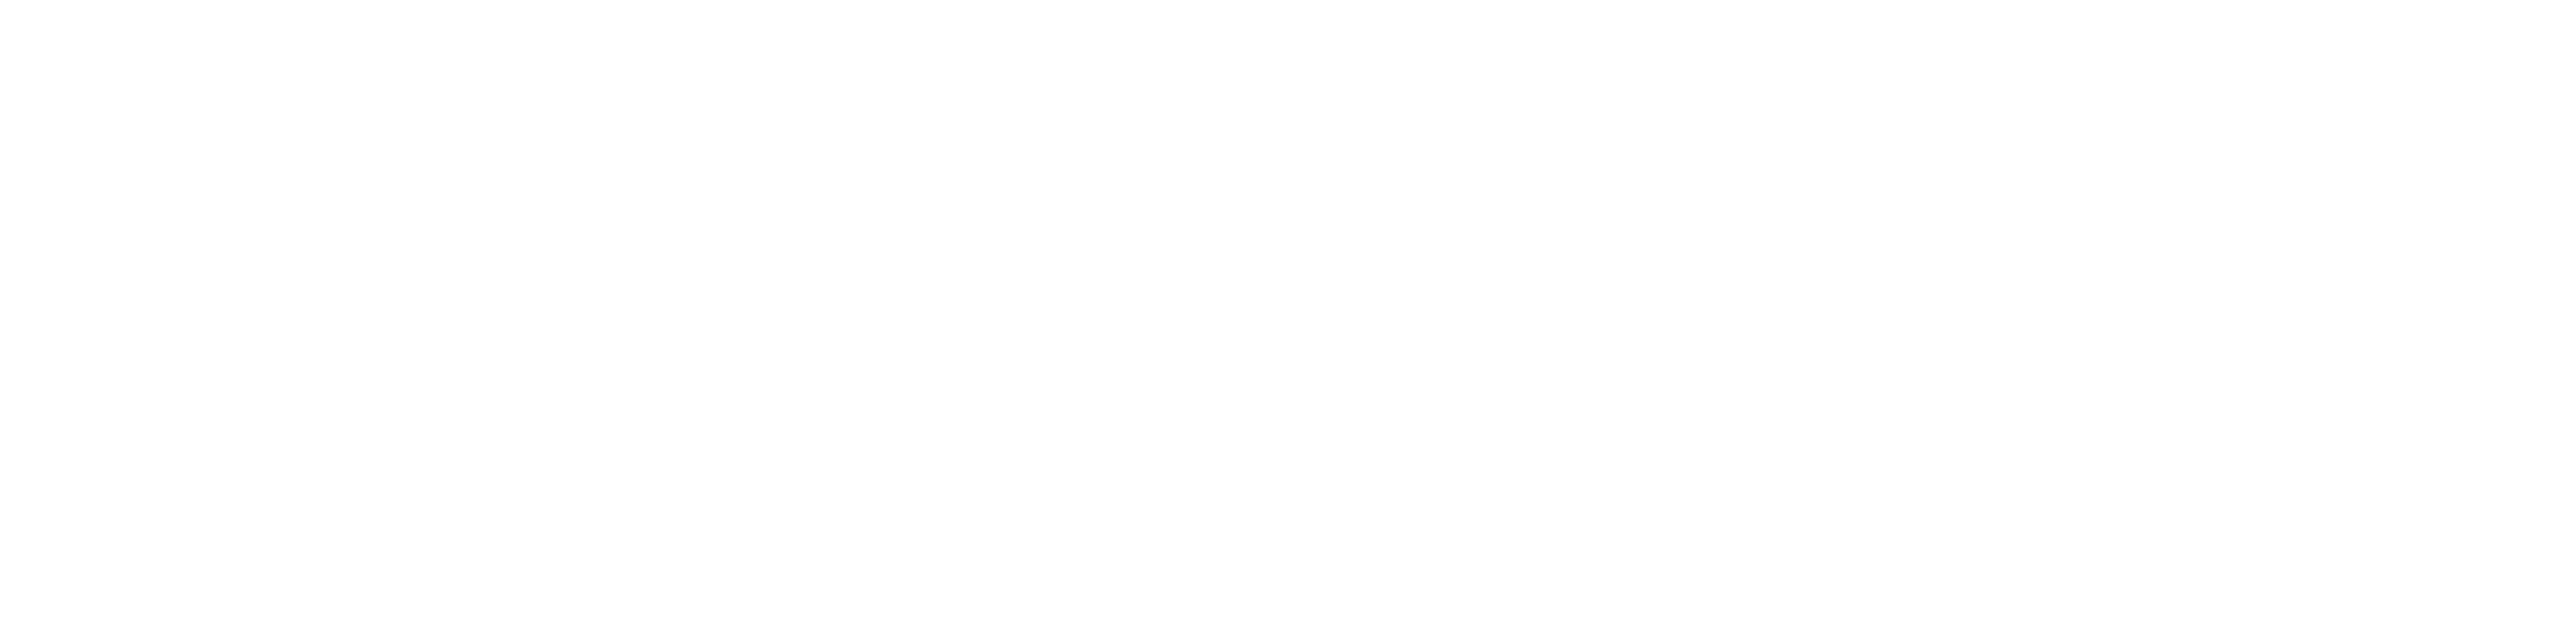

2020-06-02 23:50:19,949 logger INFO loss 0.40, 3D Dis:  4.79mm, shiftDiff: 32329.046875, MemUsed:50.86
2020-06-02 23:50:28,912 logger INFO loss 0.40, 3D Dis:  4.79mm, shiftDiff: 32311.873047, MemUsed:50.86
2020-06-02 23:50:37,987 logger INFO loss 0.40, 3D Dis:  4.79mm, shiftDiff: 32295.152344, MemUsed:50.86
2020-06-02 23:50:47,027 logger INFO loss 0.40, 3D Dis:  4.78mm, shiftDiff: 32279.412109, MemUsed:50.86
2020-06-02 23:50:56,118 logger INFO loss 0.40, 3D Dis:  4.78mm, shiftDiff: 32264.039062, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


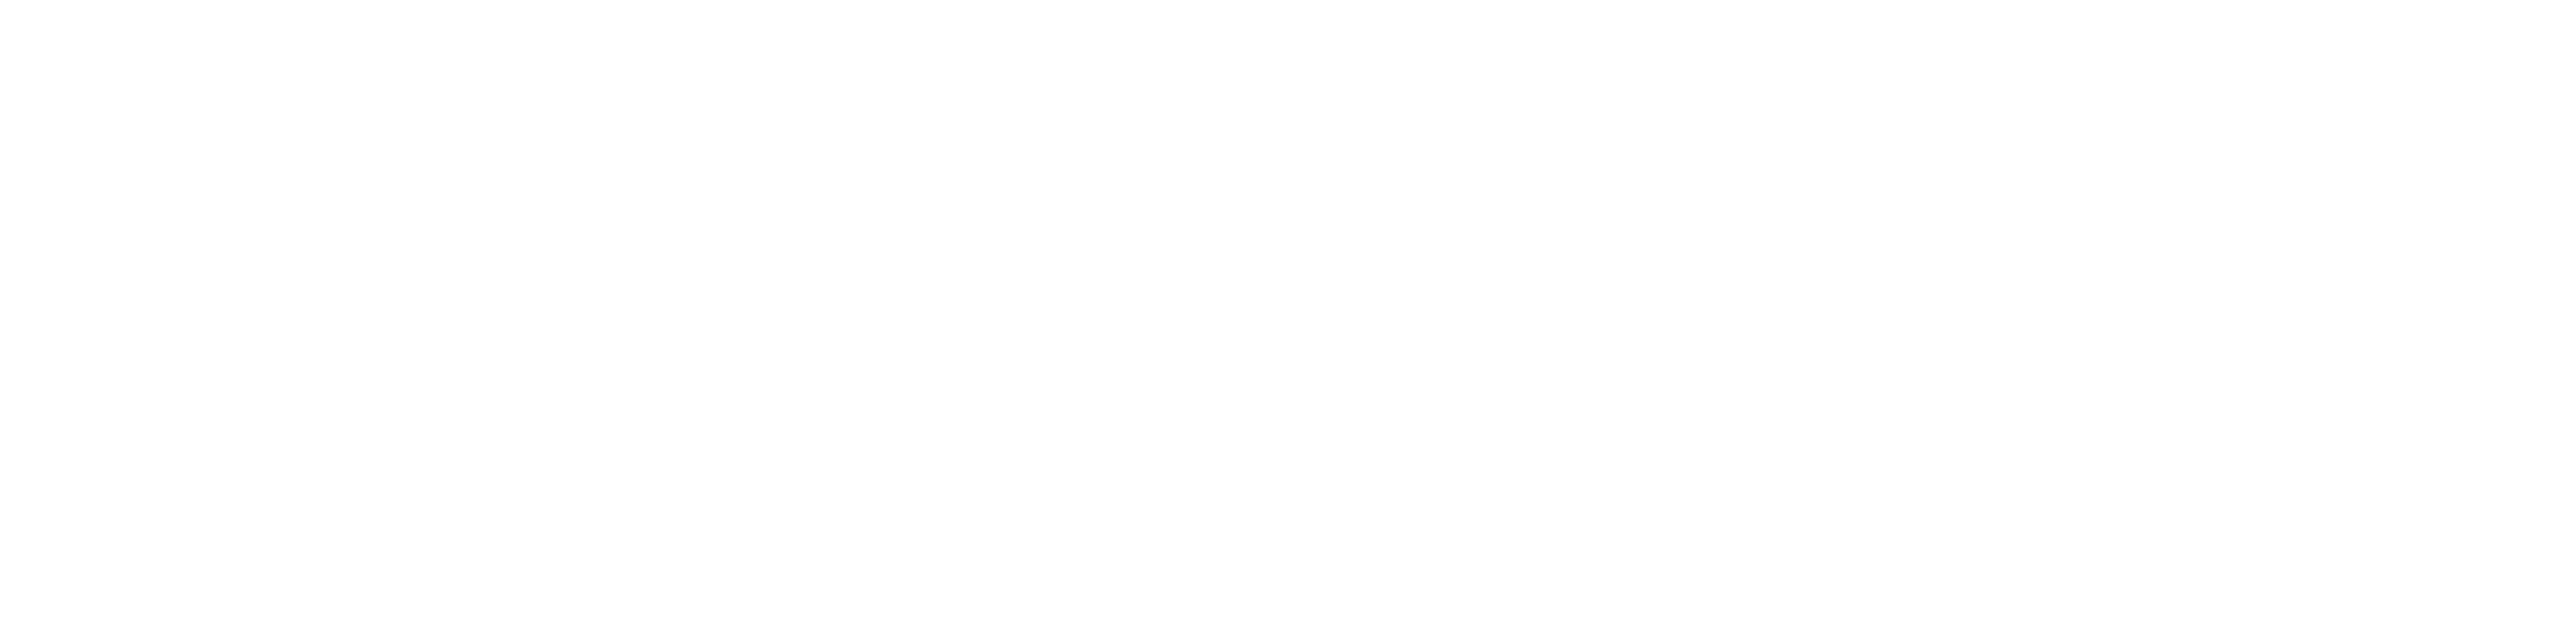

2020-06-02 23:51:24,608 logger INFO loss 0.40, 3D Dis:  4.78mm, shiftDiff: 32248.966797, MemUsed:50.86
2020-06-02 23:51:33,669 logger INFO loss 0.40, 3D Dis:  4.78mm, shiftDiff: 32234.335938, MemUsed:50.86
2020-06-02 23:51:42,766 logger INFO loss 0.40, 3D Dis:  4.78mm, shiftDiff: 32220.316406, MemUsed:50.86
2020-06-02 23:51:51,826 logger INFO loss 0.40, 3D Dis:  4.77mm, shiftDiff: 32206.746094, MemUsed:50.86
2020-06-02 23:52:00,928 logger INFO loss 0.40, 3D Dis:  4.77mm, shiftDiff: 32193.037109, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


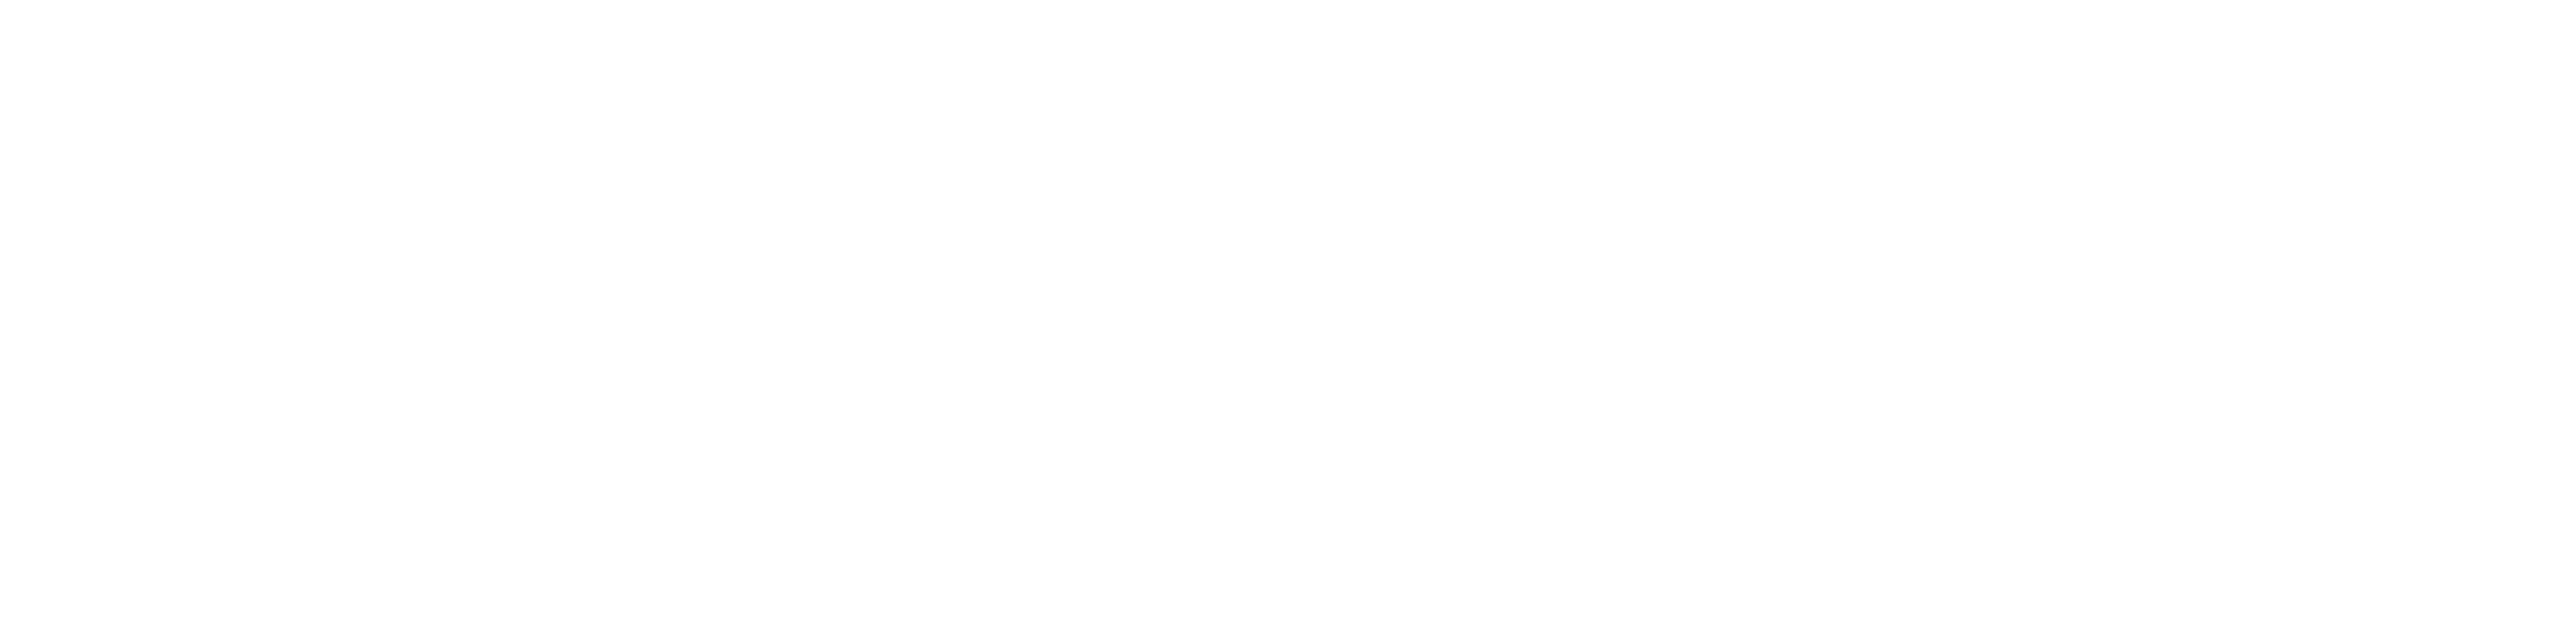

2020-06-02 23:52:29,495 logger INFO loss 0.40, 3D Dis:  4.77mm, shiftDiff: 32179.345703, MemUsed:50.86
2020-06-02 23:52:38,517 logger INFO loss 0.40, 3D Dis:  4.77mm, shiftDiff: 32165.753906, MemUsed:50.86
2020-06-02 23:52:47,603 logger INFO loss 0.39, 3D Dis:  4.77mm, shiftDiff: 32152.015625, MemUsed:50.86
2020-06-02 23:52:56,663 logger INFO loss 0.39, 3D Dis:  4.76mm, shiftDiff: 32138.257812, MemUsed:50.86
2020-06-02 23:53:05,796 logger INFO loss 0.39, 3D Dis:  4.76mm, shiftDiff: 32124.291016, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


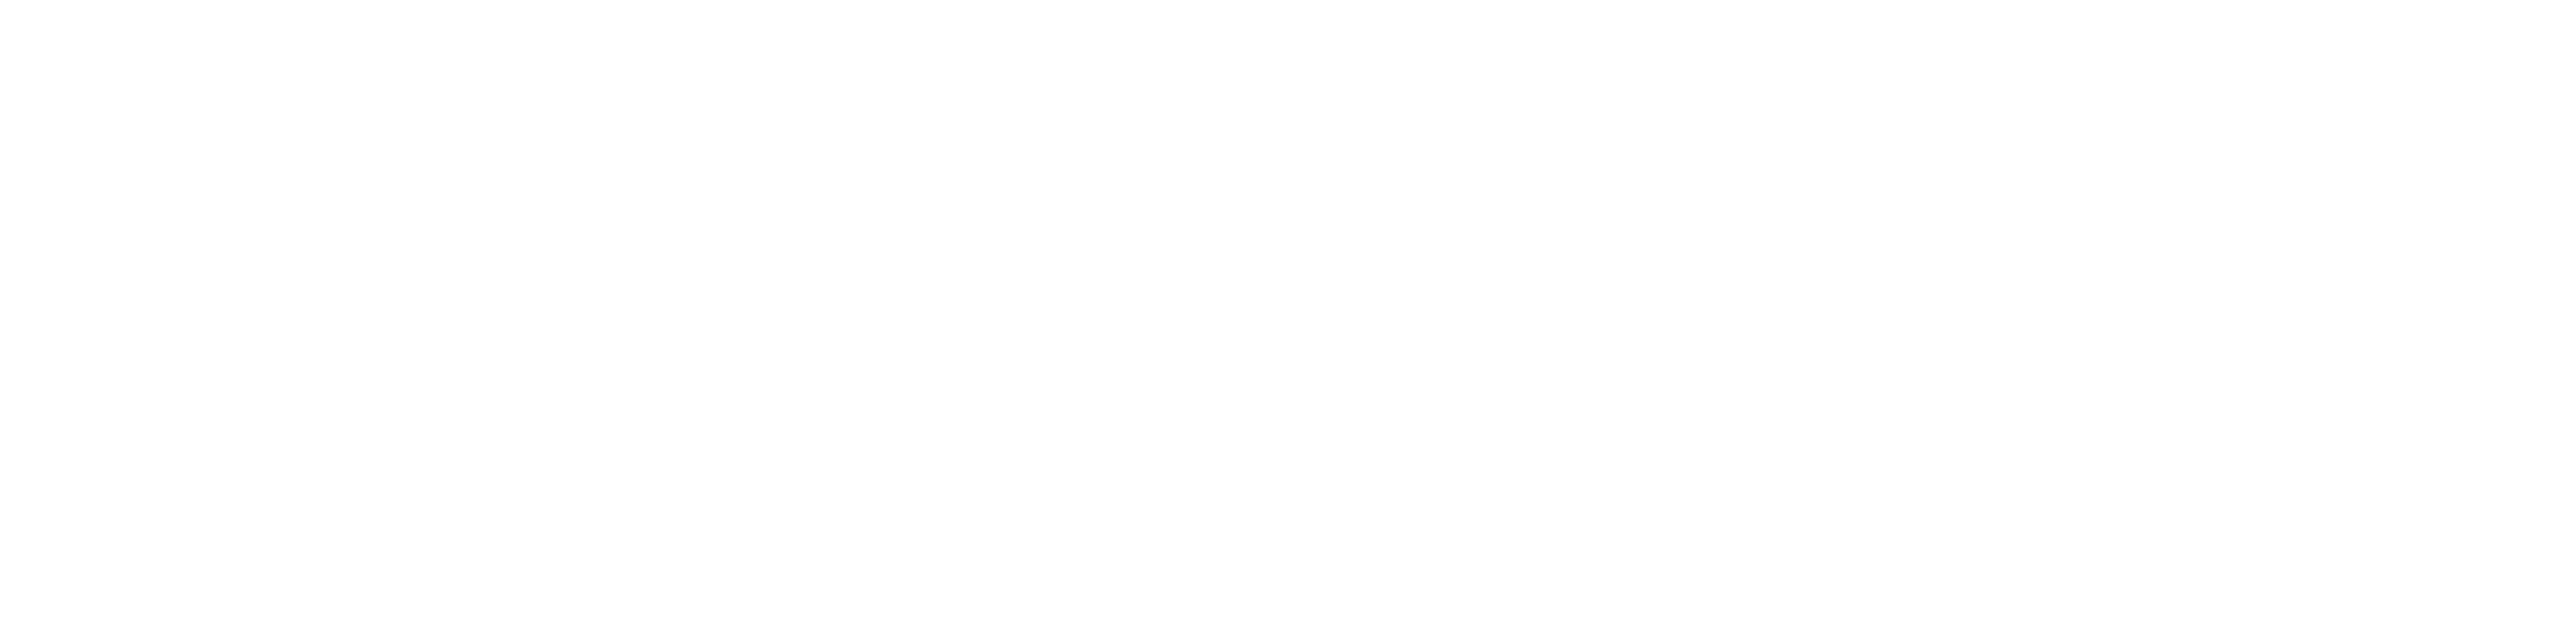

2020-06-02 23:53:34,310 logger INFO loss 0.39, 3D Dis:  4.76mm, shiftDiff: 32110.738281, MemUsed:50.86
2020-06-02 23:53:43,404 logger INFO loss 0.39, 3D Dis:  4.76mm, shiftDiff: 32097.582031, MemUsed:50.86
2020-06-02 23:53:52,464 logger INFO loss 0.39, 3D Dis:  4.76mm, shiftDiff: 32084.277344, MemUsed:50.86
2020-06-02 23:54:01,617 logger INFO loss 0.39, 3D Dis:  4.75mm, shiftDiff: 32070.695312, MemUsed:50.86
2020-06-02 23:54:10,695 logger INFO loss 0.39, 3D Dis:  4.75mm, shiftDiff: 32057.457031, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


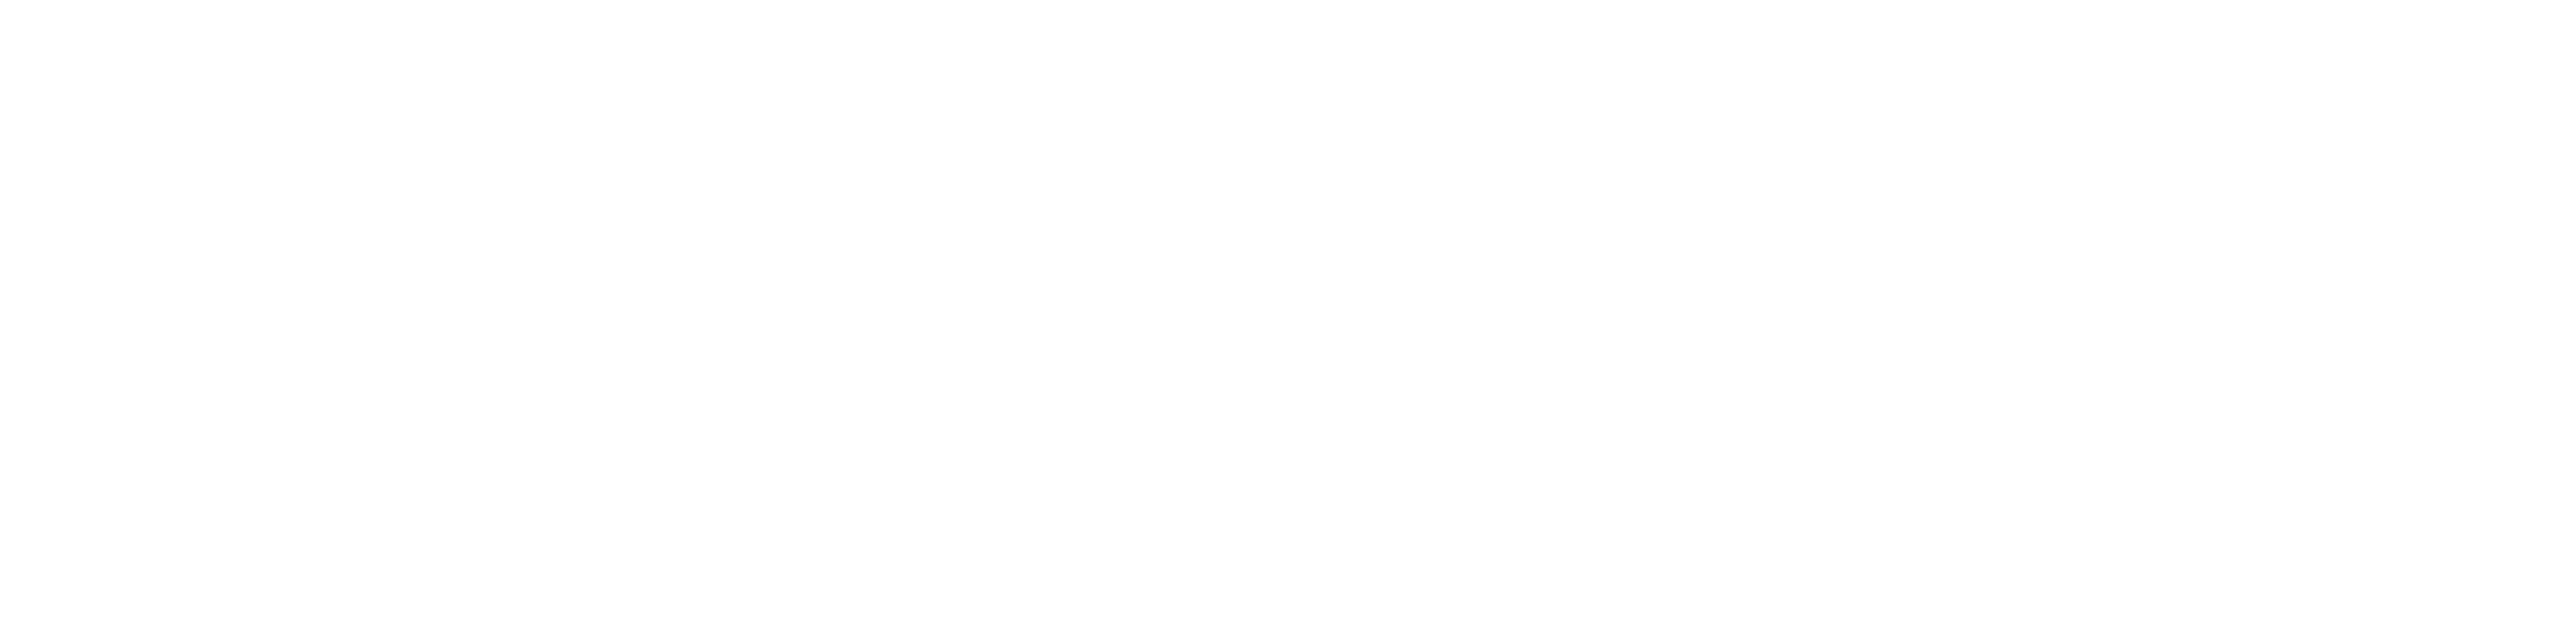

2020-06-02 23:54:39,372 logger INFO loss 0.39, 3D Dis:  4.75mm, shiftDiff: 32044.884766, MemUsed:50.86
2020-06-02 23:54:48,432 logger INFO loss 0.39, 3D Dis:  4.75mm, shiftDiff: 32032.109375, MemUsed:50.86
2020-06-02 23:54:57,571 logger INFO loss 0.39, 3D Dis:  4.75mm, shiftDiff: 32019.320312, MemUsed:50.86
2020-06-02 23:55:06,666 logger INFO loss 0.39, 3D Dis:  4.74mm, shiftDiff: 32006.654297, MemUsed:50.86
2020-06-02 23:55:15,780 logger INFO loss 0.39, 3D Dis:  4.74mm, shiftDiff: 31994.199219, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


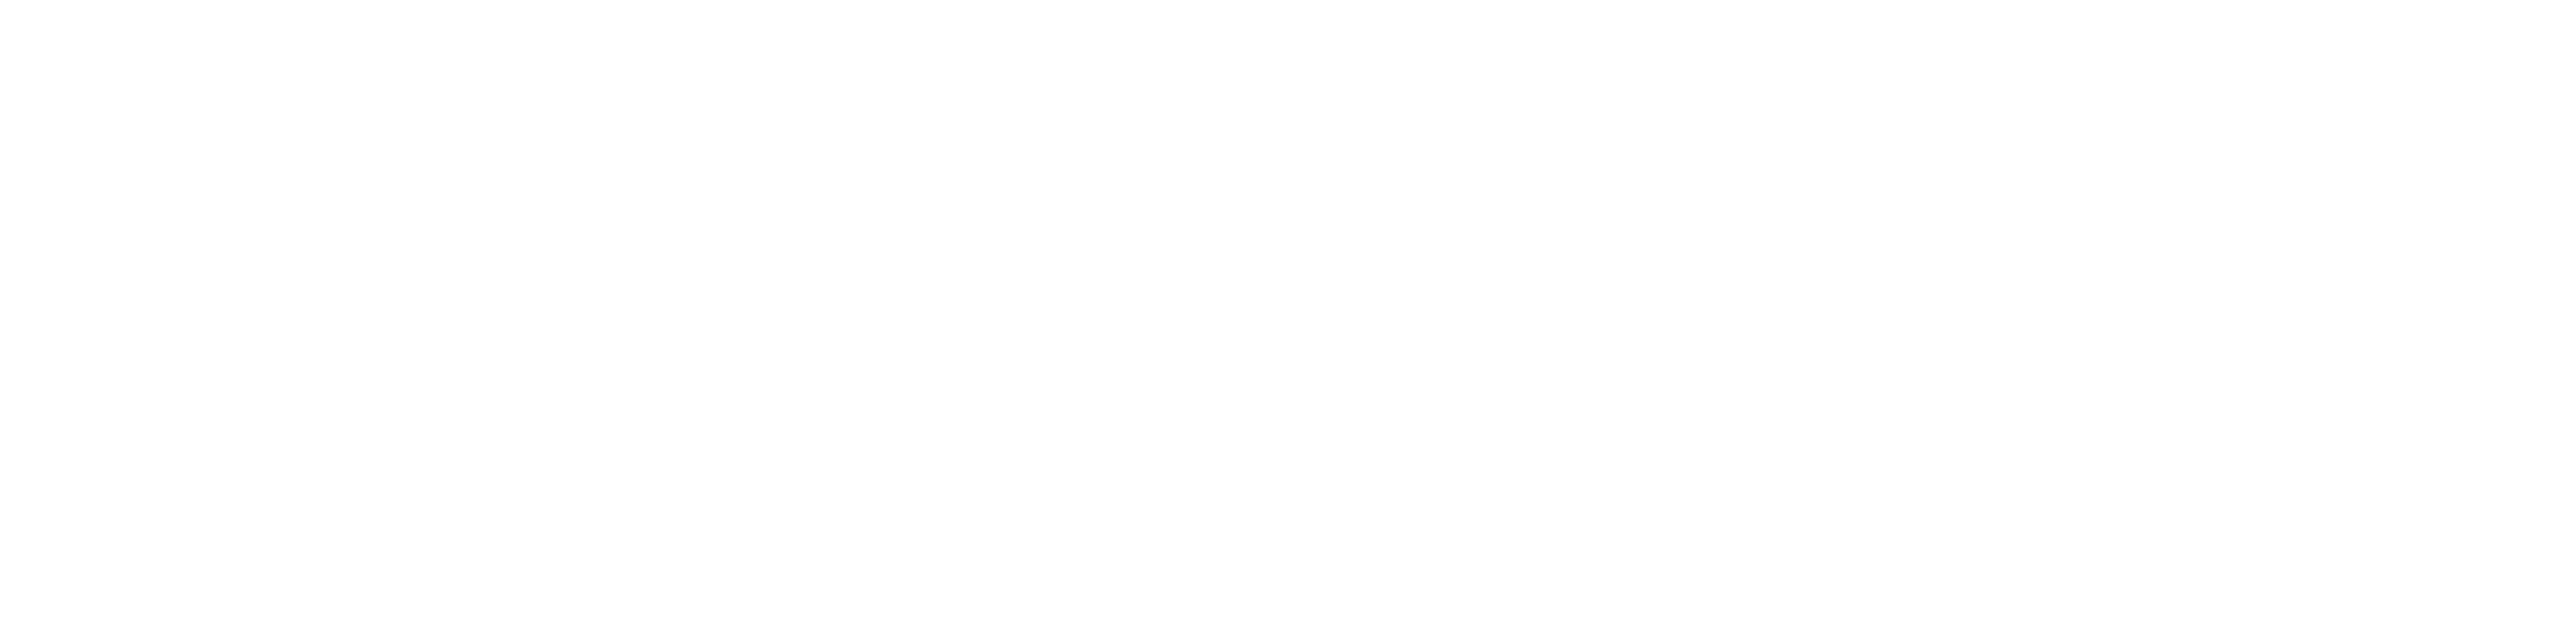

2020-06-02 23:55:44,383 logger INFO loss 0.39, 3D Dis:  4.74mm, shiftDiff: 31982.224609, MemUsed:50.86
2020-06-02 23:55:53,406 logger INFO loss 0.39, 3D Dis:  4.74mm, shiftDiff: 31970.460938, MemUsed:50.86
2020-06-02 23:56:02,512 logger INFO loss 0.39, 3D Dis:  4.74mm, shiftDiff: 31958.685547, MemUsed:50.86
2020-06-02 23:56:11,593 logger INFO loss 0.39, 3D Dis:  4.73mm, shiftDiff: 31946.828125, MemUsed:50.86
2020-06-02 23:56:20,659 logger INFO loss 0.39, 3D Dis:  4.73mm, shiftDiff: 31935.308594, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


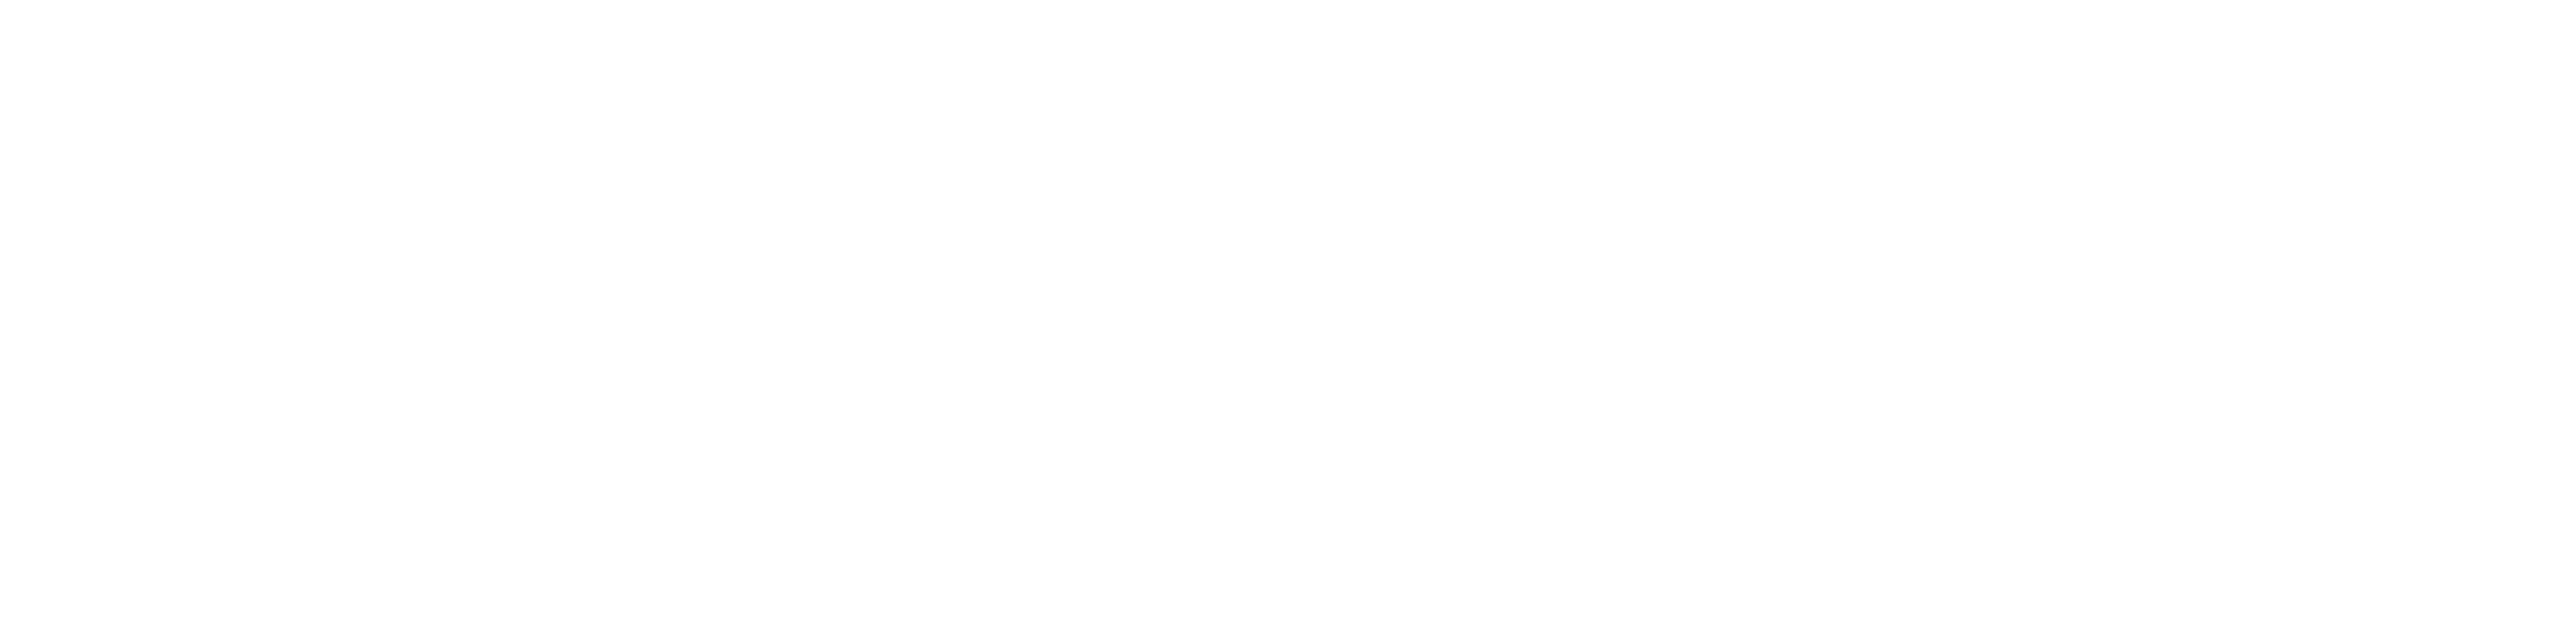

2020-06-02 23:56:49,220 logger INFO loss 0.39, 3D Dis:  4.73mm, shiftDiff: 31924.378906, MemUsed:50.86
2020-06-02 23:56:58,254 logger INFO loss 0.39, 3D Dis:  4.73mm, shiftDiff: 31913.396484, MemUsed:50.86
2020-06-02 23:57:07,291 logger INFO loss 0.39, 3D Dis:  4.73mm, shiftDiff: 31902.828125, MemUsed:50.86
2020-06-02 23:57:16,393 logger INFO loss 0.39, 3D Dis:  4.73mm, shiftDiff: 31892.621094, MemUsed:50.86
2020-06-02 23:57:25,506 logger INFO loss 0.39, 3D Dis:  4.72mm, shiftDiff: 31882.621094, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


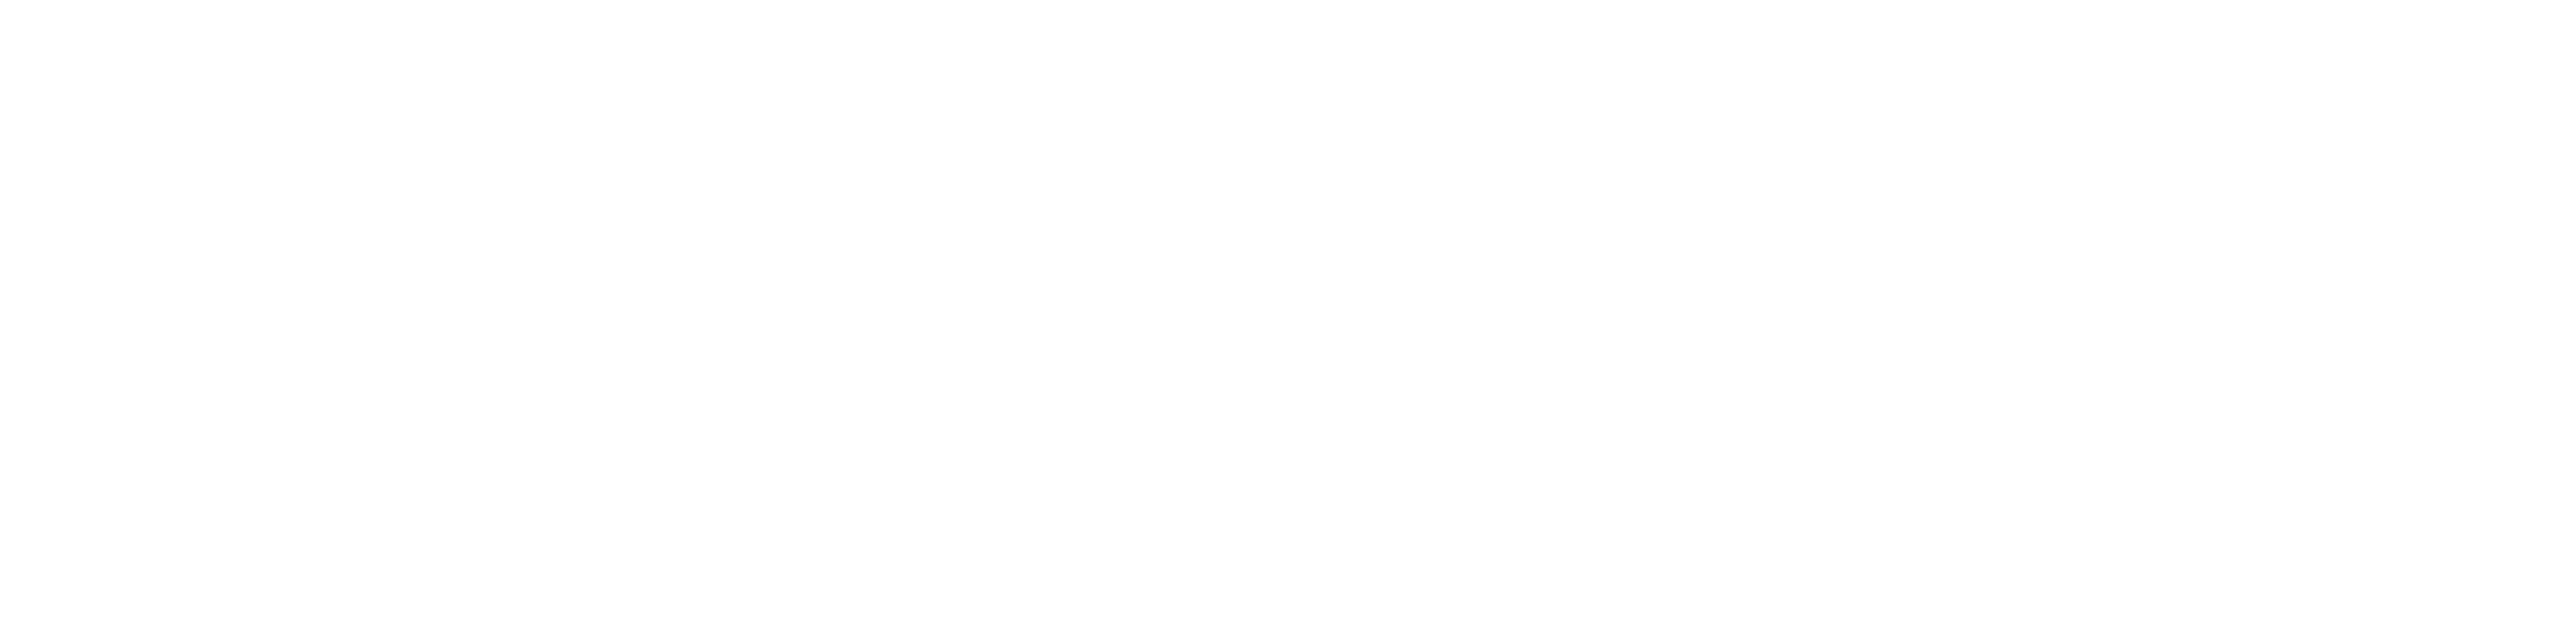

2020-06-02 23:57:54,069 logger INFO loss 0.39, 3D Dis:  4.72mm, shiftDiff: 31872.851562, MemUsed:50.86
2020-06-02 23:58:03,105 logger INFO loss 0.39, 3D Dis:  4.72mm, shiftDiff: 31863.582031, MemUsed:50.86
2020-06-02 23:58:12,186 logger INFO loss 0.39, 3D Dis:  4.72mm, shiftDiff: 31854.759766, MemUsed:50.86
2020-06-02 23:58:21,348 logger INFO loss 0.39, 3D Dis:  4.72mm, shiftDiff: 31846.091797, MemUsed:50.86
2020-06-02 23:58:30,501 logger INFO loss 0.39, 3D Dis:  4.72mm, shiftDiff: 31837.617188, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


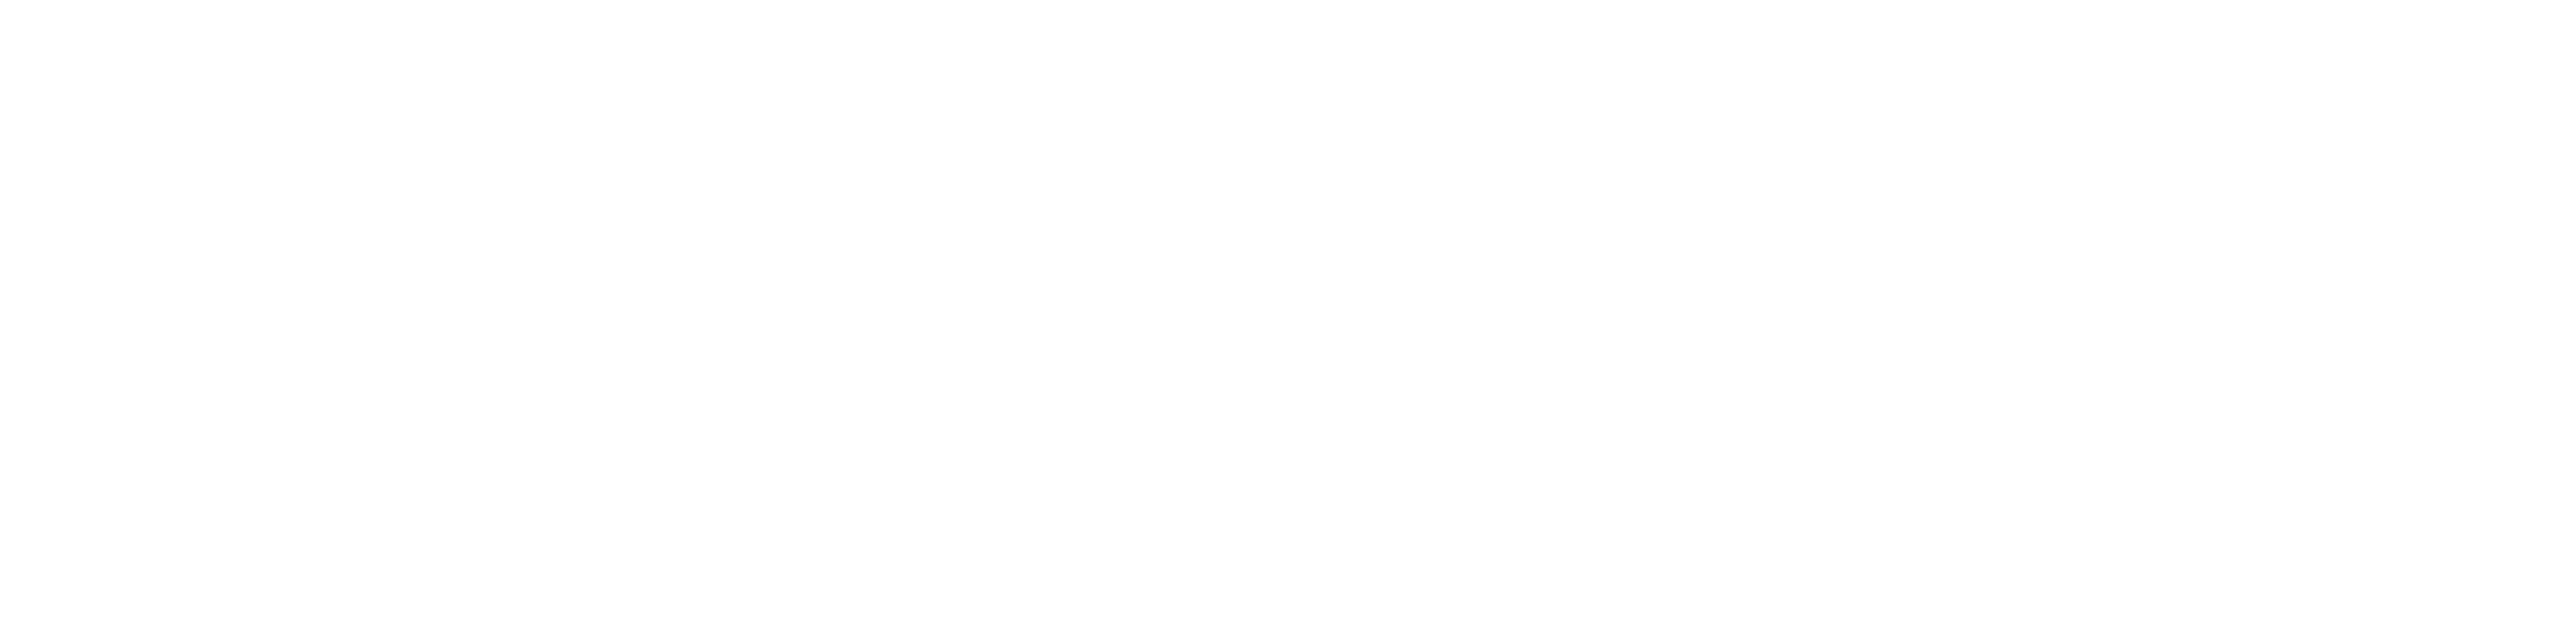

2020-06-02 23:58:59,049 logger INFO loss 0.39, 3D Dis:  4.72mm, shiftDiff: 31829.583984, MemUsed:50.86
2020-06-02 23:59:08,152 logger INFO loss 0.39, 3D Dis:  4.72mm, shiftDiff: 31822.019531, MemUsed:50.86
2020-06-02 23:59:17,231 logger INFO loss 0.39, 3D Dis:  4.71mm, shiftDiff: 31814.697266, MemUsed:50.86
2020-06-02 23:59:26,327 logger INFO loss 0.39, 3D Dis:  4.71mm, shiftDiff: 31807.552734, MemUsed:50.86
2020-06-02 23:59:35,400 logger INFO loss 0.39, 3D Dis:  4.71mm, shiftDiff: 31800.472656, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>

2020-06-03 00:00:04,132 logger INFO loss 0.39, 3D Dis:  4.71mm, shiftDiff: 31793.320312, MemUsed:50.86
2020-06-03 00:00:13,149 logger INFO loss 0.39, 3D Dis:  4.71mm, shiftDiff: 31786.187500, MemUsed:50.86
2020-06-03 00:00:22,243 logger INFO loss 0.39, 3D Dis:  4.71mm, shiftDiff: 31779.457031, MemUsed:50.86
2020-06-03 00:00:31,336 logger INFO loss 0.39, 3D Dis:  4.71mm, shiftDiff: 31773.253906, MemUsed:50.86


In [ ]:
loop = tqdm_notebook(range(cfg.numIterations))
saveVTK(join(outFolderMesh, 'Target.vtk'), modifiedVertsRef.cpu().detach().numpy(), smplshExampleMesh)
for i in loop:
    optimizer.zero_grad()
#     torch.cuda.empty_cache()

    lossVal = 0
    for iCam in range(cfg.numCams):
        refImg = torch.tensor(imagesRef[iCam][..., 3], dtype=torch.float64, device=device, requires_grad=False)
        modifiedVerts = verts + normalShift * nNormals
        mesh = Meshes(
                verts=[modifiedVerts],   
                faces=[faces_idx], 
#                 textures=textures.to(device)
            )
        
        images = renderSynth.renderer(mesh, cameras=cams[iCam])
#         print(images.requires_grad)
#         print(modifiedVerts.requires_grad)
        loss = 1 - torch.norm(refImg * images[..., 3], p=1) / torch.norm(refImg + images[..., 3] - refImg * images[..., 3], p=1)
        
        loss.backward()
        lossVal += loss.item()
        torch.cuda.empty_cache()
        #showCudaMemUsage(device)
    
    modifiedVerts = verts + normalShift * nNormals
    mesh = Meshes(
                verts=[modifiedVerts],   
                faces=[faces_idx], 
#                 textures=textures.to(device)
            )
    loss = cfg.lpSmootherW * mesh_laplacian_smoothing(mesh) + cfg.normalSmootherW * mesh_normal_consistency(mesh)
    loss.backward()
    lossVal += loss.item()
    # targetImg = images[0, ..., :3]
    # loss, _ = model()
    
    # recordData
    losses.append(lossVal)
    
    optimizer.step()
    memStats = torch.cuda.memory_stats(device=device)
    memAllocated =  memStats['active_bytes.all.current'] / 1000000
    
    dis3D = modifiedVerts.cpu().detach().numpy() - modifiedVertsRef.cpu().numpy()
    dis3D = np.mean(np.sqrt(dis3D[:,0]**2 + dis3D[:,1]**2 + dis3D[:,2]**2))
    
    infoStr = 'loss %.2f, 3D Dis:  %.2fmm, shiftDiff: %.6f, MemUsed:%.2f' \
        % (lossVal, dis3D, torch.sum(torch.abs(normalShift - cfg.normalShiftLevel)).item(), memAllocated)
    
    loop.set_description(infoStr)
    logger.info(infoStr)
    
    #if lossVal < cfg.terminateLoss:
    #    break
    
    # Save outputs to create a GIF. 
    if i % cfg.plotStep == 0:
        showCudaMemUsage(device)
        modifiedVerts = verts + normalShift * nNormals
        mesh = Meshes(
                verts=[modifiedVerts],   
                faces=[faces_idx], 
#                 textures=textures.to(device)
            )
        
        torch.cuda.empty_cache()
        plt.close('all')
        
        outImgFile = join(outFolderForExperiment, 'Fig_' + str(i).zfill(5) + '.png')
        diffImages = []
        with torch.no_grad():
            for iCam in range(len(cams)):
                image_cur = renderSynth.renderer(mesh,  cameras=cams[iCam])
#                 images.append(image_cur.cpu().detach().numpy())
                imgDiff = np.abs(image_cur.cpu().detach().numpy() - imagesRef[iCam])
                diffImages.append(imgDiff)
                torch.cuda.empty_cache()

#             showCudaMemUsage(device)
        visualize2DResults(diffImages, outImgFile=outImgFile, sizeInInches=5)
        
        saveVTK(join(outFolderMesh, 'Fit' + str(i).zfill(5) + '.vtk'), modifiedVerts.cpu().detach().numpy(), smplshExampleMesh)


In [ ]:
diffImages[0].shape

In [ ]:
np.max(diffImages[0])

In [ ]:
if True:
    showCudaMemUsage(device)
    modifiedVerts = verts + normalShift * nNormals
    mesh = Meshes(
            verts=[modifiedVerts],   
            faces=[faces_idx], 
        )
    
    torch.cuda.empty_cache()
    plt.close('all')
    
    outImgFile = join(outFolderForExperiment, 'Fig_' + str(0).zfill(5) + '.png')
    diffImages = []
    with torch.no_grad():
        for iCam in range(len(cams)):
            image_cur = renderSynth.renderer(mesh,  cameras=cams[iCam])
            imgDiff =  np.abs(image_cur.cpu().detach().numpy() - imagesRef[iCam])
            diffImages.append(imgDiff)
    visualize2DResults(diffImages, outImgFile=outImgFile, sizeInInches=5)
    
    saveVTK(join(outFolderMesh, 'Fit' + str(0).zfill(5) + '.vtk'), modifiedVerts.cpu().detach().numpy(), smplshExampleMesh)